### Copy of notebook for the RF permutation Importance analyses and merged sensitivity analysis.

This notebook trains random forest on inputs and outputs from kostadinov dataset and uses only inputs found in giss model with the aim to use the trained random forest on giss data and analyse the giss performance

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import cartopy.mpl.ticker as cticker
import timeit
import warnings
warnings.filterwarnings("ignore")

In [2]:
# filepath = "C:/Users/dutts/OneDrive - Johns Hopkins/Documents/copernicus/"
# chartpath = "C:/Users/dutts/OneDrive - Johns Hopkins/Documents/copernicus/charts/"
filepath  = "/Users/sdutta/OneDrive - Johns Hopkins/Documents/copernicus/"
chartpath = "/Users/sdutta/OneDrive - Johns Hopkins/Documents/copernicus/charts/"

### Data Analysis

In [3]:
ds = xr.open_dataset(filepath + "2010-2023_cmems_bgc_plankton_variable_fill.nc", engine="netcdf4")
ds

<xarray.Dataset> Size: 56MB
Dimensions:  (lat: 161, month: 12, lon: 360)
Coordinates:
  * lat      (lat) float64 1kB -77.5 -76.5 -75.5 -74.5 ... 79.5 80.5 81.5 82.5
  * month    (month) uint64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables: (12/20)
    dfe      (lat, month, lon) float32 3MB ...
    mld      (lat, month, lon) float32 3MB ...
    nh4      (lat, month, lon) float32 3MB ...
    no3      (lat, month, lon) float32 3MB ...
    po4      (lat, month, lon) float32 3MB ...
    rsn      (lat, month, lon) float32 3MB ...
    ...       ...
    pico     (lat, month, lon) float32 3MB ...
    logchla  (lat, month, lon) float32 3MB ...
    logdiat  (lat, month, lon) float32 3MB ...
    logmcro  (lat, month, lon) float32 3MB ...
    lognano  (lat, month, lon) float32 3MB ...
    logpico  (lat, month, lon) float32 3MB ...

In [4]:
def convert360_180(ds):
    """
    convert longitude from 0-360 to -180-180
    """
    #check if already 
    attrs = ds['lon'].attrs
    if ds['lon'].min()>= 0:
        with xr.set_options(keep_attrs=True):
            ds.coords['lon'] = (ds['lon'] + 180) % 360 - 180
        ds = ds.sortby('lon')
    return ds

Min-Max scaler scales all features in the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.The main idea behind normalization/standardization is always the same. Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.
Note: Tree-based models are usually not dependent on scaling, but non-tree models models such as SVM, LDA etc. are often hugely dependent on it.

In [5]:
data = ds.to_dataframe()
data = data.dropna()
data = data.astype("float32")
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 430620 entries, (np.float64(-77.5), np.uint64(1), np.float64(-178.5)) to (np.float64(82.5), np.uint64(12), np.float64(81.5))
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   dfe      430620 non-null  float32
 1   mld      430620 non-null  float32
 2   nh4      430620 non-null  float32
 3   no3      430620 non-null  float32
 4   po4      430620 non-null  float32
 5   rsn      430620 non-null  float32
 6   sst      430620 non-null  float32
 7   sal      430620 non-null  float32
 8   w50      430620 non-null  float32
 9   sil      430620 non-null  float32
 10  chla     430620 non-null  float32
 11  diat     430620 non-null  float32
 12  mcro     430620 non-null  float32
 13  nano     430620 non-null  float32
 14  pico     430620 non-null  float32
 15  logchla  430620 non-null  float32
 16  logdiat  430620 non-null  float32
 17  logmcro  430620 non-null  float32
 18  lognano

Permutation Feature Importance

The idea behind feature importance is simple. Inputs that are useful for prediction contain valuable information. If you destroy that information by randomly shuffling the feature values, the quality of your predictions should decrease. If the decrease in quality is small, then the information in the original predictor wasn’t very impactful in determining your predictions — your model is still pretty good without it. Furthermore, if the decrease is large, then the information in the original predictor had a large impact on your predictions.

This idea is implemented in three simple steps. Say that you’ve trained an ML model and recorded some measure of quality for the predictions (ex. MSE, log-loss, etc). For each predictor in the dataset:

Randomly shuffle the data in the predictor while keeping the values of other predictors constant
Generate new predictions based on the shuffled values and evaluate the quality of your new predictions
Compute the feature importance score by calculating the decrease in the quality of your new predictions relative to your original predictions
Once you’ve computed feature importance scores for all of your features, you can rank them in terms of predictive usefulness. To help explain permutation feature importance more concretely, consider the following synthetic case study.

In [6]:
data.columns

Index(['dfe', 'mld', 'nh4', 'no3', 'po4', 'rsn', 'sst', 'sal', 'w50', 'sil',
       'chla', 'diat', 'mcro', 'nano', 'pico', 'logchla', 'logdiat', 'logmcro',
       'lognano', 'logpico'],
      dtype='object')

In [7]:
data.describe()

dfe            mld            nh4            no3  \
count  4.306200e+05  430620.000000  430620.000000  430620.000000   
mean   4.754166e-07      91.442535       0.000175       0.007261   
std    4.607328e-07      93.465118       0.000183       0.009665   
min    5.045405e-08       0.000000       0.000004       0.000000   
25%    2.073971e-07      38.328999       0.000042       0.000154   
50%    3.108504e-07      62.179001       0.000107       0.001389   
75%    5.599323e-07     107.845001       0.000238       0.012959   
max    1.048039e-05    1535.265015       0.001296       0.046754   

                 po4            rsn            sst            sal  \
count  430620.000000  430620.000000  430620.000000  430620.000000   
mean        0.000659     156.378860      15.599384      34.591812   
std         0.000635      88.494774      10.710093       1.331383   
min         0.000000       0.000000      -1.907710       8.198891   
25%         0.000159      81.030769       5.333675      33.969212   
50%         0.000364     176.196152      17.778295      34.561710   
75%         0.001116     229.573074      25.918709      35.361088   
max         0.003029     324.159271      33.400288      40.561287   

                w50            sil           chla           diat  \
count  4.306200e+05  430620.000000  430620.000000  430620.000000   
mean   9.372243e-08       0.010300       0.201651       0.075889   
std    3.610361e-06       0.017252       0.282658       0.279966   
min   -8.690639e-05       0.000000       0.001282       0.000654   
25%   -1.165175e-06       0.001434       0.072345       0.007625   
50%   -2.343923e-07       0.002941       0.131180       0.019383   
75%    1.095683e-06       0.007531       0.213260       0.072724   
max    8.469214e-05       0.127774      11.796865      44.115402   

                mcro           nano           pico        logchla  \
count  430620.000000  430620.000000  430620.000000  430620.000000   
mean        0.090931       0.047369       0.071626      -0.882256   
std         0.292912       0.049586       0.071434       0.378401   
min         0.001292       0.002151       0.003393      -2.892251   
25%         0.012891       0.018097       0.047923      -1.140591   
50%         0.027130       0.031989       0.064424      -0.882133   
75%         0.090988       0.056026       0.081943      -0.671092   
max        44.686905       1.735970       8.653007       1.071767   

             logdiat        logmcro        lognano        logpico  
count  430620.000000  430620.000000  430620.000000  430620.000000  
mean       -1.602103      -1.441907      -1.477511      -1.243009  
std         0.597197       0.531156       0.352588       0.312411  
min        -3.184744      -2.888578      -2.667410      -2.469407  
25%        -2.117766      -1.889712      -1.742403      -1.319460  
50%        -1.712586      -1.566543      -1.494993      -1.190954  
75%        -1.138325      -1.041015      -1.251609      -1.086488  
max         1.644590       1.650180       0.239542       0.937167

In [8]:
dsm = ds.mean(dim='month')

In [9]:
dsm

<xarray.Dataset> Size: 5MB
Dimensions:  (lat: 161, lon: 360)
Coordinates:
  * lat      (lat) float64 1kB -77.5 -76.5 -75.5 -74.5 ... 79.5 80.5 81.5 82.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables: (12/20)
    dfe      (lat, lon) float32 232kB nan 4.938e-07 4.873e-07 ... nan nan nan
    mld      (lat, lon) float32 232kB nan 312.2 310.5 309.1 ... nan nan nan nan
    nh4      (lat, lon) float32 232kB nan 0.0002391 0.0002309 ... nan nan nan
    no3      (lat, lon) float32 232kB nan 0.02179 0.02194 ... nan nan nan
    po4      (lat, lon) float32 232kB nan 0.001628 0.00163 ... nan nan nan
    rsn      (lat, lon) float32 232kB nan 30.58 29.49 28.31 ... nan nan nan nan
    ...       ...
    pico     (lat, lon) float32 232kB nan 0.05437 0.05895 ... nan nan nan
    logchla  (lat, lon) float32 232kB nan -0.8178 -0.594 -0.342 ... nan nan nan
    logdiat  (lat, lon) float32 232kB nan -0.5036 -0.3192 ... nan nan nan
    logmcro  (lat, lon) float32 232kB nan -0.4624 -0.2878 ... nan nan nan
    lognano  (lat, lon) float32 232kB nan -1.511 -1.467 -1.366 ... nan nan nan
    logpico  (lat, lon) float32 232kB nan -1.497 -1.455 -1.388 ... nan nan nan

In [10]:
def dist_plot(dsm, psc, vmin, vmax, levels, title, name):
    fig = plt.figure(figsize=(5.5,4.5), dpi=100)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    cs = ax.contourf(dsm['lon'],
                     dsm['lat'],
                     dsm[psc],
                     transform=ccrs.PlateCarree(),
                     cmap='viridis', 
                     robust=True,
                     vmin= vmin, 
                     vmax= vmax, 
                     levels=levels,
                     extend='both')
    
    font_title = {'family':'Times New Roman','color':'black','fontsize':16,'fontweight':'bold'}
    ax.set_title(title, fontdict=font_title)
    ax.coastlines()
    
    ax.set_xlabel("Longitude", fontsize=14)
    ax.set_xticks(np.arange(-180,180,60), crs=ccrs.PlateCarree())
    
    ax.set_ylabel("Latitude", fontsize=14)
    ax.set_yticks(np.arange(-90,90,30), crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', labelsize=12)
    
    cbar = plt.colorbar(cs, orientation='horizontal', shrink=1.0, pad=0.2)
    # cbar.set_label(r'Log Chlor_a (mg $m^-3$)', fontsize=12)
    cbar.ax.tick_params(labelsize=14)
    
    fig.savefig(chartpath + name ,dpi=200,bbox_inches="tight")
    plt.show()

In [11]:
print(dsm['logchla'].min().values, dsm['logchla'].max().values)

-2.8089173 0.79005533


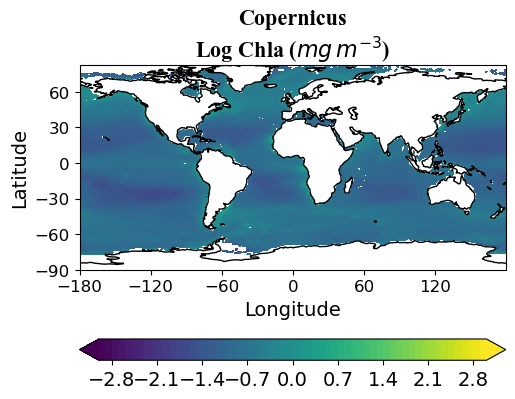

In [12]:
dist_plot(
    dsm=dsm,
    psc='logchla',
    vmin=-3.0,
    vmax=3.0,
    levels=np.linspace(-3.0,3.0,61),
    title="Copernicus\nLog Chla (${mg}\,{m^{-3}}$)",
    name="copernicus_chla_dist_varfill.jpg"
)

In [13]:
print(dsm['logmcro'].min().values, dsm['logmcro'].max().values)

-2.728977 0.39642176


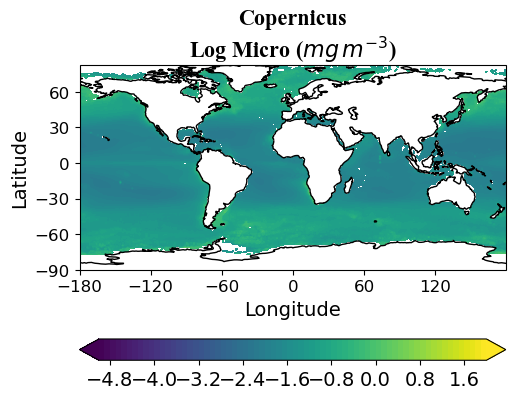

In [14]:
dist_plot(
    dsm=dsm,
    psc='logmcro',
    vmin=-5.0,
    vmax=2.0,
    levels=np.linspace(-5.0,2.0,71),
    title="Copernicus\nLog Micro (${mg}\,{m^{-3}}$)",
    name="copernicus_mcro_dist_varfill.jpg"
)

In [15]:
print(dsm['lognano'].min().values, dsm['lognano'].max().values)

-2.5840764 -0.2527912


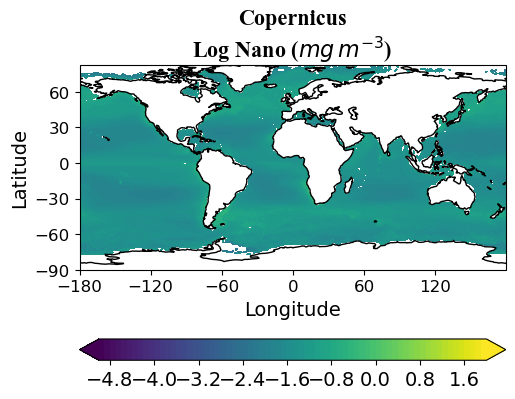

In [16]:
dist_plot(
    dsm=dsm,
    psc='lognano',
    vmin=-5.0,
    vmax=2.0,
    levels=np.linspace(-5.0,2.0,71),
    title="Copernicus\nLog Nano (${mg}\,{m^{-3}}$)",
    name="copernicus_nano_dist_varfill.jpg"
)

In [17]:
print(dsm['logpico'].min().values, dsm['logpico'].max().values)

-2.3860743 0.006253416


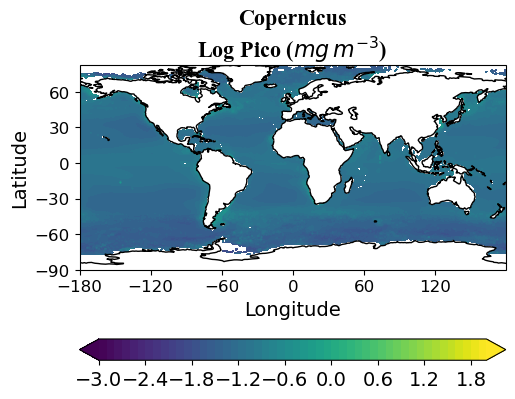

In [18]:
dist_plot(
    dsm=dsm,
    psc='logpico',
    vmin=-3.0,
    vmax=2.0,
    levels=np.linspace(-3.0,2.0,51),
    title="Copernicus\nLog Pico (${mg}\,{m^{-3}}$)",
    name="copernicus_pico_dist_varfill.jpg"
)

In [19]:
data.describe()

dfe            mld            nh4            no3  \
count  4.306200e+05  430620.000000  430620.000000  430620.000000   
mean   4.754166e-07      91.442535       0.000175       0.007261   
std    4.607328e-07      93.465118       0.000183       0.009665   
min    5.045405e-08       0.000000       0.000004       0.000000   
25%    2.073971e-07      38.328999       0.000042       0.000154   
50%    3.108504e-07      62.179001       0.000107       0.001389   
75%    5.599323e-07     107.845001       0.000238       0.012959   
max    1.048039e-05    1535.265015       0.001296       0.046754   

                 po4            rsn            sst            sal  \
count  430620.000000  430620.000000  430620.000000  430620.000000   
mean        0.000659     156.378860      15.599384      34.591812   
std         0.000635      88.494774      10.710093       1.331383   
min         0.000000       0.000000      -1.907710       8.198891   
25%         0.000159      81.030769       5.333675      33.969212   
50%         0.000364     176.196152      17.778295      34.561710   
75%         0.001116     229.573074      25.918709      35.361088   
max         0.003029     324.159271      33.400288      40.561287   

                w50            sil           chla           diat  \
count  4.306200e+05  430620.000000  430620.000000  430620.000000   
mean   9.372243e-08       0.010300       0.201651       0.075889   
std    3.610361e-06       0.017252       0.282658       0.279966   
min   -8.690639e-05       0.000000       0.001282       0.000654   
25%   -1.165175e-06       0.001434       0.072345       0.007625   
50%   -2.343923e-07       0.002941       0.131180       0.019383   
75%    1.095683e-06       0.007531       0.213260       0.072724   
max    8.469214e-05       0.127774      11.796865      44.115402   

                mcro           nano           pico        logchla  \
count  430620.000000  430620.000000  430620.000000  430620.000000   
mean        0.090931       0.047369       0.071626      -0.882256   
std         0.292912       0.049586       0.071434       0.378401   
min         0.001292       0.002151       0.003393      -2.892251   
25%         0.012891       0.018097       0.047923      -1.140591   
50%         0.027130       0.031989       0.064424      -0.882133   
75%         0.090988       0.056026       0.081943      -0.671092   
max        44.686905       1.735970       8.653007       1.071767   

             logdiat        logmcro        lognano        logpico  
count  430620.000000  430620.000000  430620.000000  430620.000000  
mean       -1.602103      -1.441907      -1.477511      -1.243009  
std         0.597197       0.531156       0.352588       0.312411  
min        -3.184744      -2.888578      -2.667410      -2.469407  
25%        -2.117766      -1.889712      -1.742403      -1.319460  
50%        -1.712586      -1.566543      -1.494993      -1.190954  
75%        -1.138325      -1.041015      -1.251609      -1.086488  
max         1.644590       1.650180       0.239542       0.937167

In [20]:
data.columns

Index(['dfe', 'mld', 'nh4', 'no3', 'po4', 'rsn', 'sst', 'sal', 'w50', 'sil',
       'chla', 'diat', 'mcro', 'nano', 'pico', 'logchla', 'logdiat', 'logmcro',
       'lognano', 'logpico'],
      dtype='object')

In [21]:
data = data.reset_index()
data = data.set_index(['month','lat','lon'])
data = data.loc[:,['dfe', 'mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50', 'chla', 'diat', 'mcro', 'nano', 'pico', 'logchla', 'logdiat', 'logmcro','lognano', 'logpico']]
data = data.sort_values(by=['month','lat','lon'])
data.head()

dfe        mld       nh4       no3       po4  \
month lat   lon                                                             
1     -77.5 -178.5  2.679019e-07  77.747002  0.000551  0.016134  0.001235   
            -177.5  2.644416e-07  75.447998  0.000523  0.016679  0.001251   
            -176.5  2.960231e-07  73.435997  0.000496  0.017200  0.001268   
            -175.5  2.617441e-07  71.829002  0.000470  0.017657  0.001283   
            -174.5  3.002942e-07  70.742996  0.000440  0.018044  0.001296   

                           rsn        sal      sst       sil           w50  \
month lat   lon                                                              
1     -77.5 -178.5  130.119232  34.274502 -0.25111  0.058165  8.775279e-07   
            -177.5  125.292305  34.261688 -0.30951  0.057787  7.140983e-07   
            -176.5  127.242310  34.249710 -0.36131  0.057461  1.770336e-07   
            -175.5  127.242310  34.238689 -0.40501  0.057123 -5.363125e-07   
            -174.5  121.280769  34.228912 -0.44010  0.056761 -1.706607e-06   

                        chla      diat      mcro      nano      pico  \
month lat   lon                                                        
1     -77.5 -178.5  1.161823  4.171545  4.223311  0.136021  0.160340   
            -177.5  1.264481  2.177002  2.258741  0.170274  0.179286   
            -176.5  1.258695  1.213927  1.295848  0.231647  0.176216   
            -175.5  1.233465  1.934669  2.010873  0.156743  0.169910   
            -174.5  1.460254  1.436142  1.521730  0.188898  0.178811   

                     logchla   logdiat   logmcro   lognano   logpico  
month lat   lon                                                       
1     -77.5 -178.5  0.065140  0.620297  0.625653 -0.866395 -0.794957  
            -177.5  0.101912  0.337859  0.353867 -0.768851 -0.746455  
            -176.5  0.099921  0.084192  0.112554 -0.635173 -0.753953  
            -175.5  0.091127  0.286607  0.303385 -0.804812 -0.769782  
            -174.5  0.164428  0.157198  0.182338 -0.723773 -0.747605

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

In [23]:
mcolors.TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

In [24]:
blue=mcolors.TABLEAU_COLORS['tab:blue']
orange=mcolors.TABLEAU_COLORS['tab:orange']
green=mcolors.TABLEAU_COLORS['tab:green']
red=mcolors.TABLEAU_COLORS['tab:red']
purple=mcolors.TABLEAU_COLORS['tab:purple']
brown=mcolors.TABLEAU_COLORS['tab:brown']
pink=mcolors.TABLEAU_COLORS['tab:pink']
olive=mcolors.TABLEAU_COLORS['tab:olive']
cyan=mcolors.TABLEAU_COLORS['tab:cyan']
gray=mcolors.TABLEAU_COLORS['tab:gray']

In [25]:
my_colors={'dfe':brown,'rsn':orange,'sst':red,'nh4':purple,'no3':pink,'mld':olive,
           'sal':green,'po4':cyan,'w50':gray,'sil':blue}

In [26]:
scaler = MinMaxScaler(feature_range=(0,10))

In [27]:
df = data.loc[:,['dfe','mld','nh4','no3','po4','rsn','sal','sst','sil','w50','logchla','logdiat','logmcro','lognano','logpico']]

In [28]:
n = int(df.shape[0]*0.6)
n

258372

In [29]:
df = shuffle(df)

X = df.drop(['logchla','logdiat','logmcro','lognano','logpico'], axis=1)
X_train = X.iloc[:n,:]
X_test  = X.iloc[n:,:]

Xs_train = scaler.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns=X.columns)

Xs_test = scaler.transform(X_test)
Xs_test = pd.DataFrame(Xs_test, columns=X.columns)

Xs = scaler.transform(X)

In [30]:
X.sort_values(by=['month','lat','lon']).head(10)

dfe        mld       nh4       no3       po4  \
month lat   lon                                                             
1     -77.5 -178.5  2.679019e-07  77.747002  0.000551  0.016134  0.001235   
            -177.5  2.644416e-07  75.447998  0.000523  0.016679  0.001251   
            -176.5  2.960231e-07  73.435997  0.000496  0.017200  0.001268   
            -175.5  2.617441e-07  71.829002  0.000470  0.017657  0.001283   
            -174.5  3.002942e-07  70.742996  0.000440  0.018044  0.001296   
            -173.5  2.701317e-07  70.072998  0.000420  0.018340  0.001307   
            -172.5  3.114747e-07  69.557999  0.000406  0.018547  0.001316   
            -171.5  2.850944e-07  69.613998  0.000393  0.018661  0.001325   
            -170.5  3.290433e-07  69.814003  0.000381  0.018679  0.001331   
            -169.5  3.014012e-07  70.239998  0.000372  0.018618  0.001334   

                           rsn        sal      sst       sil           w50  
month lat   lon                                                             
1     -77.5 -178.5  130.119232  34.274502 -0.25111  0.058165  8.775279e-07  
            -177.5  125.292305  34.261688 -0.30951  0.057787  7.140983e-07  
            -176.5  127.242310  34.249710 -0.36131  0.057461  1.770336e-07  
            -175.5  127.242310  34.238689 -0.40501  0.057123 -5.363125e-07  
            -174.5  121.280769  34.228912 -0.44010  0.056761 -1.706607e-06  
            -173.5  116.253845  34.220612 -0.47101  0.056460 -1.478265e-06  
            -172.5  101.311539  34.212887 -0.49691  0.056268 -4.161636e-07  
            -171.5  112.119232  34.205112 -0.51731  0.056182  7.480007e-07  
            -170.5  115.984619  34.196190 -0.53291  0.056173  1.114378e-06  
            -169.5  119.596153  34.184689 -0.54661  0.056338  1.496266e-07

In [31]:
ychla = df['logchla']
ydiat = df['logdiat']
ymcro = df['logmcro']
ynano = df['lognano']
ypico = df['logpico']

In [32]:
re_test={}
rn_test={}
r2_test={}

#### Random Forest Chl

In [33]:
ychla_train =ychla[:n]
ychla_test = ychla[n:]

In [34]:
rf_chll = RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt",min_samples_leaf=5, random_state=101)
rf_chll.fit(Xs_train, ychla_train)
model_chla = rf_chll

In [35]:
import pickle
# filename = "rfchll_copernicus.sav"
# # pickle.dump(rf_chll, open(filename, 'wb'))
# model_chla = pickle.load(open(filename, 'rb'))

In [36]:
ychla_pred_test = model_chla.predict(Xs_test)
re = np.sqrt(mean_squared_error(ychla_test, ychla_pred_test))
rn =  re/ ychla_test.std()
r2 = r2_score(ychla_test,ychla_pred_test)
print('RMSE: ',re)
print("Normalized RMSE: ",rn)
print('R2 Score: ',r2)
re_test['chla']=re
rn_test['chla']=rn
r2_test['chla']=r2

RMSE:  0.11150136726603362
Normalized RMSE:  0.2947633398584479
R2 Score:  0.913114062577815


RMSE:  0.10753190472663597  
Normalized RMSE:  0.281222857266973  

R2 Score:  0.92091324593043  63

#### Random Forest for Diato

In [37]:
ydiat_train =ydiat[:n]
ydiat_test = ydiat[n:]

In [38]:
rf_diat = RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt",min_samples_leaf=5, random_state=101)
rf_diat.fit(Xs_train, ydiat_train)
model_diat = rf_diat

In [39]:
# import pickle
# filename = "rfdiat_copernicus.sav"
# # pickle.dump(rf_diat, open(filename, 'wb'))
# model_diat = pickle.load(open(filename, 'rb'))

In [40]:
ydiat_pred_test = model_diat.predict(Xs_test)
re = np.sqrt(mean_squared_error(ydiat_test, ydiat_pred_test))
rn = re/ ydiat_test.std()
r2 = r2_score(ydiat_test,ydiat_pred_test)
print('RMSE: ',re) 
print("Normalized RMSE: ",rn)
print('R2 Score: ',r2)
re_test['diat']=re
rn_test['diat']=rn
r2_test['diat']=r2

RMSE:  0.13071696139332414
Normalized RMSE:  0.2188674464244614
R2 Score:  0.952096757745244


RMSE:  0.18149563199786897  
Normalized RMSE:  0.317407661149612  

R2 Score:  0.8992517924096748

#### Random Forest MICRO

In [41]:
ymcro_train = ymcro[:n]
ymcro_test = ymcro[n:]

In [42]:
rf_mcro =  RandomForestRegressor(n_estimators=50,bootstrap=True,max_features="sqrt",min_samples_leaf=5,random_state=101)
rf_mcro.fit(Xs_train,ymcro_train)
model_mcro = rf_mcro

In [43]:
# import pickle
# filename = "rfmicro_copernicus.sav"
# # pickle.dump(rf_mcro, open(filename, 'wb'))
# model_mcro = pickle.load(open(filename, 'rb'))

In [44]:
ymcro_pred_test = model_mcro.predict(Xs_test)
re = np.sqrt(mean_squared_error(ymcro_test, ymcro_pred_test))
rn = re/ ymcro_test.std()
r2 = r2_score(ymcro_test, ymcro_pred_test)
print('RMSE :',re)
print('Normalised RMSE:',rn)
print('R2 Score :',r2)
re_test['mcro']=re
rn_test['mcro']=rn
r2_test['mcro']=r2

RMSE : 0.12708787570336955
Normalised RMSE: 0.2392267327861485
R2 Score : 0.9427702387096795


RMSE : 0.15998159875517007  
Normalised RMSE: 0.317352856052321  

R2 Score : 0.8992865807233124

#### Random Forest Nano

In [45]:
ynano_train = ynano[:n]
ynano_test = ynano[n:]

In [46]:
rf_nano = RandomForestRegressor(n_estimators=50,bootstrap=True,max_features="sqrt",min_samples_leaf=5,random_state=101)
rf_nano.fit(Xs_train, ynano_train)
model_nano = rf_nano

In [47]:
# import pickle
# filename = "rfnano_copernicus.sav"
# # pickle.dump(rf_nano, open(filename, 'wb'))
# model_nano = pickle.load(open(filename, 'rb'))

In [48]:
ynano_pred_test = model_nano.predict(Xs_test)
re = np.sqrt(mean_squared_error(ynano_test, ynano_pred_test))
rn = re/ ynano_test.std()
r2 = r2_score(ynano_test, ynano_pred_test)
print('RMSE :',re)
print('Normalised RMSE:',rn)
print('R2 Score :',r2)
re_test['nano']=re
rn_test['nano']=rn
r2_test['nano']=r2

RMSE : 0.10379381651016696
Normalised RMSE: 0.2943289908451994
R2 Score : 0.9133699392041679


RMSE : 0.138577588011663  
Normalised RMSE: 0.3250834078528443  

R2 Score : 0.89432016510666  15

#### Random Forest Pico

In [49]:
ypico_train = ypico[:n]
ypico_test = ypico[n:]

In [50]:
rf_pico = RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt",min_samples_leaf=5, random_state=101)
rf_pico.fit(Xs_train, ypico_train)
model_pico = rf_pico

In [51]:
# import pickle
# filename = "rfpico_copernicus.sav"
# # pickle.dump(rf_pico, open(filename, 'wb'))
# model_pico = pickle.load(open(filename, 'rb'))

In [52]:
ypico_pred_test = model_pico.predict(Xs_test)
re = np.sqrt(mean_squared_error(ypico_test, ypico_pred_test))
rn = re/ ypico_test.std()
r2 = r2_score(ypico_test, ypico_pred_test)
print('RMSE :',re)
print('Normalised RMSE:',rn)
print('R2 Score :', r2)
re_test['pico']=re
rn_test['pico']=rn
r2_test['pico']=r2

RMSE : 0.108371510035783
Normalised RMSE: 0.34665401546077246
R2 Score : 0.8798302971942861


RMSE : 0.09125346088571347  
Normalised RMSE: 0.3197280460855604 

R2 Score : 0.8977733837392335

### Feature Importance

#### Feature Importance Chl

In [53]:
model_chla.feature_importances_

array([0.18057451, 0.0677071 , 0.14135629, 0.07681586, 0.06008217,
       0.1585843 , 0.08318078, 0.1629851 , 0.03500121, 0.03371267])

In [54]:
index = model_chla.feature_importances_.argsort()[::-1]
index

array([0, 7, 5, 2, 6, 3, 1, 4, 8, 9])

In [55]:
feat_chl= pd.DataFrame({'Inputs': X.columns,'Importances':model_chla.feature_importances_})

In [56]:
feat_chl

Inputs  Importances
0    dfe     0.180575
1    mld     0.067707
2    nh4     0.141356
3    no3     0.076816
4    po4     0.060082
5    rsn     0.158584
6    sal     0.083181
7    sst     0.162985
8    sil     0.035001
9    w50     0.033713

In [57]:
def gini_plot(data, title, name):
    fig = plt.figure(figsize=(3.5,2.5),dpi=100)
    ax = fig.add_axes([0,0,1,1])
    sns.barplot(x='Inputs', y='Importances', data=data, ax=ax, palette=my_colors)
    font = {'family':'Times New Roman','color':'black','fontsize':16,'fontweight':'bold'}
    fonttxt = {'family':'Times New Roman','color':'black','fontsize':14}
    ax.set_title(title, fontdict=font)
    ax.set_ylabel("Importances",fontdict=fonttxt)
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("Inputs",fontdict=fonttxt)
    ax.tick_params(axis='both', labelsize=12)
    plt.show()
    fig.savefig(chartpath + name, dpi=200,bbox_inches='tight')

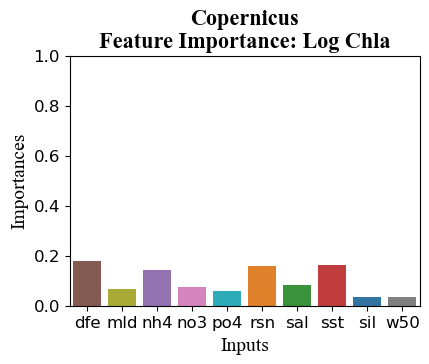

In [58]:
gini_plot(
    data=feat_chl,
    title="Copernicus\nFeature Importance: Log Chla",
    name="Sentinel_FI_chl_varfill.jpg"
)

#### Feature Importance Diatom

In [59]:
model_diat.feature_importances_

array([0.06355322, 0.02856327, 0.04481732, 0.12909161, 0.10505111,
       0.14429154, 0.0414057 , 0.37601183, 0.05291915, 0.01429525])

In [60]:
feat_diat = pd.DataFrame({"Inputs":X.columns, "Importances":model_diat.feature_importances_})
feat_diat

Inputs  Importances
0    dfe     0.063553
1    mld     0.028563
2    nh4     0.044817
3    no3     0.129092
4    po4     0.105051
5    rsn     0.144292
6    sal     0.041406
7    sst     0.376012
8    sil     0.052919
9    w50     0.014295

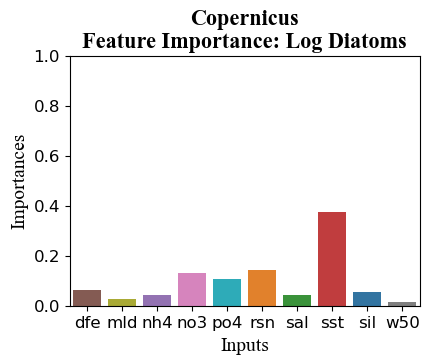

In [61]:
gini_plot(
    data=feat_diat,
    title="Copernicus\nFeature Importance: Log Diatoms",
    name="Sentinel_FI_diat_varfill.jpg"
)

#### Feature Importance Micro

In [62]:
model_mcro.feature_importances_

array([0.08214249, 0.0323624 , 0.05614001, 0.12267079, 0.10105477,
       0.14859042, 0.04528314, 0.34033028, 0.0559545 , 0.01547121])

In [63]:
feat_mcro = pd.DataFrame({"Inputs":X.columns, "Importances":model_mcro.feature_importances_})

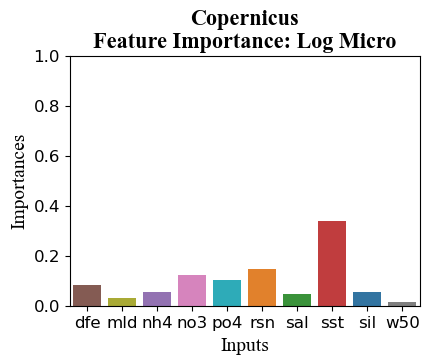

In [64]:
gini_plot(
    data=feat_mcro,
    title="Copernicus\nFeature Importance: Log Micro",
    name="Sentinel_FI_mcro_varfill.jpg"
)

#### Feature Importance Nano

In [65]:
model_nano.feature_importances_

array([0.12821044, 0.05214529, 0.14980032, 0.09365679, 0.05064264,
       0.25863027, 0.07315247, 0.13905258, 0.02887915, 0.02583004])

In [66]:
feat_nano = pd.DataFrame({"Inputs":X.columns, "Importances":model_nano.feature_importances_})

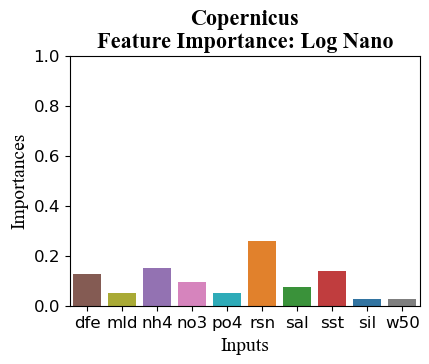

In [67]:
gini_plot(
    data=feat_nano,
    title="Copernicus\nFeature Importance: Log Nano",
    name="Sentinel_FI_nano_varfill.jpg"
)

#### Feature Importance Pico

In [68]:
model_pico.feature_importances_

array([0.09099444, 0.0774852 , 0.05995701, 0.07557878, 0.05217998,
       0.42589006, 0.06495431, 0.09061457, 0.03536907, 0.02697659])

In [69]:
feat_pico = pd.DataFrame({"Inputs":X.columns, "Importances":model_pico.feature_importances_})
feat_pico

Inputs  Importances
0    dfe     0.090994
1    mld     0.077485
2    nh4     0.059957
3    no3     0.075579
4    po4     0.052180
5    rsn     0.425890
6    sal     0.064954
7    sst     0.090615
8    sil     0.035369
9    w50     0.026977

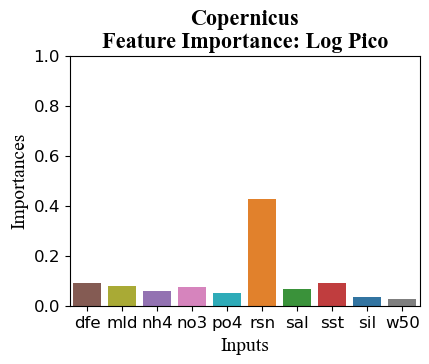

In [70]:
gini_plot(
    data=feat_pico,
    title="Copernicus\nFeature Importance: Log Pico",
    name="Sentinel_FI_pico_varfill.jpg"
)

### Permutation Importance

#### Permutation Importance Chl

In [60]:
from sklearn.inspection import permutation_importance
def perm_plot(data, title, name):
    fig = plt.figure(figsize=(3.5,2.5),dpi=100)
    ax = fig.add_axes([0,0,1,1])
    sns.barplot(x=data.index,y='NormRMSE',data=data,ax=ax, palette=my_colors)
    font = {'family':'Times New Roman','color':'black','fontsize':16,'fontweight':'bold'}
    fonttxt = {'family':'Times New Roman','color':'black','fontsize':14}
    ax.set_title(title,fontdict=font)
    ax.set_ylabel("Norm RMSE",fontdict=fonttxt)
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("Inputs",fontdict=fonttxt)
    ax.tick_params(axis='both', labelsize=12)
    # fig.savefig(chartpath + name, dpi=200,bbox_inches='tight')
    plt.show()

In [57]:
result = permutation_importance(model_chla, Xs, ychla, n_repeats=30, scoring='neg_mean_squared_error', n_jobs=-1)
chl_series = pd.Series(result['importances_mean'])
# chl_series.to_pickle('pichl.pkl')
# chl_series = pd.read_pickle('pichl.pkl')
indices = chl_series.index
pichl = pd.DataFrame(index=X.columns,data=chl_series.values,columns=['RMSE'])
pichl['NormRMSE'] = pichl['RMSE']/ychla.std()

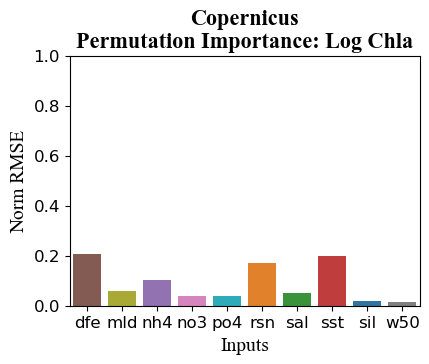

In [58]:
perm_plot(
    data=pichl,
    title='Copernicus\nPermutation Importance: Log Chla',
    name="Sentinel_PI_chl_varfill.jpg"
)    

#### Permutation Importance Diatom

In [75]:
result = permutation_importance(model_diat, Xs, ydiat, n_repeats=30, scoring='neg_mean_squared_error', n_jobs=-1)
diat_series = pd.Series(result['importances_mean'])
# diat_series.to_pickle('pidiat.pkl')
# diat_series = pd.read_pickle('pidiat.pkl')
indices = diat_series.index
pidiat = pd.DataFrame(index=X.columns,data=diat_series.values,columns=['RMSE'])
pidiat['NormRMSE'] = pidiat['RMSE']/ydiat.std()

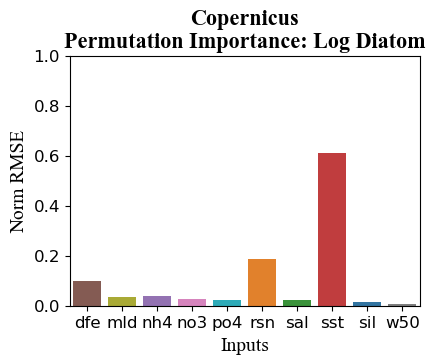

In [76]:
perm_plot(
    data=pidiat,
    title='Copernicus\nPermutation Importance: Log Diatom',
    name="Sentinel_PI_diat_varfill.jpg"
)    

#### Permutation Importance Micro

In [59]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model_mcro, Xs, ymcro, n_repeats=30, scoring='neg_mean_squared_error', n_jobs=-1)
mcro_series = pd.Series(result['importances_mean'])
# mcro_series.to_pickle('pimcro.pkl')
# mcro_series = pd.read_pickle('pimcro.pkl')
indices =mcro_series.index
pimcro = pd.DataFrame(index=X.columns,data=mcro_series.values,columns=['RMSE'])
pimcro['NormRMSE'] = pimcro['RMSE']/ymcro.std()

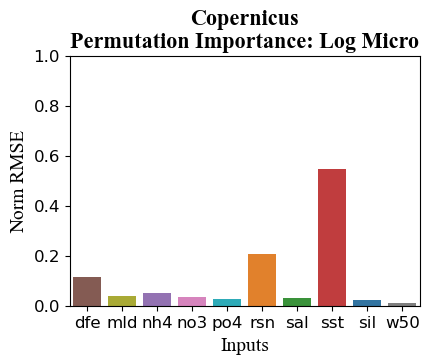

In [61]:
perm_plot(
    data=pimcro,
    title='Copernicus\nPermutation Importance: Log Micro',
    name="Sentinel_PI_mcro_varfill.jpg"
)  

#### Permutation Importance NANO

In [62]:
result = permutation_importance(model_nano, Xs, ynano, n_repeats=30, scoring='neg_mean_squared_error', n_jobs=-1)
nano_series = pd.Series(result['importances_mean'])
# nano_series.to_pickle('pinano.pkl')
# nano_series = pd.read_pickle('pinano.pkl')
pinano = pd.DataFrame(index=X.columns, data=nano_series.values,columns=['RMSE'])
pinano['NormRMSE'] = pinano['RMSE']/ynano.std()

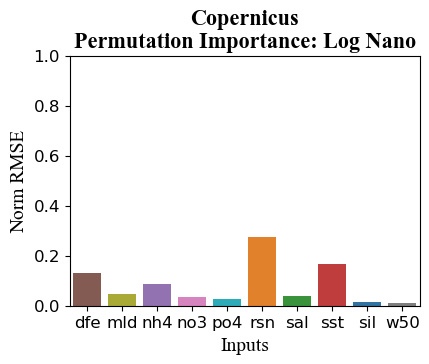

In [63]:
perm_plot(
    data=pinano,
    title='Copernicus\nPermutation Importance: Log Nano',
    name="Sentinel_PI_nano_varfill.jpg"
)    

#### Permutation Importance Pico

In [64]:
result = permutation_importance(model_pico, Xs, ypico, n_repeats=30, scoring='neg_mean_squared_error', n_jobs=-1)
pico_series = pd.Series(result['importances_mean'])
# pico_series.to_pickle('pipico.pkl')
# pico_series = pd.read_pickle('pipico.pkl')
pipico = pd.DataFrame(index=X.columns, data=pico_series.values,columns=['RMSE'])
pipico['NormRMSE'] = pipico['RMSE']/ypico.std()

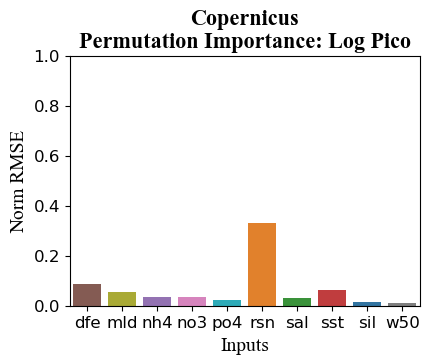

In [65]:
perm_plot(
    data=pipico,
    title='Copernicus\nPermutation Importance: Log Pico',
    name="Sentinel_PI_pico_varfill.jpg"
)    

### Median Sensitivity Analysis

In [34]:
Xs = scaler.transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)
Xs

dfe       mld       nh4       no3       po4       rsn       sal  \
0       0.222673  0.296151  2.155051  6.275951  4.817466  1.284835  8.049155   
1       0.166916  0.554947  5.692934  3.453443  3.940920  5.208974  8.030565   
2       0.169916  0.289347  4.227085  4.754841  5.650364  5.392710  7.986695   
3       1.187439  0.161159  0.730916  0.036021  0.813911  0.960252  6.339882   
4       0.297420  0.198901  0.659485  0.624940  0.824366  5.908251  7.746317   
...          ...       ...       ...       ...       ...       ...       ...   
431107  0.295059  0.113933  0.859573  0.610322  1.458473  4.858561  7.831924   
431108  1.264606  0.167718  0.948492  0.972958  0.080320  0.001144  7.451062   
431109  0.236150  0.111143  1.451263  0.000914  1.180140  6.203190  7.311867   
431110  0.042904  1.133960  0.580474  0.084914  0.968551  4.192012  8.470970   
431111  2.192293  0.117172  0.678568  0.241585  0.712142  6.591209  8.229618   

             sst       sil       w50  
0       0.159482  5.522864  5.088903  
1       3.037363  0.063222  4.998225  
2       0.524895  4.768815  5.005685  
3       0.490399  0.164863  5.072961  
4       5.112332  0.280962  4.964142  
...          ...       ...       ...  
431107  5.477065  0.867900  5.010094  
431108  0.055030  0.150609  5.015424  
431109  8.309030  0.252136  5.067724  
431110  5.953951  0.019085  4.958327  
431111  8.453218  0.282087  4.998678  

[431112 rows x 10 columns]

In [35]:
re_orig={}
r2_orig={}
rn_orig={}

In [36]:
ychla_pred = model_chla.predict(Xs)
re = mean_squared_error(ychla, ychla_pred, squared=False)
rn = re/ychla.std()
r2 = r2_score(ychla, ychla_pred)
re_orig['chla']=re
rn_orig['chla']=rn
r2_orig['chla']=r2

In [37]:
ydiat_pred = model_diat.predict(Xs)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
rn = re/ydiat.std()
r2 = r2_score(ydiat, ydiat_pred)
re_orig['diat']=re
rn_orig['diat']=rn
r2_orig['diat']=r2

In [38]:
ymcro_pred = model_mcro.predict(Xs)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
rn = re/ymcro.std()
r2 = r2_score(ymcro, ymcro_pred)
re_orig['mcro']=re
rn_orig['mcro']=rn
r2_orig['mcro']=r2

In [39]:
ynano_pred = model_nano.predict(Xs)
re = mean_squared_error(ynano, ynano_pred, squared=False)
rn = re/ynano.std()
r2 = r2_score(ynano, ynano_pred)
re_orig['nano']=re
rn_orig['nano']=rn
r2_orig['nano']=r2

In [40]:
ypico_pred = model_pico.predict(Xs)
re = mean_squared_error(ypico, ypico_pred, squared=False)
rn = re/ypico.std()
r2 = r2_score(ypico, ypico_pred)
re_orig['pico']=re
rn_orig['pico']=rn
r2_orig['pico']=r2

In [41]:
re_rsn={}
r2_rsn = {}
rn_rsn = {}

This sensitivity analysis is carried out by keeping the values of one variable at 50th percentile and rest at actual

#### Sensitivity Shortwave Radiation

In [42]:
X5rsn = Xs.copy(deep=True)
for col in X5rsn.columns:
    if col == 'rsn':
        X5rsn[col] = X5rsn[col].quantile(q=0.5, interpolation='linear')
    else:
        X5rsn[col] = X5rsn[col]

In [43]:
X5rsn.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.222673  0.296151  2.155051  6.275951  4.817466  5.437046  8.049155   
1  0.166916  0.554947  5.692934  3.453443  3.940920  5.437046  8.030565   
2  0.169916  0.289347  4.227085  4.754841  5.650364  5.437046  7.986695   
3  1.187439  0.161159  0.730916  0.036021  0.813911  5.437046  6.339882   
4  0.297420  0.198901  0.659485  0.624940  0.824366  5.437046  7.746317   

        sst       sil       w50  
0  0.159482  5.522864  5.088903  
1  3.037363  0.063222  4.998225  
2  0.524895  4.768815  5.005685  
3  0.490399  0.164863  5.072961  
4  5.112332  0.280962  4.964142

In [44]:
ychla_pred = model_chla.predict(X5rsn)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_rsn['chla']=re
r2_rsn['chla']=r2
rn_rsn['chla']=rn

RMSE: 0.3408851759772024
Normalised RMSE: 0.8908120084673913
R2_score: 0.20645212486998965


In [45]:
ydiat_pred = model_diat.predict(X5rsn)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_rsn['diat']=re
r2_rsn['diat']=r2
rn_rsn['diat']=rn

RMSE: 0.6395320087140581
Normalised RMSE: 1.1179151695171214
R2_score: -0.24973722510592222


In [46]:
ymcro_pred = model_mcro.predict(X5rsn)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_rsn['mcro']=re
r2_rsn['mcro']=r2
rn_rsn['mcro']=rn

RMSE: 0.5503399080659294
Normalised RMSE: 1.0910587431857612
R2_score: -0.19041194234270464


In [47]:
ynano_pred = model_nano.predict(X5rsn)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_rsn['nano']=re
r2_rsn['nano']=r2
rn_rsn['nano']=rn

RMSE: 0.43899066031875883
Normalised RMSE: 1.0286160767903765
R2_score: -0.058053487674540216


In [48]:
ypico_pred = model_pico.predict(X5rsn)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score PICO :",r2)
re_rsn['pico']=re
r2_rsn['pico']=r2
rn_rsn['pico']=rn

RMSE: 0.17491270896810937
Normalised RMSE: 0.613170754458316
R2_score PICO : 0.6240207537618185


In [49]:
rn_rsn

{'chla': 0.8908120084673913,
 'diat': 1.1179151695171214,
 'mcro': 1.0910587431857612,
 'nano': 1.0286160767903765,
 'pico': 0.613170754458316}

In [50]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

In [51]:
rn_orig

{'chla': 0.2351560099254379,
 'diat': 0.26863235390738094,
 'mcro': 0.26927469650570773,
 'nano': 0.27350506905475896,
 'pico': 0.27050052925102236}

#### Sensitivity Iron

In [52]:
re_dfe={}
rn_dfe={}
r2_dfe = {}

In [53]:
X5dfe = Xs.copy(deep=True)
for col in X5dfe.columns:
    if col == 'dfe':
        X5dfe[col] = X5dfe[col].quantile(q=0.5, interpolation='linear')
    else:
        X5dfe[col] = X5dfe[col]

In [54]:
X5dfe.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.249283  0.296151  2.155051  6.275951  4.817466  1.284835  8.049155   
1  0.249283  0.554947  5.692934  3.453443  3.940920  5.208974  8.030565   
2  0.249283  0.289347  4.227085  4.754841  5.650364  5.392710  7.986695   
3  0.249283  0.161159  0.730916  0.036021  0.813911  0.960252  6.339882   
4  0.249283  0.198901  0.659485  0.624940  0.824366  5.908251  7.746317   

        sst       sil       w50  
0  0.159482  5.522864  5.088903  
1  3.037363  0.063222  4.998225  
2  0.524895  4.768815  5.005685  
3  0.490399  0.164863  5.072961  
4  5.112332  0.280962  4.964142

In [55]:
ychla_pred = model_chla.predict(X5dfe)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_dfe['chla']=re
r2_dfe['chla']=r2
rn_dfe['chla']=rn

RMSE: 0.22159620599690372
Normalised RMSE: 0.5790822694679374
R2_score: 0.6646629473456765


In [56]:
ydiat_pred = model_diat.predict(X5dfe)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_dfe['diat']=re
r2_dfe['diat']=r2
rn_dfe['diat']=rn

RMSE: 0.23581686169106994
Normalised RMSE: 0.4122127482601687
R2_score: 0.8300802560288213


In [57]:
ymcro_pred = model_mcro.predict(X5dfe)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_dfe['mcro']=re
r2_dfe['mcro']=r2
rn_dfe['mcro']=rn

RMSE: 0.21266135113166926
Normalised RMSE: 0.4216049446701379
R2_score: 0.8222488583209683


In [58]:
ynano_pred = model_nano.predict(X5dfe)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_dfe['nano']=re
r2_dfe['nano']=r2
rn_dfe['nano']=rn

RMSE: 0.2067338973808944
Normalised RMSE: 0.4844062293013503
R2_score: 0.7653500607240306


In [59]:
ypico_pred = model_pico.predict(X5dfe)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score PICO :",r2)
re_dfe['pico']=re
r2_dfe['pico']=r2
rn_dfe['pico']=rn

RMSE: 0.1302032510022144
Normalised RMSE: 0.45643810630426734
R2_score PICO : 0.7916637718601275


In [60]:
rn_dfe

{'chla': 0.5790822694679374,
 'diat': 0.4122127482601687,
 'mcro': 0.4216049446701379,
 'nano': 0.4844062293013503,
 'pico': 0.45643810630426734}

In [61]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

#### Sensitivity SST

In [62]:
re_tos={}
rn_tos={}
r2_tos={}

In [63]:
X5tos = Xs.copy(deep=True)
for col in X5tos.columns:
    if col == 'sst':
        X5tos[col] = X5tos[col].quantile(q=0.5, interpolation='linear')
    else:
        X5tos[col] = X5tos[col]

In [64]:
X5tos.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.222673  0.296151  2.155051  6.275951  4.817466  1.284835  8.049155   
1  0.166916  0.554947  5.692934  3.453443  3.940920  5.208974  8.030565   
2  0.169916  0.289347  4.227085  4.754841  5.650364  5.392710  7.986695   
3  1.187439  0.161159  0.730916  0.036021  0.813911  0.960252  6.339882   
4  0.297420  0.198901  0.659485  0.624940  0.824366  5.908251  7.746317   

        sst       sil       w50  
0  5.569504  5.522864  5.088903  
1  5.569504  0.063222  4.998225  
2  5.569504  4.768815  5.005685  
3  5.569504  0.164863  5.072961  
4  5.569504  0.280962  4.964142

In [65]:
ychla_pred = model_chla.predict(X5tos)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_tos['chla']=re
r2_tos['chla']=r2
rn_tos['chla']=rn

RMSE: 0.2003851170982613
Normalised RMSE: 0.5236527757992432
R2_score: 0.725787134338197


In [66]:
ydiat_pred = model_diat.predict(X5tos)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_tos['diat']=re
r2_tos['diat']=r2
rn_tos['diat']=rn

RMSE: 0.37419619884547783
Normalised RMSE: 0.6541026897248551
R2_score: 0.5721486788579885


In [67]:
ymcro_pred = model_mcro.predict(X5tos)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_tos['mcro']=re
r2_tos['mcro']=r2
rn_tos['mcro']=rn

RMSE: 0.32352971565102273
Normalised RMSE: 0.6414034667810503
R2_score: 0.5886006385258333


In [68]:
ynano_pred = model_nano.predict(X5tos)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_tos['nano']=re
r2_tos['nano']=r2
rn_tos['nano']=rn

RMSE: 0.2353619175128596
Normalised RMSE: 0.5514856558500514
R2_score: 0.6958628659203039


In [69]:
ypico_pred = model_pico.predict(X5tos)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score PICO :",r2)
re_tos['pico']=re
r2_tos['pico']=r2
rn_tos['pico']=rn

RMSE: 0.1890618317096933
Normalised RMSE: 0.662771657203251
R2_score PICO : 0.5607327114909659


In [70]:
rn_tos

{'chla': 0.5236527757992432,
 'diat': 0.6541026897248551,
 'mcro': 0.6414034667810503,
 'nano': 0.5514856558500514,
 'pico': 0.662771657203251}

In [71]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

In [72]:
X.columns

Index(['dfe', 'mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50'], dtype='object')

#### Sensitivity MLD

In [73]:
re_mld={}
rn_mld={}
r2_mld={}

In [74]:
X5mld = Xs.copy(deep=True)
for col in X5mld.columns:
    if col == 'mld':
        X5mld[col] = X5mld[col].quantile(q=0.5, interpolation='linear')
    else:
        X5mld[col] = X5mld[col]

In [75]:
X5mld.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.222673  0.423154  2.155051  6.275951  4.817466  1.284835  8.049155   
1  0.166916  0.423154  5.692934  3.453443  3.940920  5.208974  8.030565   
2  0.169916  0.423154  4.227085  4.754841  5.650364  5.392710  7.986695   
3  1.187439  0.423154  0.730916  0.036021  0.813911  0.960252  6.339882   
4  0.297420  0.423154  0.659485  0.624940  0.824366  5.908251  7.746317   

        sst       sil       w50  
0  0.159482  5.522864  5.088903  
1  3.037363  0.063222  4.998225  
2  0.524895  4.768815  5.005685  
3  0.490399  0.164863  5.072961  
4  5.112332  0.280962  4.964142

In [76]:
ychla_pred = model_chla.predict(X5mld)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_mld['chla']=re
r2_mld['chla']=r2
rn_mld['chla']=rn

RMSE: 0.15902911312206852
Normalised RMSE: 0.415579947878203
R2_score: 0.8272929063130807


In [77]:
ydiat_pred = model_diat.predict(X5mld)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_mld['diat']=re
r2_mld['diat']=r2
rn_mld['diat']=rn

RMSE: 0.21341837201468988
Normalised RMSE: 0.3730597253585528
R2_score: 0.8608261184900086


In [78]:
ymcro_pred = model_mcro.predict(X5mld)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_mld['mcro']=re
r2_mld['mcro']=r2
rn_mld['mcro']=rn

RMSE: 0.19887582090536118
Normalised RMSE: 0.39427488362527696
R2_score: 0.8445469555558643


In [79]:
ynano_pred = model_nano.predict(X5mld)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_mld['nano']=re
r2_mld['nano']=r2
rn_mld['nano']=rn

RMSE: 0.18877878143616408
Normalised RMSE: 0.4423348993373501
R2_score: 0.8043393829771694


In [80]:
ypico_pred = model_pico.predict(X5mld)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score :",r2)
re_mld['pico']=re
r2_mld['pico']=r2
rn_mld['pico']=rn

RMSE: 0.11484026953647061
Normalised RMSE: 0.40258192288767675
R2_score : 0.8379274194232007


In [81]:
rn_mld

{'chla': 0.415579947878203,
 'diat': 0.3730597253585528,
 'mcro': 0.39427488362527696,
 'nano': 0.4423348993373501,
 'pico': 0.40258192288767675}

In [82]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

#### Sensitivity $NH_4$

In [83]:
re_nh4={}
rn_nh4={}
r2_nh4={}

In [84]:
X5nh4 = Xs.copy(deep=True)
for col in X5nh4.columns:
    if col == 'nh4':
        X5nh4[col] = X5nh4[col].quantile(q=0.5, interpolation='linear')
    else:
        X5nh4[col] = X5nh4[col]

In [85]:
X5nh4.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.222673  0.296151  0.920421  6.275951  4.817466  1.284835  8.049155   
1  0.166916  0.554947  0.920421  3.453443  3.940920  5.208974  8.030565   
2  0.169916  0.289347  0.920421  4.754841  5.650364  5.392710  7.986695   
3  1.187439  0.161159  0.920421  0.036021  0.813911  0.960252  6.339882   
4  0.297420  0.198901  0.920421  0.624940  0.824366  5.908251  7.746317   

        sst       sil       w50  
0  0.159482  5.522864  5.088903  
1  3.037363  0.063222  4.998225  
2  0.524895  4.768815  5.005685  
3  0.490399  0.164863  5.072961  
4  5.112332  0.280962  4.964142

In [86]:
ychla_pred = model_chla.predict(X5nh4)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_nh4['chla']=re
r2_nh4['chla']=r2
rn_nh4['chla']=rn

RMSE: 0.17873544853366022
Normalised RMSE: 0.4670771717665955
R2_score: 0.7818384095705627


In [87]:
ydiat_pred = model_diat.predict(X5nh4)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_nh4['diat']=re
r2_nh4['diat']=r2
rn_nh4['diat']=rn

RMSE: 0.22084057268189478
Normalised RMSE: 0.3860338855319466
R2_score: 0.8509774935510108


In [88]:
ymcro_pred = model_mcro.predict(X5nh4)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_nh4['mcro']=re
r2_nh4['mcro']=r2
rn_nh4['mcro']=rn

RMSE: 0.19606729793398536
Normalised RMSE: 0.3887069364376444
R2_score: 0.8489065670913367


In [89]:
ynano_pred = model_nano.predict(X5nh4)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_nh4['nano']=re
r2_nh4['nano']=r2
rn_nh4['nano']=rn

RMSE: 0.18926950990095645
Normalised RMSE: 0.4434847442745011
R2_score: 0.8033208253821046


In [90]:
ypico_pred = model_pico.predict(X5nh4)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score :",r2)
re_nh4['pico']=re
r2_nh4['pico']=r2
rn_nh4['pico']=rn

RMSE: 0.11478514836149521
Normalised RMSE: 0.4023886911171228
R2_score : 0.8380829656809913


In [91]:
rn_nh4

{'chla': 0.4670771717665955,
 'diat': 0.3860338855319466,
 'mcro': 0.3887069364376444,
 'nano': 0.4434847442745011,
 'pico': 0.4023886911171228}

In [92]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

#### Sensitivity $NO_3$

In [93]:
re_no3={}
rn_no3={}
r2_no3={}

In [94]:
X5no3 = Xs.copy(deep=True)
for col in X5no3.columns:
    if col == 'no3':
        X5no3[col] = X5no3[col].quantile(q=0.5, interpolation='linear')
    else:
        X5no3[col] = X5no3[col]

In [95]:
X5no3.head()

dfe       mld       nh4      no3       po4       rsn       sal  \
0  0.222673  0.296151  2.155051  0.29833  4.817466  1.284835  8.049155   
1  0.166916  0.554947  5.692934  0.29833  3.940920  5.208974  8.030565   
2  0.169916  0.289347  4.227085  0.29833  5.650364  5.392710  7.986695   
3  1.187439  0.161159  0.730916  0.29833  0.813911  0.960252  6.339882   
4  0.297420  0.198901  0.659485  0.29833  0.824366  5.908251  7.746317   

        sst       sil       w50  
0  0.159482  5.522864  5.088903  
1  3.037363  0.063222  4.998225  
2  0.524895  4.768815  5.005685  
3  0.490399  0.164863  5.072961  
4  5.112332  0.280962  4.964142

In [96]:
ychla_pred = model_chla.predict(X5no3)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_no3['chla']=re
r2_no3['chla']=r2
rn_no3['chla']=rn

RMSE: 0.13842485283054787
Normalised RMSE: 0.3617362380698834
R2_score: 0.8691465905416811


In [97]:
ydiat_pred = model_diat.predict(X5no3)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_no3['diat']=re
r2_no3['diat']=r2
rn_no3['diat']=rn

RMSE: 0.2033278770046144
Normalised RMSE: 0.3554213315236889
R2_score: 0.8736753840774757


In [98]:
ymcro_pred = model_mcro.predict(X5no3)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_no3['mcro']=re
r2_no3['mcro']=r2
rn_no3['mcro']=rn

RMSE: 0.18214897714216804
Normalised RMSE: 0.3611136157138323
R2_score: 0.869596654064555


In [99]:
ynano_pred = model_nano.predict(X5no3)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_no3['nano']=re
r2_no3['nano']=r2
rn_no3['nano']=rn

RMSE: 0.16224101152399542
Normalised RMSE: 0.38015321931254126
R2_score: 0.8554831946275816


In [100]:
ypico_pred = model_pico.predict(X5no3)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score :",r2)
re_no3['pico']=re
r2_no3['pico']=r2
rn_no3['pico']=rn

RMSE: 0.11932528796849384
Normalised RMSE: 0.4183045204733361
R2_score : 0.8250209222730164


In [101]:
rn_no3

{'chla': 0.3617362380698834,
 'diat': 0.3554213315236889,
 'mcro': 0.3611136157138323,
 'nano': 0.38015321931254126,
 'pico': 0.4183045204733361}

In [102]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

#### Sensitivity $PO_4$

In [103]:
re_po4={}
rn_po4={}
r2_po4={}

In [104]:
X5po4 = Xs.copy(deep=True)
for col in X5po4.columns:
    if col == 'po4':
        X5po4[col] = X5po4[col].quantile(q=0.5, interpolation='linear')
    else:
        X5po4[col] = X5po4[col]

In [105]:
X5po4.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.222673  0.296151  2.155051  6.275951  1.217386  1.284835  8.049155   
1  0.166916  0.554947  5.692934  3.453443  1.217386  5.208974  8.030565   
2  0.169916  0.289347  4.227085  4.754841  1.217386  5.392710  7.986695   
3  1.187439  0.161159  0.730916  0.036021  1.217386  0.960252  6.339882   
4  0.297420  0.198901  0.659485  0.624940  1.217386  5.908251  7.746317   

        sst       sil       w50  
0  0.159482  5.522864  5.088903  
1  3.037363  0.063222  4.998225  
2  0.524895  4.768815  5.005685  
3  0.490399  0.164863  5.072961  
4  5.112332  0.280962  4.964142

In [106]:
ychla_pred = model_chla.predict(X5po4)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_po4['chla']=re
r2_po4['chla']=r2
rn_po4['chla']=rn

RMSE: 0.1435004516026912
Normalised RMSE: 0.3749999545791928
R2_score: 0.8593747078735412


In [107]:
ydiat_pred = model_diat.predict(X5po4)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_po4['diat']=re
r2_po4['diat']=r2
rn_po4['diat']=rn

RMSE: 0.20004495644235376
Normalised RMSE: 0.34968271852720983
R2_score: 0.8777217127287635


In [108]:
ymcro_pred = model_mcro.predict(X5po4)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_po4['mcro']=re
r2_po4['mcro']=r2
rn_po4['mcro']=rn

RMSE: 0.17378037219863907
Normalised RMSE: 0.3445227062448228
R2_score: 0.8813038295559941


In [109]:
ynano_pred = model_nano.predict(X5po4)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_po4['nano']=re
r2_po4['nano']=r2
rn_po4['nano']=rn

RMSE: 0.16168921441383274
Normalised RMSE: 0.37886028205909794
R2_score: 0.8564645537357154


In [110]:
ypico_pred = model_pico.predict(X5po4)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score :",r2)
re_po4['pico']=re
r2_po4['pico']=r2
rn_po4['pico']=rn

RMSE: 0.10912752386534923
Normalised RMSE: 0.3825554274211373
R2_score : 0.8536510054819395


In [111]:
rn_po4

{'chla': 0.3749999545791928,
 'diat': 0.34968271852720983,
 'mcro': 0.3445227062448228,
 'nano': 0.37886028205909794,
 'pico': 0.3825554274211373}

In [112]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

#### Sensitivity Salinity

In [113]:
re_sal={}
rn_sal={}
r2_sal={}

In [114]:
X5sal = Xs.copy(deep=True)
for col in X5sal.columns:
    if col == 'sal':
        X5sal[col] = X5sal[col].quantile(q=0.5, interpolation='linear')
    else:
        X5sal[col] = X5sal[col]

In [115]:
X5sal.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.222673  0.296151  2.155051  6.275951  4.817466  1.284835  8.178022   
1  0.166916  0.554947  5.692934  3.453443  3.940920  5.208974  8.178022   
2  0.169916  0.289347  4.227085  4.754841  5.650364  5.392710  8.178022   
3  1.187439  0.161159  0.730916  0.036021  0.813911  0.960252  8.178022   
4  0.297420  0.198901  0.659485  0.624940  0.824366  5.908251  8.178022   

        sst       sil       w50  
0  0.159482  5.522864  5.088903  
1  3.037363  0.063222  4.998225  
2  0.524895  4.768815  5.005685  
3  0.490399  0.164863  5.072961  
4  5.112332  0.280962  4.964142

In [116]:
ychla_pred = model_chla.predict(X5sal)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_sal['chla']=re
r2_sal['chla']=r2
rn_sal['chla']=rn

RMSE: 0.1426600468532953
Normalised RMSE: 0.3728037820979789
R2_score: 0.8610170176708547


In [117]:
ydiat_pred = model_diat.predict(X5sal)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_sal['diat']=re
r2_sal['diat']=r2
rn_sal['diat']=rn

RMSE: 0.19606621900473925
Normalised RMSE: 0.34272780325099317
R2_score: 0.8825373804144336


In [118]:
ymcro_pred = model_mcro.predict(X5sal)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_sal['mcro']=re
r2_sal['mcro']=r2
rn_sal['mcro']=rn

RMSE: 0.17676060270520175
Normalised RMSE: 0.35043106670212876
R2_score: 0.8771977826399375


In [119]:
ynano_pred = model_nano.predict(X5sal)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_sal['nano']=re
r2_sal['nano']=r2
rn_sal['nano']=rn

RMSE: 0.15511749007262834
Normalised RMSE: 0.36346181935675004
R2_score: 0.8678951994418277


In [120]:
ypico_pred = model_pico.predict(X5sal)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score :",r2)
re_sal['pico']=re
r2_sal['pico']=r2
rn_sal['pico']=rn

RMSE: 0.12247743243017646
Normalised RMSE: 0.429354619743618
R2_score : 0.8156541828993245


In [121]:
rn_sal

{'chla': 0.3728037820979789,
 'diat': 0.34272780325099317,
 'mcro': 0.35043106670212876,
 'nano': 0.36346181935675004,
 'pico': 0.429354619743618}

In [122]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

#### Sensitivity Wo5

In [123]:
re_w50={}
rn_w50={}
r2_w50={}

In [124]:
X5w50 = Xs.copy(deep=True)
for col in X5w50.columns:
    if col == 'w50':
        X5w50[col] = X5w50[col].quantile(q=0.5, interpolation='linear')
    else:
        X5w50[col] = X5w50[col]

In [125]:
X5w50.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.222673  0.296151  2.155051  6.275951  4.817466  1.284835  8.049155   
1  0.166916  0.554947  5.692934  3.453443  3.940920  5.208974  8.030565   
2  0.169916  0.289347  4.227085  4.754841  5.650364  5.392710  7.986695   
3  1.187439  0.161159  0.730916  0.036021  0.813911  0.960252  6.339882   
4  0.297420  0.198901  0.659485  0.624940  0.824366  5.908251  7.746317   

        sst       sil       w50  
0  0.159482  5.522864  4.998476  
1  3.037363  0.063222  4.998476  
2  0.524895  4.768815  4.998476  
3  0.490399  0.164863  4.998476  
4  5.112332  0.280962  4.998476

In [126]:
ychla_pred = model_chla.predict(X5w50)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_w50['chla']=re
r2_w50['chla']=r2
rn_w50['chla']=rn

RMSE: 0.1057703703581152
Normalised RMSE: 0.27640250352615436
R2_score: 0.9236014788317496


In [127]:
ydiat_pred = model_diat.predict(X5w50)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_w50['diat']=re
r2_w50['diat']=r2
rn_w50['diat']=rn

RMSE: 0.16773990845875403
Normalised RMSE: 0.29321282694905154
R2_score: 0.9140260386887923


In [128]:
ymcro_pred = model_mcro.predict(X5w50)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_w50['mcro']=re
r2_w50['mcro']=r2
rn_w50['mcro']=rn

RMSE: 0.14843571270966932
Normalised RMSE: 0.29427646401665836
R2_score: 0.9134011618525645


In [129]:
ynano_pred = model_nano.predict(X5w50)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_w50['nano']=re
r2_w50['nano']=r2
rn_w50['nano']=rn

RMSE: 0.1297127413492256
Normalised RMSE: 0.3039349653122081
R2_score: 0.9076233225852935


In [130]:
ypico_pred = model_pico.predict(X5w50)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score :",r2)
re_w50['pico']=re
r2_w50['pico']=r2
rn_w50['pico']=rn

RMSE: 0.09255387957959514
Normalised RMSE: 0.32445516683531306
R2_score : 0.8947286005280833


In [131]:
rn_w50

{'chla': 0.27640250352615436,
 'diat': 0.29321282694905154,
 'mcro': 0.29427646401665836,
 'nano': 0.3039349653122081,
 'pico': 0.32445516683531306}

In [132]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

#### Sensitivity Sil

In [133]:
re_sil={}
rn_sil={}
r2_sil={}

In [134]:
X5sil = Xs.copy(deep=True)
for col in X5sil.columns:
    if col == 'sil':
        X5sil[col] = X5sil[col].quantile(q=0.5, interpolation='linear')
    else:
        X5sil[col] = X5sil[col]

In [135]:
X5sil.head()

dfe       mld       nh4       no3       po4       rsn       sal  \
0  0.222673  0.296151  2.155051  6.275951  4.817466  1.284835  8.049155   
1  0.166916  0.554947  5.692934  3.453443  3.940920  5.208974  8.030565   
2  0.169916  0.289347  4.227085  4.754841  5.650364  5.392710  7.986695   
3  1.187439  0.161159  0.730916  0.036021  0.813911  0.960252  6.339882   
4  0.297420  0.198901  0.659485  0.624940  0.824366  5.908251  7.746317   

        sst       sil       w50  
0  0.159482  0.230452  5.088903  
1  3.037363  0.230452  4.998225  
2  0.524895  0.230452  5.005685  
3  0.490399  0.230452  5.072961  
4  5.112332  0.230452  4.964142

In [136]:
ychla_pred = model_chla.predict(X5sil)
re = mean_squared_error(ychla,ychla_pred, squared=False)
r2 = r2_score(ychla, ychla_pred)
rn=re/ychla.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_sil['chla']=re
r2_sil['chla']=r2
rn_sil['chla']=rn

RMSE: 0.11293683501490266
Normalised RMSE: 0.2951301374170172
R2_score: 0.9128979999478783


In [137]:
ydiat_pred = model_diat.predict(X5sil)
re = mean_squared_error(ydiat, ydiat_pred, squared=False)
r2 = r2_score(ydiat, ydiat_pred)
rn = re/ydiat.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_sil['diat']=re
r2_sil['diat']=r2
rn_sil['diat']=rn

RMSE: 0.18621892464621992
Normalised RMSE: 0.3255145291816867
R2_score: 0.8940400455086982


In [138]:
ymcro_pred = model_mcro.predict(X5sil)
re = mean_squared_error(ymcro, ymcro_pred, squared=False)
r2 = r2_score(ymcro, ymcro_pred)
rn = re/ymcro.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_sil['mcro']=re
r2_sil['mcro']=r2
rn_sil['mcro']=rn

RMSE: 0.16536536094825932
Normalised RMSE: 0.3278397954397545
R2_score: 0.8925208192190213


In [139]:
ynano_pred = model_nano.predict(X5sil)
re = mean_squared_error(ynano, ynano_pred, squared=False)
r2 = r2_score(ynano, ynano_pred)
rn = re/ynano.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score:",r2)
re_sil['nano']=re
r2_sil['nano']=r2
rn_sil['nano']=rn

RMSE: 0.140555841363526
Normalised RMSE: 0.3293418543536667
R2_score: 0.8915336913742794


In [140]:
ypico_pred = model_pico.predict(X5sil)
re = mean_squared_error(ypico, ypico_pred, squared=False)
r2 = r2_score(ypico, ypico_pred)
rn = re/ypico.std()
print('RMSE:',re)
print("Normalised RMSE:",rn)
print("R2_score :",r2)
re_sil['pico']=re
r2_sil['pico']=r2
rn_sil['pico']=rn

RMSE: 0.09105106794860167
Normalised RMSE: 0.31918693820274974
R2_score : 0.8981194621603543


In [141]:
rn_sil

{'chla': 0.2951301374170172,
 'diat': 0.3255145291816867,
 'mcro': 0.3278397954397545,
 'nano': 0.3293418543536667,
 'pico': 0.31918693820274974}

In [142]:
rn_orig

{'chla': 0.2351560099254379,
 'diat': 0.26863235390738094,
 'mcro': 0.26927469650570773,
 'nano': 0.27350506905475896,
 'pico': 0.27050052925102236}

In [143]:
rnorm_df = pd.DataFrame({'orig':rn_orig,'dfe':rn_dfe, 'mld':rn_mld,'nh4':rn_nh4,'no3':rn_no3,'po4':rn_po4, 'rsn':rn_rsn,
                         'sal':rn_sal,'sst':rn_tos,'sil':rn_sil, 'w50':rn_w50})

In [144]:
rnorm_df

orig       dfe       mld       nh4       no3       po4       rsn  \
chla  0.235156  0.579082  0.415580  0.467077  0.361736  0.375000  0.890812   
diat  0.268632  0.412213  0.373060  0.386034  0.355421  0.349683  1.117915   
mcro  0.269275  0.421605  0.394275  0.388707  0.361114  0.344523  1.091059   
nano  0.273505  0.484406  0.442335  0.443485  0.380153  0.378860  1.028616   
pico  0.270501  0.456438  0.402582  0.402389  0.418305  0.382555  0.613171   

           sal       sst       sil       w50  
chla  0.372804  0.523653  0.295130  0.276403  
diat  0.342728  0.654103  0.325515  0.293213  
mcro  0.350431  0.641403  0.327840  0.294276  
nano  0.363462  0.551486  0.329342  0.303935  
pico  0.429355  0.662772  0.319187  0.324455

In [145]:
rnorm_df = rnorm_df.drop(['orig'], axis=1)
rnorm = rnorm_df.T 

In [146]:
rnorm

chla      diat      mcro      nano      pico
dfe  0.579082  0.412213  0.421605  0.484406  0.456438
mld  0.415580  0.373060  0.394275  0.442335  0.402582
nh4  0.467077  0.386034  0.388707  0.443485  0.402389
no3  0.361736  0.355421  0.361114  0.380153  0.418305
po4  0.375000  0.349683  0.344523  0.378860  0.382555
rsn  0.890812  1.117915  1.091059  1.028616  0.613171
sal  0.372804  0.342728  0.350431  0.363462  0.429355
sst  0.523653  0.654103  0.641403  0.551486  0.662772
sil  0.295130  0.325515  0.327840  0.329342  0.319187
w50  0.276403  0.293213  0.294276  0.303935  0.324455

In [147]:
my_colors={'dfe':brown,'rsn':orange,'sst':red,'nh4':purple,'no3':pink,'mld':olive,
           'sal':green,'w50':gray,'sil':blue, 'po4':cyan}

In [148]:
list(rnorm.index)

['dfe', 'mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50']

In [149]:
rn_orig

{'chla': 0.2351560099254379,
 'diat': 0.26863235390738094,
 'mcro': 0.26927469650570773,
 'nano': 0.27350506905475896,
 'pico': 0.27050052925102236}

In [150]:
rn_test

{'chla': 0.2781979257785008,
 'diat': 0.31707288523837596,
 'mcro': 0.3177612634860792,
 'nano': 0.3251350989520528,
 'pico': 0.31973555889395566}

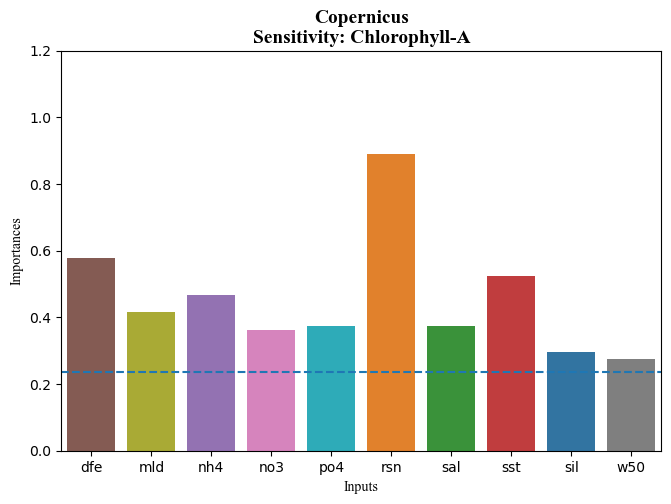

In [151]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
graph = sns.barplot(x=list(rnorm.index),y='chla',data=rnorm, ax=ax, palette=my_colors)
graph.axhline(rn_orig['chla'],ls='--')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Chlorophyll-A", fontdict=font)
ax.set_ylabel("Importances",fontdict=fonttxt)
ax.set_xlabel("Inputs",fontdict=fonttxt)
ax.set_ylim([0.0, 1.2])
plt.show()
fig.savefig(chartpath + "Sentinel_sensbar_chl.jpg",dpi=200,bbox_inches='tight')

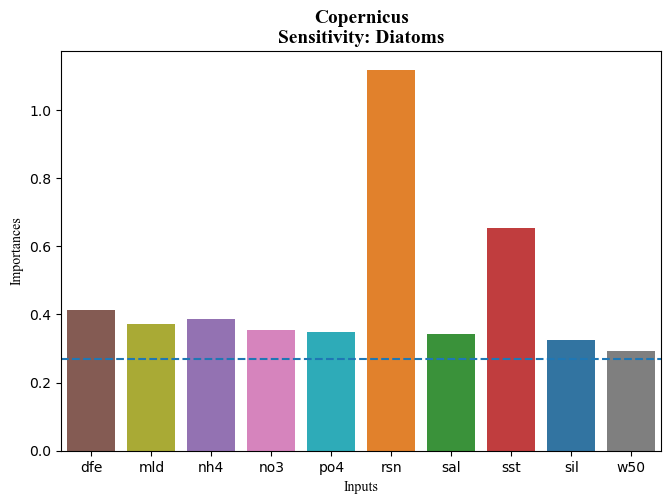

In [152]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
graph = sns.barplot(x=list(rnorm.index), y='diat', data=rnorm, ax=ax, palette=my_colors)
graph.axhline(rn_orig['diat'], ls='--')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Diatoms", fontdict=font)
ax.set_ylabel("Importances",fontdict=fonttxt)
ax.set_xlabel("Inputs",fontdict=fonttxt)
plt.show()
fig.savefig(chartpath + "Sentinel_sensbar_diat.jpg",dpi=200,bbox_inches='tight')

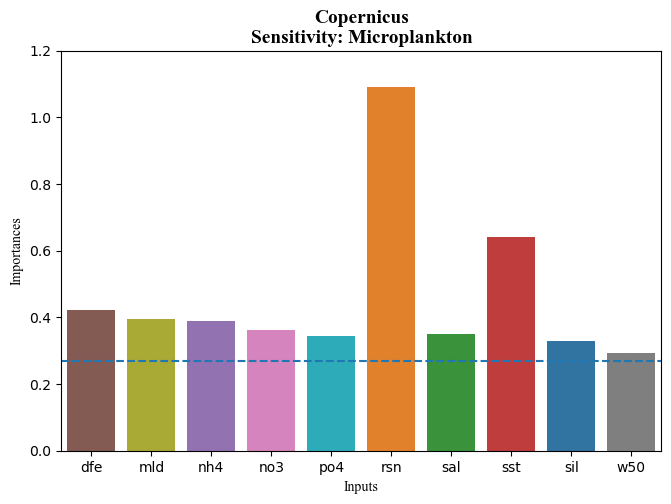

In [153]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
graph = sns.barplot(x=list(rnorm.index),y='mcro',data=rnorm, ax=ax, palette=my_colors)
graph.axhline(rn_orig['mcro'],ls='--')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Microplankton", fontdict=font)
ax.set_ylabel("Importances",fontdict=fonttxt)
ax.set_xlabel("Inputs",fontdict=fonttxt)
ax.set_ylim([0.0, 1.2])
plt.show()
fig.savefig(chartpath + "Sentinel_sensbar_micro.jpg",dpi=200,bbox_inches='tight')

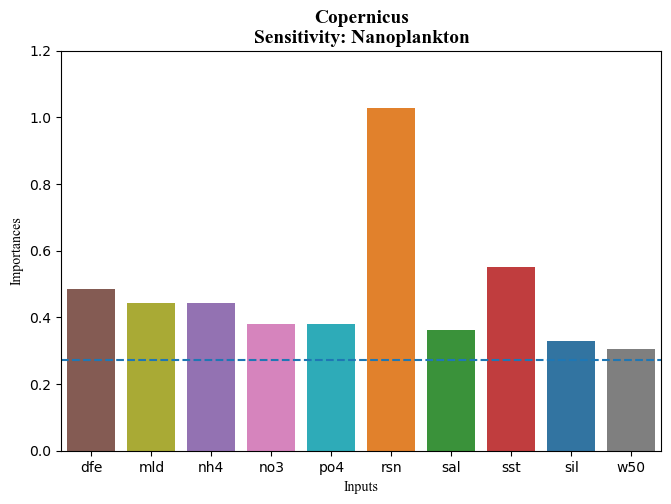

In [154]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
graph = sns.barplot(x=list(rnorm.index),y='nano',data=rnorm, ax=ax, palette=my_colors)
graph.axhline(rn_orig['nano'],ls='--')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Nanoplankton", fontdict=font)
ax.set_ylabel("Importances",fontdict=fonttxt)
ax.set_xlabel("Inputs",fontdict=fonttxt)
ax.set_ylim([0.0, 1.2])
plt.show()
fig.savefig(chartpath + "Sentinel_sensbar_nano.jpg",dpi=200,bbox_inches='tight')

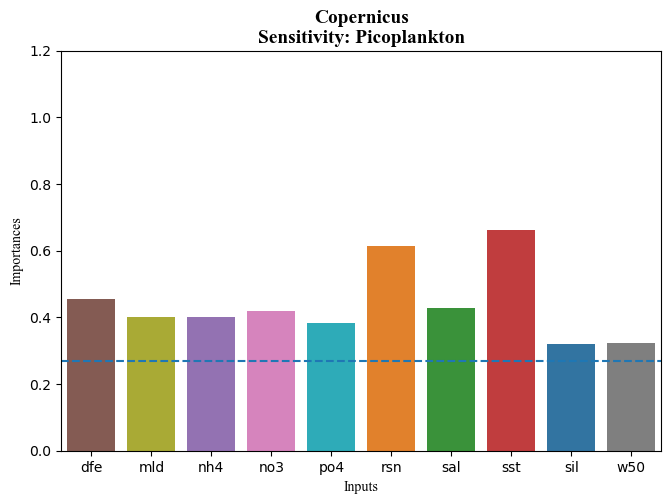

In [155]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
graph = sns.barplot(x=list(rnorm.index), y='pico', data=rnorm, ax=ax, palette=my_colors)
graph.axhline(rn_orig['pico'], ls='--')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Picoplankton", fontdict=font)
ax.set_ylabel("Importances",fontdict=fonttxt)
ax.set_xlabel("Inputs",fontdict=fonttxt)
ax.set_ylim([0.0, 1.2])
plt.show()
fig.savefig(chartpath + "Sentinel_sensbar_pico.jpg",dpi=200,bbox_inches='tight')

### Median Replacement Anomaly

In [53]:
X = X.sort_values(by=['month','lat','lon'])
X.head()

dfe        mld       nh4       no3       po4  \
month lat   lon                                                             
1     -77.5 -178.5  2.679019e-07  77.747002  0.000551  0.016134  0.001235   
            -177.5  2.644416e-07  75.447998  0.000523  0.016679  0.001251   
            -176.5  2.960231e-07  73.435997  0.000496  0.017200  0.001268   
            -175.5  2.617441e-07  71.829002  0.000470  0.017657  0.001283   
            -174.5  3.002942e-07  70.742996  0.000440  0.018044  0.001296   

                           rsn        sal      sst       sil           w50  
month lat   lon                                                             
1     -77.5 -178.5  130.119232  34.274502 -0.25111  0.058165  8.775279e-07  
            -177.5  125.292305  34.261688 -0.30951  0.057787  7.140983e-07  
            -176.5  127.242310  34.249710 -0.36131  0.057461  1.770336e-07  
            -175.5  127.242310  34.238689 -0.40501  0.057123 -5.363125e-07  
            -174.5  121.280769  34.228912 -0.44010  0.056761 -1.706607e-06

In [54]:
Xs = scaler.transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns, index=X.index)
Xs.head()

dfe       mld       nh4       no3       po4  \
month lat   lon                                                        
1     -77.5 -178.5  0.211998  0.506408  4.988966  3.487189  4.077281   
            -177.5  0.208625  0.491433  4.732813  3.605056  4.129741   
            -176.5  0.239415  0.478328  4.488056  3.717607  4.184831   
            -175.5  0.205995  0.467861  4.247550  3.816445  4.234338   
            -174.5  0.243579  0.460787  3.971921  3.899942  4.277099   

                         rsn       sal       sst       sil       w50  
month lat   lon                                                       
1     -77.5 -178.5  4.018076  8.104051  0.468700  4.552131  5.063932  
            -177.5  3.869021  8.100069  0.452159  4.522581  5.054307  
            -176.5  3.929237  8.096346  0.437487  4.497089  5.022678  
            -175.5  3.929237  8.092921  0.425109  4.470600  4.980668  
            -174.5  3.745145  8.089882  0.415171  4.442318  4.911746

In [55]:
data.head()

dfe        mld       nh4       no3       po4  \
month lat   lon                                                             
1     -77.5 -178.5  2.679019e-07  77.747002  0.000551  0.016134  0.001235   
            -177.5  2.644416e-07  75.447998  0.000523  0.016679  0.001251   
            -176.5  2.960231e-07  73.435997  0.000496  0.017200  0.001268   
            -175.5  2.617441e-07  71.829002  0.000470  0.017657  0.001283   
            -174.5  3.002942e-07  70.742996  0.000440  0.018044  0.001296   

                           rsn        sal      sst       sil           w50  \
month lat   lon                                                              
1     -77.5 -178.5  130.119232  34.274502 -0.25111  0.058165  8.775279e-07   
            -177.5  125.292305  34.261688 -0.30951  0.057787  7.140983e-07   
            -176.5  127.242310  34.249710 -0.36131  0.057461  1.770336e-07   
            -175.5  127.242310  34.238689 -0.40501  0.057123 -5.363125e-07   
            -174.5  121.280769  34.228912 -0.44010  0.056761 -1.706607e-06   

                        chla      diat      mcro      nano      pico  \
month lat   lon                                                        
1     -77.5 -178.5  1.161823  4.171545  4.223311  0.136021  0.160340   
            -177.5  1.264481  2.177002  2.258741  0.170274  0.179286   
            -176.5  1.258695  1.213927  1.295848  0.231647  0.176216   
            -175.5  1.233465  1.934669  2.010873  0.156743  0.169910   
            -174.5  1.460254  1.436142  1.521730  0.188898  0.178811   

                     logchla   logdiat   logmcro   lognano   logpico  
month lat   lon                                                       
1     -77.5 -178.5  0.065140  0.620297  0.625653 -0.866395 -0.794957  
            -177.5  0.101912  0.337859  0.353867 -0.768851 -0.746455  
            -176.5  0.099921  0.084192  0.112554 -0.635173 -0.753953  
            -175.5  0.091127  0.286607  0.303385 -0.804812 -0.769782  
            -174.5  0.164428  0.157198  0.182338 -0.723773 -0.747605

In [56]:
data['logchla_pred'] = model_chla.predict(Xs)
data['logdiat_pred'] = model_diat.predict(Xs)
data['logmcro_pred'] = model_mcro.predict(Xs)
data['lognano_pred'] = model_nano.predict(Xs)
data['logpico_pred'] = model_pico.predict(Xs)

In [57]:
def median_dataset(Xs, df, input, q=0.5):
    ''' The function takes a scaled input data and the original unscaled dataset.
    The specified input is replaced by 50th percentile of it's value and the model for the
    particular output is then used to do the prediction on the altered dataset. This is the median prediction.
    This prediction added to the original dataset against the original RF prediction for the respective output
    and coverted to an xarray dataset which is sorted by lat and lon. Returns a dataset with original input, output,
    original RF predictions and median RF prediction for the corressponding input and output'''
    # if isintance(input, str):
    #     pass
    # else:
    #     raise TypeError("Input needs to be a string")
          
    X5 = Xs.copy(deep=True)
    for col in Xs.columns:
        if col==input:
            X5[col] = X5[col].quantile(q, interpolation='linear')
        else:
            X5[col] = X5[col]
    print(X5.head())    
    ds50 = df[['logchla','logchla_pred','logdiat','logdiat_pred','logmcro','logmcro_pred','lognano','lognano_pred','logpico','logpico_pred']].copy(deep=True)
    ds50['logchla_med'] = model_chla.predict(X5)
    ds50['logdiat_med'] = model_diat.predict(X5)
    ds50['logmcro_med'] = model_mcro.predict(X5)
    ds50['lognano_med'] = model_nano.predict(X5)
    ds50['logpico_med'] = model_pico.predict(X5)    
    # print(ds50.head())
    ds5 = ds50.to_xarray()
    ds5 = ds5.sortby(['lat','lon'])
    ds5m= ds5.mean(dim='month')
    return ds5m

In [58]:
def med_sensitivity_plot(ds5m, psc, levels, vmin, vmax, title, plot_name):
    import matplotlib.colors as colors
    from matplotlib.cm import ScalarMappable
    fig = plt.figure(figsize=(5.5,4), dpi=100)
    
    # Set the axes using the specified map projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # choose the data
    anom = (ds5m[psc + '_pred'] - ds5m[psc + '_med'])
    
    # Make a filled contour plot
    cs = ax.contourf(ds5m['lon'], ds5m['lat'],
                     anom, 
                     levels=levels,
                     vmin=vmin,
                     vmax=vmax,
                     transform=ccrs.PlateCarree(), 
                     norm=colors.CenteredNorm(),
                     center=True,
                     # robust=True,
                     cmap='coolwarm', extend='both')
    
    # Add coastlines
    ax.coastlines()
    
    # Define the xticks for longitude
    ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    # lon_formatter = cticker.LongitudeFormatter()
    # ax.xaxis.set_major_formatter(lon_formatter)
    
    # Define the yticks for latitude
    ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    # lat_formatter = cticker.LatitudeFormatter()
    # ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_xlabel("Longitudes", fontsize=12)
    ax.set_ylabel("Latitudes", fontsize=12)
    # Font sizes for tick labels
    ax.tick_params(axis='both', labelsize=12)  # Font size for axis tick labels
    
    #Add Title
    fonttitle = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
    ax.set_title(title, fontdict=fonttitle)
    
    # Add colorbar
    cbar = plt.colorbar(cs, shrink=1.0, orientation='horizontal', pad=0.2)
    cbar.ax.tick_params(labelsize=12)
    
    plt.show()
    fig.savefig(chartpath + plot_name, dpi=500, bbox_inches="tight")

#### Sensitivity Iron

In [62]:
dfe5m = median_dataset(Xs, data, 'dfe')

                         dfe       mld       nh4       no3       po4  \
month lat   lon                                                        
1     -77.5 -178.5  0.249662  0.506408  4.231184  3.487189  4.077281   
            -177.5  0.249662  0.491433  4.013904  3.605056  4.129741   
            -176.5  0.249662  0.478328  3.806290  3.717607  4.184831   
            -175.5  0.249662  0.467861  3.602282  3.816445  4.234338   
            -174.5  0.249662  0.460787  3.368481  3.899942  4.277099   

                         rsn       sal       sst       sil       w50  
month lat   lon                                                       
1     -77.5 -178.5  4.014052  8.057380  0.469185  4.622313  5.170602  
            -177.5  3.865146  8.053420  0.452645  4.592308  5.160775  
            -176.5  3.925302  8.049719  0.437974  4.566423  5.128479  
            -175.5  3.925302  8.046313  0.425598  4.539526  5.085583  
            -174.5  3.741394  8.043292  0.415659  4.510808  5.015210 

In [63]:
dif = (dfe5m['logchla_pred'] - dfe5m['logchla_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.5084112522489874 0.7712054832985243


In [64]:
np.linspace(-0.7,0.7,15)

array([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,
        0.4,  0.5,  0.6,  0.7])

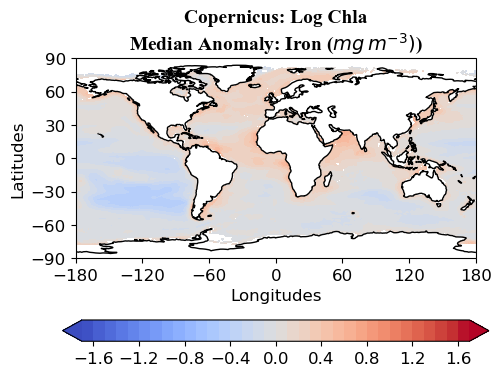

In [65]:
med_sensitivity_plot(
    dfe5m,
    psc='logchla',
    levels=np.linspace(-1.7,1.7,35),
    vmin=-1.7,
    vmax=1.7,
    title ="Copernicus: Log Chla\nMedian Anomaly: Iron (${mg}\,{m^{-3}})$)",
    plot_name="sentinel_medianplot_chla_dfe_varfill.jpg"
)

In [66]:
dif = (dfe5m['logdiat_pred'] - dfe5m['logdiat_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.482424485873977 0.604160829649396


In [67]:
np.linspace(-0.5,0.5,11)

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

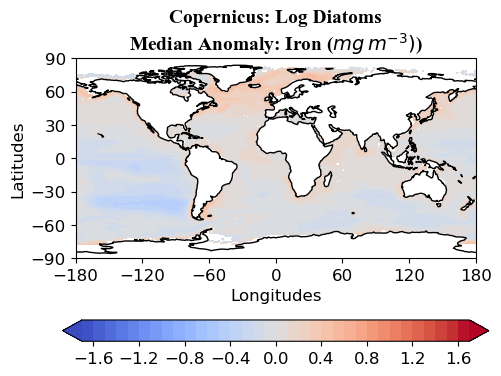

In [68]:
med_sensitivity_plot(
    dfe5m,
    psc='logdiat',
    levels=np.linspace(-1.7,1.7,35),
    vmin=-1.7, vmax=1.7,
    title ="Copernicus: Log Diatoms\nMedian Anomaly: Iron (${mg}\,{m^{-3}})$)",
    plot_name="sentinel_medianplot_diat_dfe_varfill.jpg"
)

In [69]:
dif = (dfe5m['logmcro_pred'] - dfe5m['logmcro_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.47851030971812425 0.576687375436911


In [70]:
np.linspace(-0.4,0.5,10)

array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

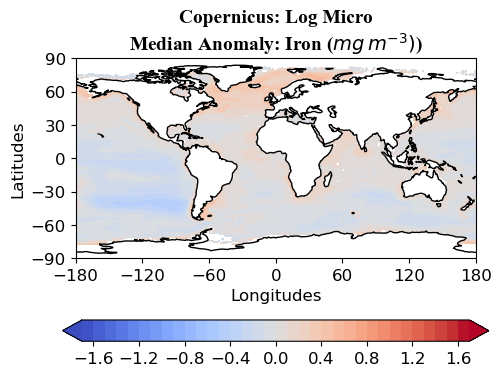

In [74]:
med_sensitivity_plot(
    dfe5m, 
    psc='logmcro', 
    levels=np.linspace(-1.7,1.7,35),
    # levels=np.linspace(-0.5,0.8,14),
    vmin=-1.7, vmax=1.7,
    title ="Copernicus: Log Micro\nMedian Anomaly: Iron (${mg}\,{m^{-3}})$)",
    plot_name="sentinel_medianplot_mcro_dfe_varfill.jpg"
)

In [72]:
dif = (dfe5m['lognano_pred'] - dfe5m['lognano_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.4764970346058499 0.41008779788558325


In [73]:
np.linspace(-0.6,0.5,12)

array([-6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01,  1.11022302e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01])

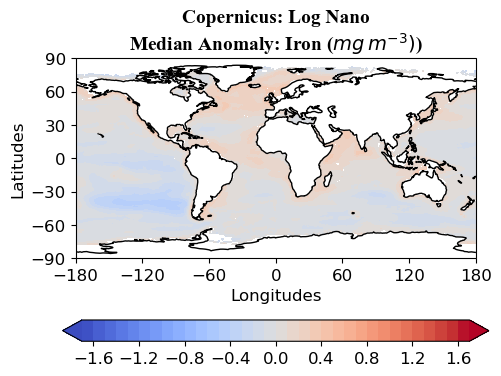

In [75]:
med_sensitivity_plot(
    dfe5m,
    psc='lognano',
    # levels=np.linspace(-2.0,1.0,31),
    levels=np.linspace(-1.7,1.7,35),
    vmin=-1.7, vmax=1.7,
    title ="Copernicus: Log Nano\nMedian Anomaly: Iron (${mg}\,{m^{-3}})$)",
    plot_name="sentinel_medianplot_nano_dfe_varfill.jpg"
)

In [76]:
dif = (dfe5m['logpico_pred'] - dfe5m['logpico_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.367451942244974 0.553537872191757


In [77]:
np.linspace(-0.3,0.4,8)

array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4])

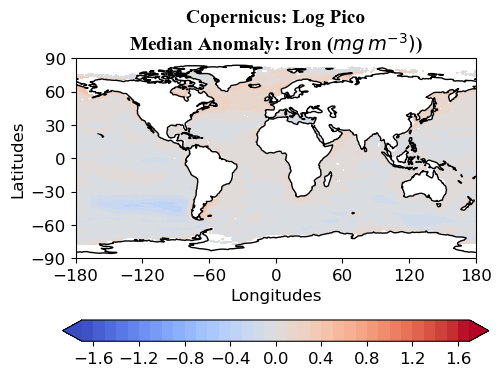

In [78]:
med_sensitivity_plot(
    dfe5m, 
    psc='logpico', 
    # levels=np.linspace(-0.5,0.5,11), 
    levels=np.linspace(-1.7,1.7,35),
    vmin=-1.7, vmax=1.7,
    title ="Copernicus: Log Pico\nMedian Anomaly: Iron (${mg}\,{m^{-3}}$)",
    plot_name="sentinel_medianplot_pico_dfe_varfill.jpg"
)

#### Sensitivity MLD

In [126]:
X5mld = Xs.copy(deep=True)
for col in Xs.columns:
    if col == 'mld':
        X5mld[col] = X5mld[col].quantile(q=0.5, interpolation='linear')
    else:
        X5mld[col] = X5mld[col]

In [127]:
X5mld.head()

dfe        mld        nh4        no3        po4  \
month lat   lon                                                             
10    -37.5  150.5  15.008844  13.645807  28.867710  12.019311  18.827907   
4     -53.5  5.5    11.633307  13.645807  38.169819  53.553576  66.822852   
10    -14.5  156.5  12.671603  13.645807  12.324545  10.000000  19.924829   
2     -10.5  62.5   14.485633  13.645807  10.673739  11.353341  12.157281   
1      71.5 -65.5   16.490300  13.645807  13.173375  12.451536  38.086215   

                          rsn        sal        sst        sil        w50  
month lat   lon                                                            
10    -37.5  150.5  69.636324  86.001599  57.170245  11.009828  61.952106  
4     -53.5  5.5    24.041175  81.253181  19.810633  34.129977  55.860318  
10    -14.5  156.5  82.677239  84.230894  83.797072  10.824963  55.314299  
2     -10.5  62.5   77.603522  83.430255  87.664645  15.828404  59.061981  
1      71.5 -65.5   10.000000  78.190104  10.289056  13.358908  55.148481

In [128]:
mld50 = data[['logchla_pred','logdiat_pred','logmcro_pred','lognano_pred','logpico_pred']].copy(deep=True)
mld50['logchla_med'] = model_chla.predict(X5mld)
mld50['logdiat_med'] = model_diat.predict(X5mld)
mld50['logmcro_med'] = model_mcro.predict(X5mld)
mld50['lognano_med'] = model_nano.predict(X5mld)
mld50['logpico_med'] = model_pico.predict(X5mld)

In [129]:
mld5  = mld50.to_xarray()
mld5m = mld5.mean(dim='month')
mld5m = mld5m.sortby(['lat','lon'])

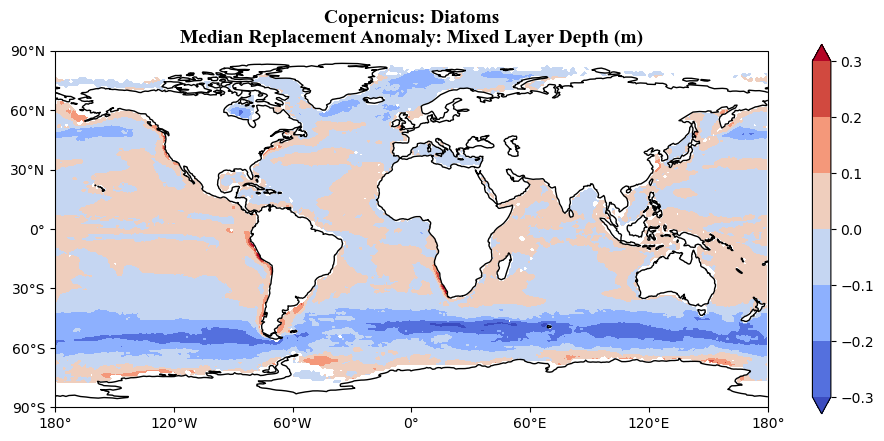

In [130]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(11.5,8), dpi=100)

# Set the axes using the specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# choose the data
anom_diat_mld = (mld5m['logdiat_pred'] - mld5m['logdiat_med'])

# Make a filled contour plot
cs = ax.contourf(mld5m['lon'], mld5m['lat'],anom_diat_mld,
                 transform=ccrs.PlateCarree(), 
                 norm=colors.CenteredNorm(),
                 cmap='coolwarm', extend='both')

# Add coastlines
ax.coastlines()

# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Add Title
fonttitle = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
ax.set_title("Copernicus: Diatoms\nMedian Replacement Anomaly: Mixed Layer Depth (m)", fontdict=fonttitle)

# Add colorbar
cbar = plt.colorbar(cs, shrink=0.6, )
plt.show()
fig.savefig(chartpath + "sentinel_medianplot_diat_mld.jpg", dpi=200, bbox_inches="tight")

#### Sensitivity NH4

In [59]:
X5nh4 = Xs.copy(deep=True)
for col in Xs.columns:
    if col == 'nh4':
        X5nh4[col] = X5nh4[col].quantile(q=0.5, interpolation='linear')
    else:
        X5nh4[col] = X5nh4[col]

In [63]:
nh45m = median_dataset(Xs, data, 'nh4')

                         dfe       mld       nh4       no3       po4  \
month lat   lon                                                        
1     -77.5 -178.5  0.211998  0.506408  0.939591  3.487189  4.077281   
            -177.5  0.208625  0.491433  0.939591  3.605056  4.129741   
            -176.5  0.239415  0.478328  0.939591  3.717607  4.184831   
            -175.5  0.205995  0.467861  0.939591  3.816445  4.234338   
            -174.5  0.243579  0.460787  0.939591  3.899942  4.277099   

                         rsn       sal       sst       sil       w50  
month lat   lon                                                       
1     -77.5 -178.5  4.018076  8.104051  0.468700  4.552131  5.063932  
            -177.5  3.869021  8.100069  0.452159  4.522581  5.054307  
            -176.5  3.929237  8.096346  0.437487  4.497089  5.022678  
            -175.5  3.929237  8.092921  0.425109  4.470600  4.980668  
            -174.5  3.745145  8.089882  0.415171  4.442318  4.911746 

In [64]:
dif = (nh45m['logchla_pred'] - nh45m['logchla_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.4942438821397277 0.32026379256499177


In [64]:
np.linspace(-0.7,0.7,15)

array([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,
        0.4,  0.5,  0.6,  0.7])

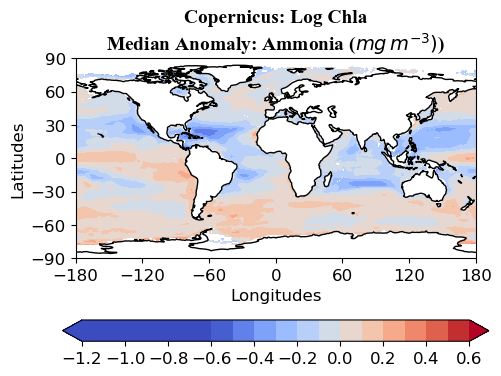

In [65]:
med_sensitivity_plot(
    nh45m,
    psc='logchla',
    levels=np.linspace(-1.2, 0.6, 19),
    vmin=-1.2,
    vmax=0.6,
    title ="Copernicus: Log Chla\nMedian Anomaly: Ammonia (${mg}\,{m^{-3}})$)",
    plot_name="sentinel_medianplot_chla_nh4_varfill.jpg"
)

In [66]:
dif = (nh45m['logdiat_pred'] - nh45m['logdiat_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.3448367917328379 0.27190582408846886


In [67]:
np.linspace(-0.5,0.5,11)

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

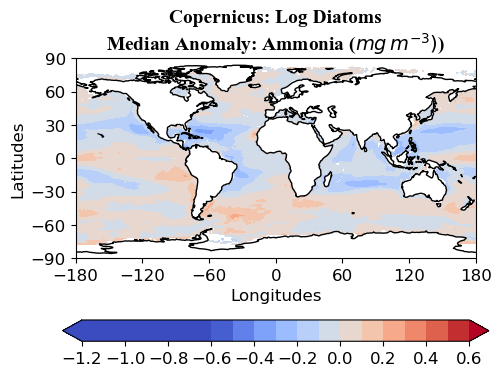

In [67]:
med_sensitivity_plot(
    nh45m,
    psc='logdiat',
    levels=np.linspace(-1.2, 0.6, 19),
    vmin=-1.2,
    vmax=0.6,
    title ="Copernicus: Log Diatoms\nMedian Anomaly: Ammonia (${mg}\,{m^{-3}})$)",
    plot_name="sentinel_medianplot_diat_nh4_varfill.jpg"
)

In [68]:
dif = (nh45m['logmcro_pred'] - nh45m['logmcro_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.38874553720730454 0.25400316787593785


In [72]:
np.linspace(-0.4,0.5,10)

array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

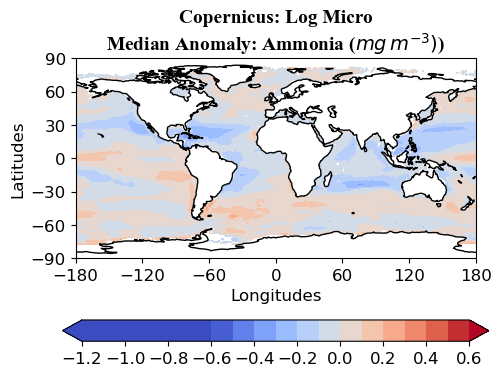

In [69]:
med_sensitivity_plot(
    nh45m, 
    psc='logmcro', 
    levels=np.linspace(-1.2, 0.6, 19),
    vmin=-1.2,
    vmax=0.6,
    title ="Copernicus: Log Micro\nMedian Anomaly: Ammonia (${mg}\,{m^{-3}})$)",
    plot_name="sentinel_medianplot_mcro_nh4_varfill.jpg"
)

In [70]:
dif = (nh45m['lognano_pred'] - nh45m['lognano_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.32552553210733803 0.3083442420424718


In [73]:
np.linspace(-0.6,0.5,12)

array([-6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01,  1.11022302e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01])

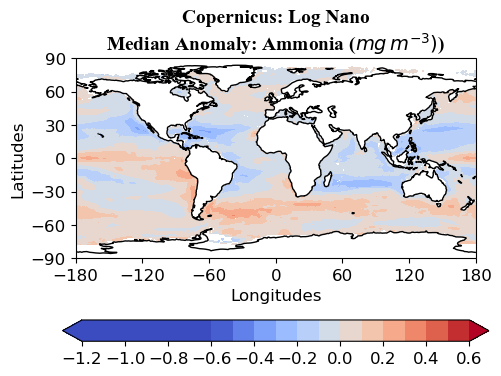

In [71]:
med_sensitivity_plot(
    nh45m,
    psc='lognano',
    levels=np.linspace(-1.2, 0.6, 19),
    vmin=-1.2,
    vmax=0.6,
    title ="Copernicus: Log Nano\nMedian Anomaly: Ammonia (${mg}\,{m^{-3}})$)",
    plot_name="sentinel_medianplot_nano_nh4_varfill.jpg"
)

In [72]:
dif = (nh45m['logpico_pred'] - nh45m['logpico_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.21581782599731625 0.20530673172988712


In [77]:
np.linspace(-0.3,0.4,8)

array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4])

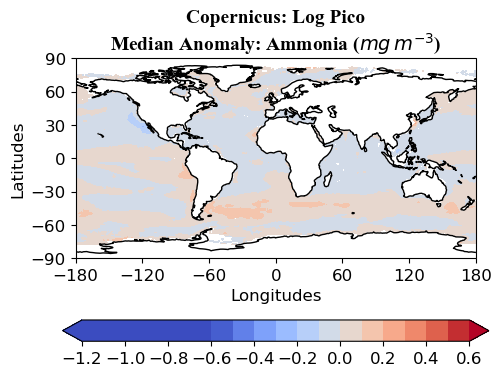

In [73]:
med_sensitivity_plot(
    nh45m, 
    psc='logpico', 
    levels=np.linspace(-1.2, 0.6, 19),
    vmin=-1.2,
    vmax=0.6,
    title ="Copernicus: Log Pico\nMedian Anomaly: Ammonia (${mg}\,{m^{-3}}$)",
    plot_name="sentinel_medianplot_pico_nh4_varfill.jpg"
)

#### Sensitivity NO3

In [82]:
X5no3 = Xs.copy(deep=True)
for col in Xs.columns:
    if col == 'no3':
        X5no3[col] = X5no3[col].quantile(q=0.5, interpolation='linear')
    else:
        X5no3[col] = X5no3[col]

In [83]:
X5no3.head()

dfe        mld        nh4        no3        po4  \
month lat   lon                                                            
6     -47.5 -15.5  11.905943  16.794384  24.103875  12.713263  47.233411   
12    -24.5 -83.5  10.129107  12.302606  22.064143  12.713263  18.638509   
      -10.5  57.5  14.189176  11.839259  12.848775  12.713263  18.397739   
1     -44.5  7.5   11.786307  13.423044  52.559174  12.713263  39.216809   
      -35.5 -20.5  11.432630  11.775713  30.128630  12.713263  17.752360   

                         rsn        sal        sst        sil        w50  
month lat   lon                                                           
6     -47.5 -15.5  17.457342  81.680961  28.995257  13.527115  56.264801  
12    -24.5 -83.5  84.614950  84.534614  64.397369  11.459916  55.165575  
      -10.5  57.5  82.726213  84.525406  87.707940  11.135672  57.394774  
1     -44.5  7.5   66.249231  81.876256  36.874327  11.662270  55.418349  
      -35.5 -20.5  79.623061  85.351897  65.187827  10.860648  54.936801

In [84]:
no350 = data[['logchla_pred','logdiat_pred','logmcro_pred','lognano_pred','logpico_pred']].copy(deep=True)
no350['logchla_med'] = model_chla.predict(X5no3)
no350['logdiat_med'] = model_diat.predict(X5no3)
no350['logmcro_med'] = model_mcro.predict(X5no3)
no350['lognano_med'] = model_nano.predict(X5no3)
no350['logpico_med'] = model_pico.predict(X5no3)

In [85]:
no35  = no350.to_xarray()
no35m = no35.mean(dim='month')
no35m = no35m.sortby(['lat','lon'])

In [86]:
n = anom_diat_no3 = (no35m['logdiat_pred'] - no35m['logdiat_med']).to_numpy()
print(n[~np.isnan(n)].min(), n[~np.isnan(n)].max())

-0.30494076215683563 0.21706707865352148


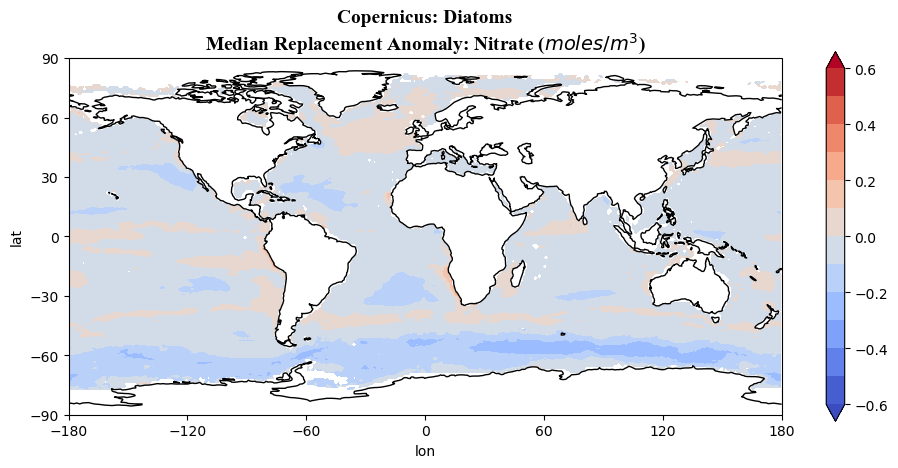

In [90]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(11.5,8), dpi=100)

# Set the axes using the specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# choose the data
anom_diat_no3 = (no35m['logdiat_pred'] - no35m['logdiat_med'])

# Make a filled contour plot
cs = ax.contourf(
    no35m['lon'], 
    no35m['lat'],
    anom_diat_no3,
    vmin=-0.6,vmax=0.6,
    levels=np.linspace(-0.6,0.6,13),
    transform=ccrs.PlateCarree(),
    norm=colors.CenteredNorm(),
    center=True,
    cmap='coolwarm',
    extend='both'
                )

# Add coastlines
ax.coastlines()

# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
# lat_formatter = cticker.LatitudeFormatter()
# ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlabel("lon")
ax.set_ylabel("lat")

#Add Title
fonttitle = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
ax.set_title("Copernicus: Diatoms\nMedian Replacement Anomaly: Nitrate ($moles/m^3$)", fontdict=fonttitle)

# Add colorbar
cbar = plt.colorbar(cs, shrink=0.6, )
plt.show()
fig.savefig(chartpath + "sentinel_medianplot_diat_no3.jpg", dpi=200, bbox_inches="tight")

#### Sensitivity PO4

#### Sensitivity SW Radiation

In [79]:
X5rsn = Xs.copy(deep=True)
for col in Xs.columns:
    if col == 'rsn':
        X5rsn[col] = X5rsn[col].quantile(q=0.5, interpolation='linear')
    else:
        X5rsn[col] = X5rsn[col]

In [80]:
X5rsn.head()

dfe       mld       nh4       no3       po4  \
month lat   lon                                                        
1     -77.5 -178.5  0.208484  0.506408  4.231184  3.487189  4.077281   
            -177.5  0.205167  0.491433  4.013904  3.605056  4.129741   
            -176.5  0.235446  0.478328  3.806290  3.717607  4.184831   
            -175.5  0.202580  0.467861  3.602282  3.816445  4.234338   
            -174.5  0.239541  0.460787  3.368481  3.899942  4.277099   

                         rsn       sal       sst       sil       w50  
month lat   lon                                                       
1     -77.5 -178.5  5.435481  8.057380  0.469185  4.622313  5.170602  
            -177.5  5.435481  8.053420  0.452645  4.592308  5.160775  
            -176.5  5.435481  8.049719  0.437974  4.566423  5.128479  
            -175.5  5.435481  8.046313  0.425598  4.539526  5.085583  
            -174.5  5.435481  8.043292  0.415659  4.510808  5.015210

In [81]:
data.head()

dfe        mld       nh4       no3       po4  \
month lat   lon                                                             
1     -77.5 -178.5  2.679019e-07  77.747002  0.000551  0.016134  0.001235   
            -177.5  2.644416e-07  75.447998  0.000523  0.016679  0.001251   
            -176.5  2.960231e-07  73.435997  0.000496  0.017200  0.001268   
            -175.5  2.617441e-07  71.829002  0.000470  0.017657  0.001283   
            -174.5  3.002942e-07  70.742996  0.000440  0.018044  0.001296   

                           rsn        sal      sst       sil           w50  \
month lat   lon                                                              
1     -77.5 -178.5  130.119232  34.274502 -0.25111  0.058165  8.775279e-07   
            -177.5  125.292305  34.261688 -0.30951  0.057787  7.140983e-07   
            -176.5  127.242310  34.249710 -0.36131  0.057461  1.770336e-07   
            -175.5  127.242310  34.238689 -0.40501  0.057123 -5.363125e-07   
            -174.5  121.280769  34.228912 -0.44010  0.056761 -1.706607e-06   

                    ...   logchla   logdiat   logmcro   lognano   logpico  \
month lat   lon     ...                                                     
1     -77.5 -178.5  ...  0.065140  0.620297  0.625653 -0.866395 -0.794957   
            -177.5  ...  0.101912  0.337859  0.353867 -0.768851 -0.746455   
            -176.5  ...  0.099921  0.084192  0.112554 -0.635173 -0.753953   
            -175.5  ...  0.091127  0.286607  0.303385 -0.804812 -0.769782   
            -174.5  ...  0.164428  0.157198  0.182338 -0.723773 -0.747605   

                    logchla_pred  logdiat_pred  logmcro_pred  lognano_pred  \
month lat   lon                                                              
1     -77.5 -178.5      0.045963      0.133714      0.114332     -0.817997   
            -177.5      0.048317      0.070693      0.097555     -0.847584   
            -176.5      0.090696      0.135934      0.111162     -0.787900   
            -175.5      0.095510      0.017126      0.092227     -0.806638   
            -174.5      0.124835      0.168748      0.157398     -0.760496   

                    logpico_pred  
month lat   lon                   
1     -77.5 -178.5     -0.815539  
            -177.5     -0.810027  
            -176.5     -0.790916  
            -175.5     -0.798722  
            -174.5     -0.754541  

[5 rows x 25 columns]

In [82]:
# drsn50 = data[['logchla_pred']]
# drsn50['logchla_med'] = model_chla.predict(X5rsn)
# ds_rsn50 = drsn50.to_xarray()
# ds_rsn50 = ds_rsn50.sortby(['lat','lon'])
# dsm_rsn50 = ds_rsn50.mean(dim='month')

In [83]:
# diff_rsn = (dsm_rsn50['logchla_pred'] - dsm_rsn50['logchla_med']).to_numpy()
# diff_rsn = diff_rsn[~np.isnan(diff_rsn)]
# print(diff_rsn.min(), diff_rsn.max())

In [84]:
# anom_chla = (dsm_rsn50['logchla_pred'] - dsm_rsn50['logchla_med'])

In [85]:
# anom_chla.plot()

In [86]:
rsn5m = median_dataset(Xs, data, 'rsn')

                         dfe       mld       nh4       no3       po4  \
month lat   lon                                                        
1     -77.5 -178.5  0.208484  0.506408  4.231184  3.487189  4.077281   
            -177.5  0.205167  0.491433  4.013904  3.605056  4.129741   
            -176.5  0.235446  0.478328  3.806290  3.717607  4.184831   
            -175.5  0.202580  0.467861  3.602282  3.816445  4.234338   
            -174.5  0.239541  0.460787  3.368481  3.899942  4.277099   

                         rsn       sal       sst       sil       w50  
month lat   lon                                                       
1     -77.5 -178.5  5.435481  8.057380  0.469185  4.622313  5.170602  
            -177.5  5.435481  8.053420  0.452645  4.592308  5.160775  
            -176.5  5.435481  8.049719  0.437974  4.566423  5.128479  
            -175.5  5.435481  8.046313  0.425598  4.539526  5.085583  
            -174.5  5.435481  8.043292  0.415659  4.510808  5.015210 

In [87]:
dif = (rsn5m['logdiat_pred'] - rsn5m['logdiat_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-1.0682131211197168 0.2081402917705789


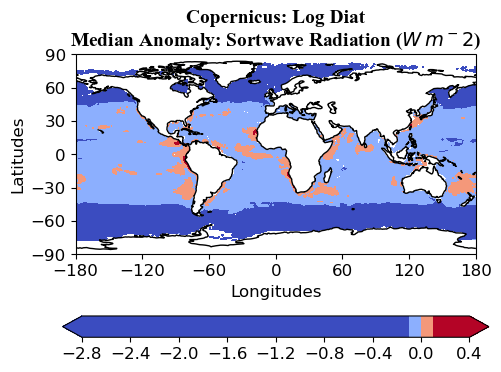

In [88]:
med_sensitivity_plot(
    rsn5m,
    psc='logdiat',
    levels=np.linspace(-2.8,0.4,33),
    vmin=-0.6, vmax=0.1,
    title ="Copernicus: Log Diat\nMedian Anomaly: Sortwave Radiation (${W}\,{m^-{2}}$)",
    plot_name="sentinel_medianplot_diat_rsn_varfill.jpg"
)

In [119]:
# import matplotlib.colors as colors
# fig = plt.figure(figsize=(11.5,8), dpi=100)

# # Set the axes using the specified map projection
# ax = plt.axes(projection=ccrs.PlateCarree())

# # choose the data
# anom_diat_rsn = (rsn5m['logdiat_pred'] - rsn5m['logdiat_med'])

# # Make a filled contour plot
# cs = ax.contourf(rsn5m['lon'], rsn5m['lat'],anom_diat_rsn, 
#                  transform=ccrs.PlateCarree(), 
#                  norm=colors.CenteredNorm(),
#                  cmap='coolwarm', extend='both')

# # Add coastlines
# ax.coastlines()

# # Define the xticks for longitude
# ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)

# # Define the yticks for latitude
# ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
# lat_formatter = cticker.LatitudeFormatter()
# ax.yaxis.set_major_formatter(lat_formatter)

# #Add Title
# fonttitle = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
# ax.set_title("Copernicus: Diatoms\nMedian Replacement Anomaly: Shortwave Radiation ($W/m^2$)", fontdict=fonttitle)

# # Add colorbar
# cbar = plt.colorbar(cs, shrink=0.6)
# plt.show()
# fig.savefig(chartpath + "sentinel_medianplot_diat_rsn.jpg", dpi=200, bbox_inches="tight")

In [89]:
dif = (rsn5m['logchla_pred'] - rsn5m['logchla_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-1.109183279890833 0.15418294191503878


In [90]:
np.linspace(-1.3,0.2,16)

array([-1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3,
       -0.2, -0.1,  0. ,  0.1,  0.2])

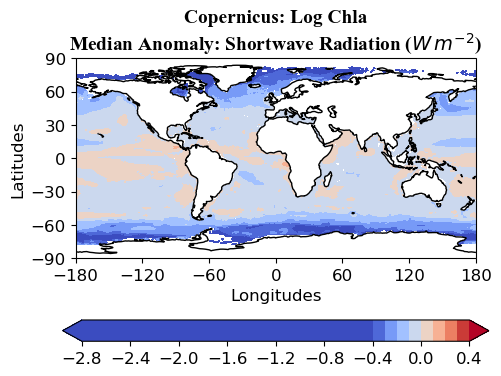

In [93]:
med_sensitivity_plot(
    rsn5m,
    psc='logchla',
    levels=np.linspace(-2.8,0.4,33),
    vmin=-2.8, vmax=0.4,
    title ="Copernicus: Log Chla\nMedian Anomaly: Shortwave Radiation (${W}\,{m^{-2}}$)",
    plot_name="sentinel_medianplot_chla_rsn_varfill.jpg"
)

In [94]:
dif = (rsn5m['logmcro_pred'] - rsn5m['logmcro_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-1.0836307512669434 0.21566441387368102


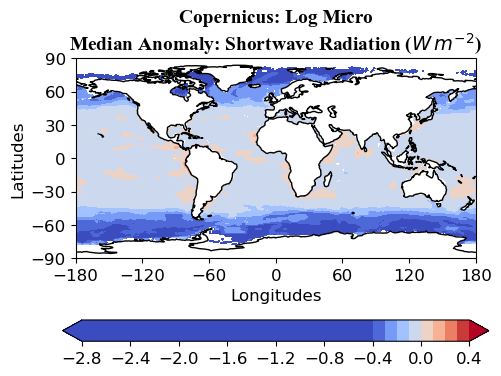

In [95]:
med_sensitivity_plot(
    rsn5m,
    psc='logmcro',
    # levels=np.linspace(-2.7,0.3,31),
    levels=np.linspace(-2.8,0.4,33),
    vmin=-2.8, vmax=0.4,
    title ="Copernicus: Log Micro\nMedian Anomaly: Shortwave Radiation (${W}\,{m^{-2}}$)",
    plot_name="sentinel_medianplot_mcro_rsn_varfill.jpg"
)

In [96]:
dif = (rsn5m['lognano_pred'] - rsn5m['lognano_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-1.0609393717909053 0.1049047451161067


In [97]:
np.linspace(-1.1,0.2,14)

array([-1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,
        0. ,  0.1,  0.2])

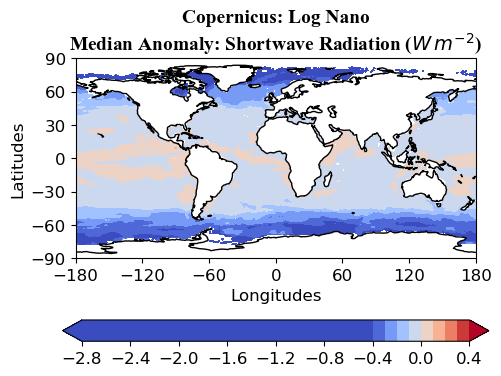

In [98]:
med_sensitivity_plot(
    rsn5m,
    psc='lognano',
    # levels=np.linspace(-1.8,0.2,21),
    levels=np.linspace(-2.8,0.4,33),
    vmin=-2.8, vmax=0.4,
    title ="Copernicus: Log Nano\nMedian Anomaly: Shortwave Radiation (${W}\,{m^{-2}}$)",
    plot_name="sentinel_medianplot_nano_rsn_varfill.jpg"
)

In [99]:
dif = (rsn5m['logpico_pred'] - rsn5m['logpico_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.9869090440091312 0.10901271837690785


In [100]:
np.linspace(-0.4,0.2,7)

array([-4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        5.55111512e-17,  1.00000000e-01,  2.00000000e-01])

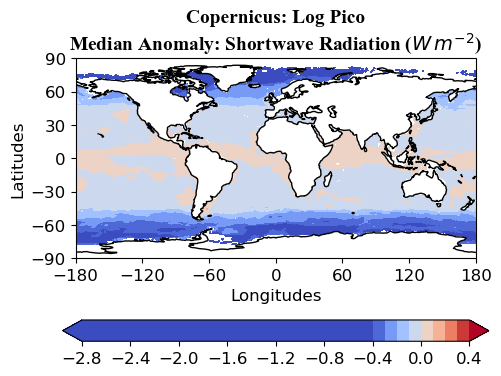

In [101]:
med_sensitivity_plot(
    rsn5m, 
    psc='logpico',
    # levels=np.linspace(-0.9, 0.1, 11),
    levels=np.linspace(-2.8,0.4,33),
    vmin=-2.8, vmax=0.4,
    title ="Copernicus: Log Pico\nMedian Anomaly: Shortwave Radiation (${W}\,{m^{-2}}$)",
    plot_name="sentinel_medianplot_pico_rsn_varfill.jpg"
)

#### Sensitivity Salinity

In [86]:
X5sal = Xs.copy(deep=True)
for col in Xs.columns:
    if col == 'sal':
        X5sal[col] = X5sal[col].quantile(q=0.5, interpolation='linear')
    else:
        X5sal[col] = X5sal[col]

In [87]:
X5sal.head()

dfe        mld        nh4        no3        po4  \
month lat   lon                                                             
8      45.5 -137.5  12.315383  11.206906  11.890021  11.630589  30.843968   
3     -47.5 -152.5  11.225592  13.243837  49.245335  21.637841  32.277028   
6      31.5  136.5  14.899702  11.587361  11.030027  10.315424  12.754962   
9      38.5 -169.5  12.462905  11.609813  12.813787  15.866908  19.604217   
11    -56.5  158.5  11.719763  18.752000  32.870564  49.560867  58.814501   

                          rsn        sal        sst        sil        w50  
month lat   lon                                                            
8      45.5 -137.5  57.738360  83.219224  57.319225  12.039506  56.112434  
3     -47.5 -152.5  46.254617  83.219224  46.996404  13.730865  55.673461  
6      31.5  136.5  64.381391  83.219224  76.670246  13.369558  56.178154  
9      38.5 -169.5  54.954017  83.219224  69.922855  17.039914  56.671212  
11    -56.5  158.5  58.105831  83.219224  22.660084  14.492948  56.152168

In [88]:
sal50 = data[['logchla_pred','logdiat_pred','logmcro_pred','lognano_pred','logpico_pred']].copy(deep=True)
sal50['logchla_med'] = model_chla.predict(X5sal)
sal50['logdiat_med'] = model_diat.predict(X5sal)
sal50['logmcro_med'] = model_mcro.predict(X5sal)
sal50['lognano_med'] = model_nano.predict(X5sal)
sal50['logpico_med'] = model_pico.predict(X5sal)

In [89]:
sal5  = sal50.to_xarray()
sal5m = sal5.mean(dim='month')
sal5m = sal5m.sortby(['lat','lon'])

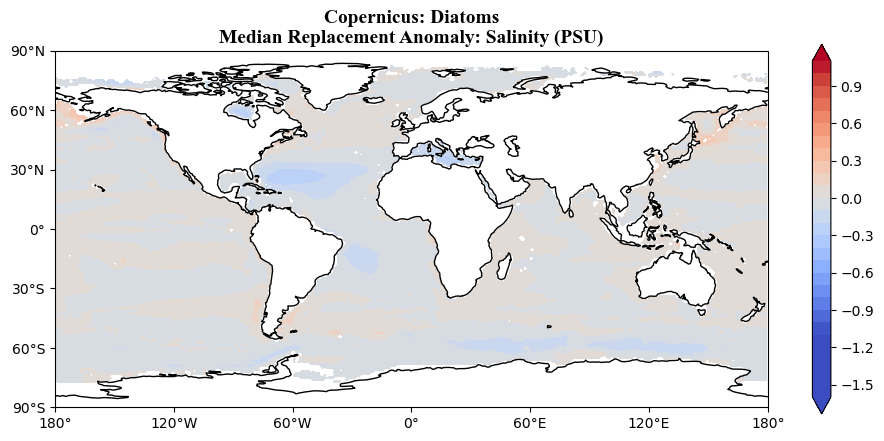

In [90]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(11.5,8), dpi=100)

# Set the axes using the specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# choose the data
anom_diat_sal = (sal5m['logdiat_pred'] - sal5m['logdiat_med'])

# Make a filled contour plot
cs = ax.contourf(sal5m['lon'], sal5m['lat'],anom_diat_sal,levels=np.linspace(-1.6,1.1,28),vmin=-1.6,vmax=1.1,
                 transform=ccrs.PlateCarree(), 
                 norm=colors.CenteredNorm(),
                 cmap='coolwarm', extend='both')

# Add coastlines
ax.coastlines()

# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Add Title
fonttitle = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
ax.set_title("Copernicus: Diatoms\nMedian Replacement Anomaly: Salinity (PSU)", fontdict=fonttitle)

# Add colorbar
cbar = plt.colorbar(cs, shrink=0.6, )
plt.show()
fig.savefig(chartpath + "sentinel_medianplot_diat_sal.jpg", dpi=200, bbox_inches="tight")

#### Sensitivity SST

In [113]:
# X5tos = Xs.copy(deep=True)
# for col in Xs.columns:
#     if col == 'sst':
#         X5tos[col] = X5tos[col].quantile(q=0.5, interpolation='linear')
#     else:
#         X5tos[col] = X5tos[col]

In [115]:
# tos50 = data[['logchla_pred','logdiat_pred','logmcro_pred','lognano_pred','logpico_pred']].copy(deep=True)
# tos50['logchla_med'] = model_chla.predict(X5tos)
# tos50['logdiat_med'] = model_diat.predict(X5tos)
# tos50['logmcro_med'] = model_mcro.predict(X5tos)
# tos50['lognano_med'] = model_nano.predict(X5tos)
# tos50['logpico_med'] = model_pico.predict(X5tos)

In [116]:
# tos5  = tos50.to_xarray()
# tos5m = tos5.mean(dim='month')
# tos5m = tos5m.sortby(['lat','lon'])

In [117]:
# dif = (tos5m['logdiat_pred'] - tos5m['logdiat_med']).to_numpy()
# dif = dif[~np.isnan(dif)]
# print(dif.min(),dif.max())

-0.6962735337146579 0.6656557350604911


In [102]:
tos5m = median_dataset(Xs, data, 'sst')

                         dfe       mld       nh4       no3       po4  \
month lat   lon                                                        
1     -77.5 -178.5  0.208484  0.506408  4.231184  3.487189  4.077281   
            -177.5  0.205167  0.491433  4.013904  3.605056  4.129741   
            -176.5  0.235446  0.478328  3.806290  3.717607  4.184831   
            -175.5  0.202580  0.467861  3.602282  3.816445  4.234338   
            -174.5  0.239541  0.460787  3.368481  3.899942  4.277099   

                         rsn       sal       sst       sil       w50  
month lat   lon                                                       
1     -77.5 -178.5  4.014052  8.057380  5.575508  4.622313  5.170602  
            -177.5  3.865146  8.053420  5.575508  4.592308  5.160775  
            -176.5  3.925302  8.049719  5.575508  4.566423  5.128479  
            -175.5  3.925302  8.046313  5.575508  4.539526  5.085583  
            -174.5  3.741394  8.043292  5.575508  4.510808  5.015210 

In [103]:
dif = (tos5m['logchla_pred'] - tos5m['logchla_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.5421671917928054 0.34533523167411456


In [104]:
np.linspace(-0.5,0.3,9)

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3])

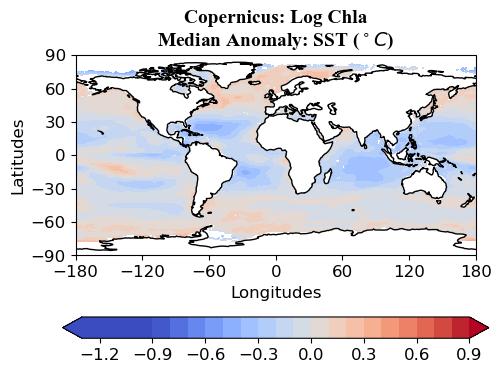

In [105]:
med_sensitivity_plot(
    tos5m,
    psc='logchla',
    # levels=np.linspace(-0.6,0.3,10),
    levels=np.linspace(-1.3,0.9,23),
    vmin=-1.3, vmax=0.9,
    title ="Copernicus: Log Chla\nMedian Anomaly: SST ($^\circ C$)",
    plot_name="sentinel_medianplot_chla_sst_varfill.jpg"
)

In [106]:
dif = (tos5m['logmcro_pred'] - tos5m['logmcro_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.6328466353950881 0.7603697828564235


In [107]:
np.linspace(-0.7,0.7,15)

array([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,
        0.4,  0.5,  0.6,  0.7])

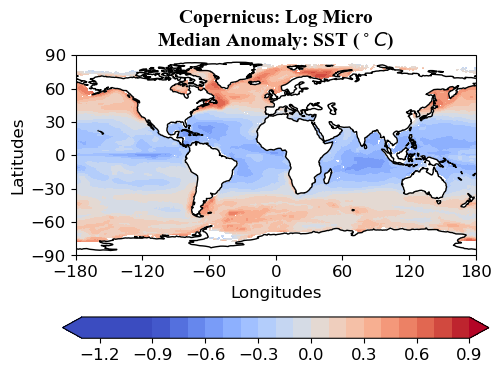

In [108]:
med_sensitivity_plot(
    tos5m,
    psc='logmcro',
    # levels=np.linspace(-1.2,0.6,19),
    levels=np.linspace(-1.3,0.9,23),
    vmin=-1.3, vmax=0.9,
    title ="Copernicus: Log Micro\nMedian Anomaly: SST ($^\circ C$)",
    plot_name="sentinel_medianplot_mcro_sst_varfill.jpg"
)

In [109]:
dif = (tos5m['lognano_pred'] - tos5m['lognano_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.3881620636885321 0.27631928243318893


In [110]:
np.linspace(-0.6,0.5,12)

array([-6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01,  1.11022302e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01])

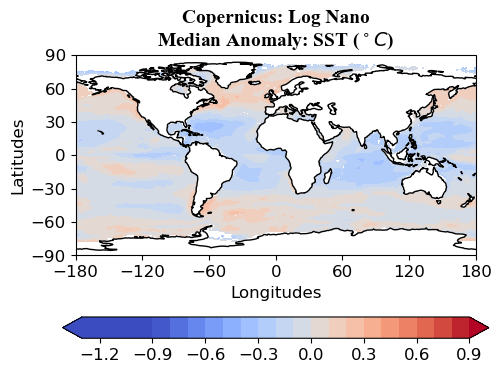

In [111]:
med_sensitivity_plot(
    tos5m, 
    psc='lognano',
    # levels=np.linspace(-0.9, 0.7, 17),
    levels=np.linspace(-1.3,0.9,23),
    vmin=-1.3, vmax=0.9,
    title ="Copernicus: Log Nano\nMedian Anomaly: SST ($^\circ C$)",
    plot_name="sentinel_medianplot_nano_sst_varfill.jpg"
)

In [112]:
dif = (tos5m['logpico_pred'] - tos5m['logpico_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.30061315424408686 0.3058026483890084


In [113]:
np.linspace(-0.3,0.6,10)

array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6])

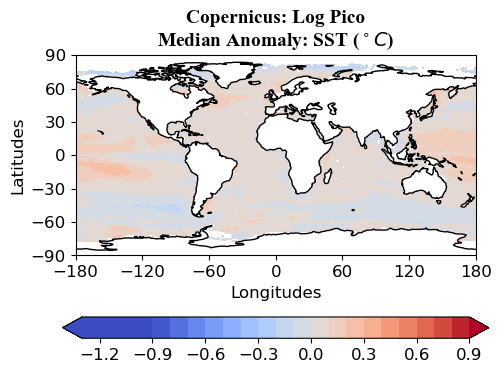

In [114]:
med_sensitivity_plot(
    tos5m,
    psc='logpico', 
    # levels=np.linspace(-0.4, 0.2, 7),
    levels=np.linspace(-1.3,0.9,23),
    vmin=-1.3, vmax=0.9,
    title ="Copernicus: Log Pico\nMedian Anomaly: SST ($^\circ C$)",
    plot_name="sentinel_medianplot_pico_sst_varfill.jpg"
)

#### Sensitivity Silicate

In [103]:
X5sil = Xs.copy(deep=True)
for col in Xs.columns:
    if col == 'sil':
        X5sil[col] = X5sil[col].quantile(q=0.5, interpolation='linear')
    else:
        X5sil[col] = X5sil[col]

In [104]:
X5sil.head()

dfe        mld        nh4        no3        po4  \
month lat   lon                                                             
9     -64.5  31.5   12.591825  23.476918  12.523230  60.036955  63.650849   
6     -67.5  74.5   13.520411  15.769851  14.621468  58.478521  48.632455   
       15.5  170.5  11.083357  13.512736  11.235881  10.318042  13.761112   
1     -19.5  64.5   12.943562  11.980010  10.225280  10.299431  18.475022   
8      32.5 -128.5  12.959646  12.247970  10.205880  10.012525  23.378916   

                          rsn        sal        sst       sil        w50  
month lat   lon                                                           
9     -64.5  31.5   10.000000  82.275295  10.337150  12.07407  57.653212  
6     -67.5  74.5   10.000000  82.476297  14.664258  12.07407  55.871742  
       15.5  170.5  88.069765  83.656209  86.538817  12.07407  55.123465  
1     -19.5  64.5   91.771441  84.622957  84.424643  12.07407  55.748171  
8      32.5 -128.5  66.630759  80.081697  65.565167  12.07407  55.644110

In [105]:
sil50 = data[['logchla_pred','logdiat_pred','logmcro_pred','lognano_pred','logpico_pred']].copy(deep=True)
sil50['logchla_med'] = model_chla.predict(X5sil)
sil50['logdiat_med'] = model_diat.predict(X5sil)
sil50['logmcro_med'] = model_mcro.predict(X5sil)
sil50['lognano_med'] = model_nano.predict(X5sil)
sil50['logpico_med'] = model_pico.predict(X5sil)

In [106]:
sil5  = sil50.to_xarray()
sil5m = sil5.mean(dim='month')
sil5m = sil5m.sortby(['lat','lon'])

In [107]:
dif = (sil5m['logdiat_pred'] - sil5m['logdiat_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.2114946691526114 0.24581951231861054


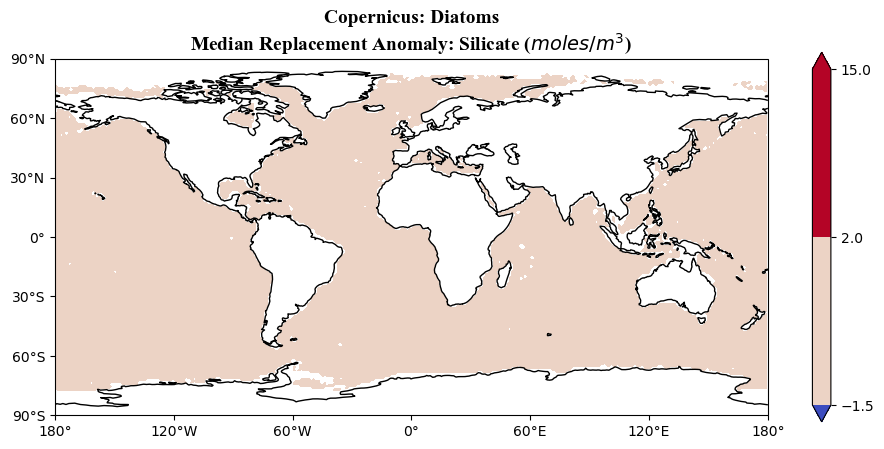

In [108]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(11.5,8), dpi=100)

# Set the axes using the specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# choose the data
anom_diat_sil = (sil5m['logdiat_pred'] - sil5m['logdiat_med'])

# Make a filled contour plot
cs = ax.contourf(sil5m['lon'], sil5m['lat'],anom_diat_sil,levels=(-1.5,2,15),vmin=-1.5,vmax=2,
                 transform=ccrs.PlateCarree(), 
                 norm=colors.CenteredNorm(),
                 cmap='coolwarm', extend='both')

# Add coastlines
ax.coastlines()

# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Add Title
fonttitle = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
ax.set_title("Copernicus: Diatoms\nMedian Replacement Anomaly: Silicate ($moles/m^3$)", fontdict=fonttitle)

# Add colorbar
cbar = plt.colorbar(cs, shrink=0.6)
plt.show()
fig.savefig(chartpath + "sentinel_medianplot_diat_sil.jpg", dpi=200, bbox_inches="tight")

In [109]:
sil5m = median_dataset(Xs, data, 'sil')

                          dfe        mld        nh4        no3        po4  \
month lat   lon                                                             
9     -64.5  31.5   12.591825  23.476918  12.523230  60.036955  63.650849   
6     -67.5  74.5   13.520411  15.769851  14.621468  58.478521  48.632455   
       15.5  170.5  11.083357  13.512736  11.235881  10.318042  13.761112   
1     -19.5  64.5   12.943562  11.980010  10.225280  10.299431  18.475022   
8      32.5 -128.5  12.959646  12.247970  10.205880  10.012525  23.378916   

                          rsn        sal        sst       sil        w50  
month lat   lon                                                           
9     -64.5  31.5   10.000000  82.275295  10.337150  12.07407  57.653212  
6     -67.5  74.5   10.000000  82.476297  14.664258  12.07407  55.871742  
       15.5  170.5  88.069765  83.656209  86.538817  12.07407  55.123465  
1     -19.5  64.5   91.771441  84.622957  84.424643  12.07407  55.748171  
8      32.

In [110]:
dif = (sil5m['logchla_pred'] - sil5m['logchla_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.2024983812931096 0.14941037005738267


In [111]:
np.linspace(-0.3,0.2,6)

array([-3.00000000e-01, -2.00000000e-01, -1.00000000e-01,  5.55111512e-17,
        1.00000000e-01,  2.00000000e-01])

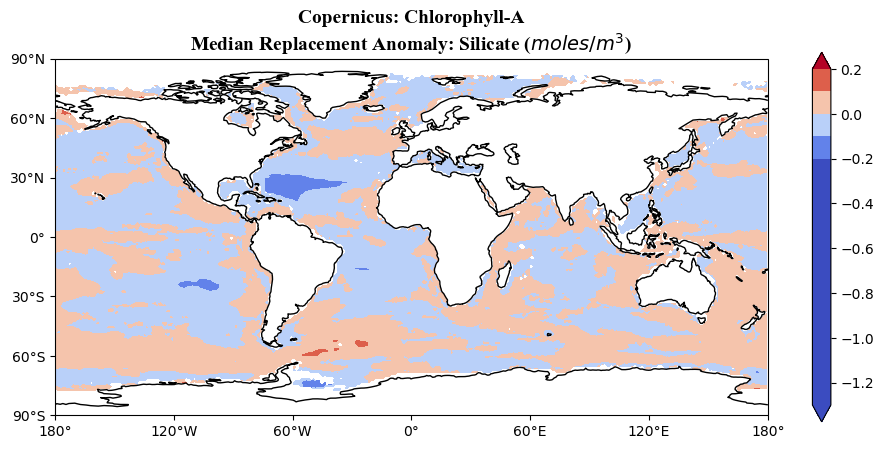

In [120]:
med_sensitivity_plot(sil5m, psc='logchla', levels=np.linspace(-1.3,0.2,16), vmin=-1.3, vmax=0.2,
                     title ="Copernicus: Chlorophyll-A\nMedian Replacement Anomaly: Silicate ($moles/m^3$)",
                     plot_name="sentinel_medianplot_chla_sil.jpg")

In [106]:
dif = (sil5m['logmcro_pred'] - sil5m['logmcro_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.21074916496331908 0.21757810862388172


In [107]:
np.linspace(-0.2,0.3,6)

array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3])

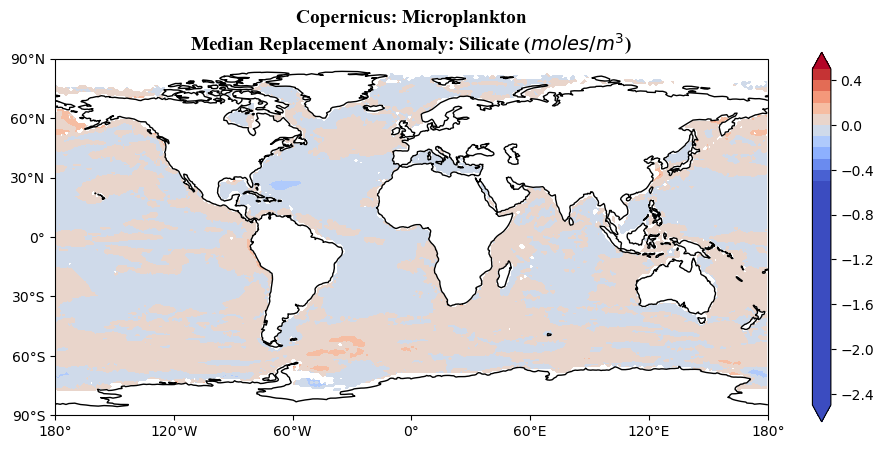

In [112]:
med_sensitivity_plot(sil5m, psc='logmcro', levels=np.linspace(-2.5,0.5,31), vmin=-2.5, vmax=0.5,
                     title ="Copernicus: Microplankton\nMedian Replacement Anomaly: Silicate ($moles/m^3$)",
                     plot_name="sentinel_medianplot_mcro_sil.jpg")

In [113]:
dif = (sil5m['lognano_pred'] - sil5m['lognano_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.13865826595498498 0.18806827869479914


In [114]:
np.linspace(-0.2,0.2,5)

array([-0.2, -0.1,  0. ,  0.1,  0.2])

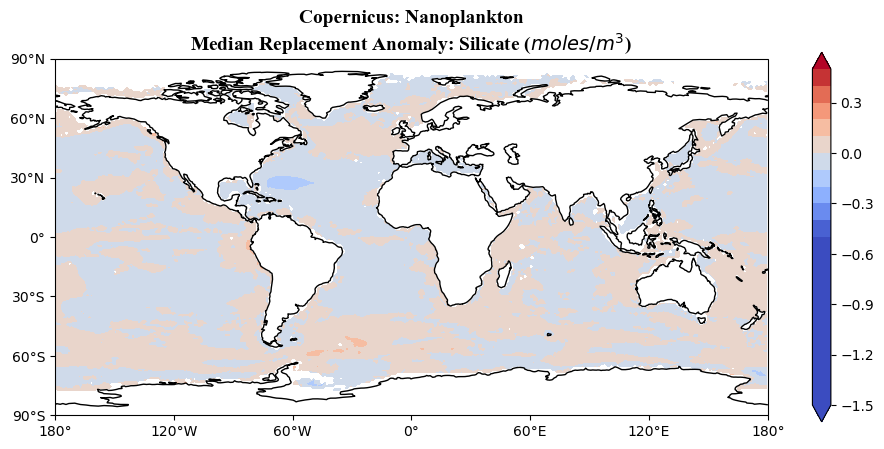

In [115]:
med_sensitivity_plot(sil5m, psc='lognano', levels=np.linspace(-1.5,0.5,21), vmin=-1.5, vmax=0.5,
                     title ="Copernicus: Nanoplankton\nMedian Replacement Anomaly: Silicate ($moles/m^3$)",
                     plot_name="sentinel_medianplot_nano_sil.jpg")

In [116]:
dif = (sil5m['logpico_pred'] - sil5m['logpico_med']).to_numpy()
dif = dif[~np.isnan(dif)]
print(dif.min(),dif.max())

-0.12729275598297995 0.09968674051827386


In [117]:
np.linspace(-0.2,0.1,7)

array([-2.00000000e-01, -1.50000000e-01, -1.00000000e-01, -5.00000000e-02,
        2.77555756e-17,  5.00000000e-02,  1.00000000e-01])

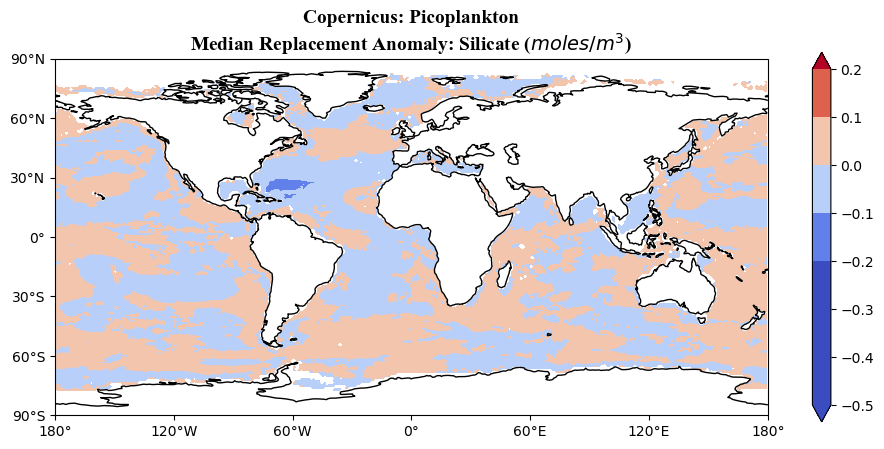

In [118]:
med_sensitivity_plot(sil5m, psc='logpico', levels=np.linspace(-0.5,0.2,8), vmin=-0.5, vmax=0.2,
                     title ="Copernicus: Picoplankton\nMedian Replacement Anomaly: Silicate ($moles/m^3$)",
                     plot_name="sentinel_medianplot_pico_sil.jpg")

#### Sensitivity Upwelling

In [169]:
X5wmo = Xs.copy(deep=True)
for col in Xs.columns:
    if col == 'w50':
        X5wmo[col] = X5wmo[col].quantile(q=0.5, interpolation='linear')
    else:
        X5wmo[col] = X5wmo[col]

In [170]:
X5wmo.head()

dfe        mld        nh4        no3        po4  \
month lat   lon                                                             
3      36.5 -37.5   15.678092  20.763959  23.540759  11.203083  13.696829   
1      18.5 -106.5  14.778835  11.995545  10.674643  10.045499  18.002340   
5      6.5   146.5  11.483299  12.905824  12.775478  10.061950  13.790572   
      -43.5  54.5   11.774301  14.049360  32.588384  29.685129  43.935279   
7     -25.5 -40.5   13.648497  15.964475  12.870045  16.894617  12.869771   

                          rsn        sal        sst        sil       w50  
month lat   lon                                                           
3      36.5 -37.5   55.529842  88.086983  59.367093  11.277342  55.45797  
1      18.5 -106.5  60.769178  82.413944  81.640122  11.465602  55.45797  
5      6.5   146.5  72.084681  82.087371  90.419431  11.242704  55.45797  
      -43.5  54.5   25.957871  82.750641  44.276942  14.157139  55.45797  
7     -25.5 -40.5   46.454293  89.221492  73.049505  13.414271  55.45797

In [171]:
wmo50 = data[['logchla_pred','logdiat_pred','logmcro_pred','lognano_pred','logpico_pred']].copy(deep=True)
wmo50['logchla_med'] = model_chla.predict(X5wmo)
wmo50['logdiat_med'] = model_diat.predict(X5wmo)
wmo50['logmcro_med'] = model_mcro.predict(X5wmo)
wmo50['lognano_med'] = model_nano.predict(X5wmo)
wmo50['logpico_med'] = model_pico.predict(X5wmo)

In [172]:
wmo5  = wmo50.to_xarray()
wmo5m = wmo5.mean(dim='month')
wmo5m = wmo5m.sortby(['lat','lon'])

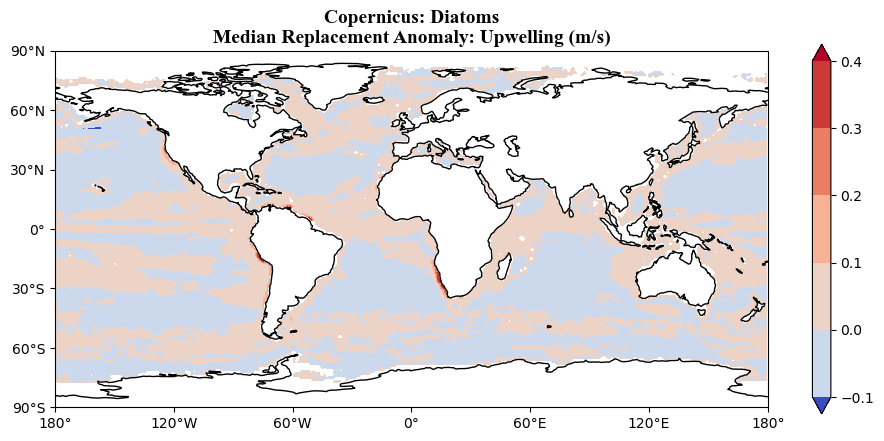

In [173]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(11.5,8), dpi=100)

# Set the axes using the specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# choose the data
anom_diat_wmo = (wmo5m['logdiat_pred'] - wmo5m['logdiat_med'])

# Make a filled contour plot
cs = ax.contourf(wmo5m['lon'], wmo5m['lat'],anom_diat_wmo,levels=5, 
                 transform=ccrs.PlateCarree(), 
                 norm=colors.CenteredNorm(),
                 cmap='coolwarm', extend='both')

# Add coastlines
ax.coastlines()

# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Add Title
fonttitle = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
ax.set_title("Copernicus: Diatoms\nMedian Replacement Anomaly: Upwelling (m/s)", fontdict=fonttitle)

# Add colorbar
cbar = plt.colorbar(cs, shrink=0.6)
plt.show()
fig.savefig(chartpath + "sentinel_medianplot_diat_wmo.jpg", dpi=200, bbox_inches="tight")

### Sensitivity Analysis - II
#### One input at original value and rest at 50th percentile

In [101]:
X.head()

dfe      mld       nh4       no3       po4  \
month lat   lon                                                           
4      50.5  162.5  4.941168e-07  105.967  0.000259  0.024746  0.001864   
       32.5 -144.5  3.252832e-07   90.714  0.000064  0.000027  0.000062   
1     -60.5  14.5   1.614190e-07   45.519  0.000786  0.026169  0.001604   
9     -40.5 -175.5  3.763122e-07  261.167  0.000178  0.002185  0.000321   
1     -41.5 -57.5   3.936858e-07   21.360  0.000298  0.005357  0.000582   

                           rsn        sal        sst       sil           w50  
month lat   lon                                                               
4      50.5  162.5  144.357692  33.091312   1.757090  0.048032  2.402339e-06  
       32.5 -144.5  204.896154  34.562000  17.337299  0.003517 -1.049352e-06  
1     -60.5  14.5   175.919231  33.813190   0.337590  0.049335  9.901261e-07  
9     -40.5 -175.5  147.162963  35.145687  12.900410  0.002797 -2.170450e-07  
1     -41.5 -57.5   290.265385  33.753387  15.072591  0.003858 -2.750195e-06

In [102]:
dataq = data.quantile(q=np.arange(0,1,0.01))

In [103]:
dataq.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  ...   logchla   logdiat  \
0.00   8.198891 -1.907710  0.000000 -0.000087  ... -1.864065 -2.301030   
0.01  29.785942 -1.839509  0.000089 -0.000009  ... -1.548917 -2.280564   
0.02  31.683790 -1.774310  0.000222 -0.000006  ... -1.548917 -2.280564   
0.03  32.332041 -1.713110  0.000336 -0.000005  ... -1.548917 -2.280564   
0.04  32.599701 -1.628910  0.000432 -0.000004  ... -1.548917 -2.280564   

       logmcro   lognano   logpico  logchla_pred  logdiat_pred  logmcro_pred  \
0.00 -2.000000 -2.301030 -2.000000     -1.852350     -2.301022     -1.999373   
0.01 -1.961513 -2.085845 -1.511635     -1.548917     -2.280564     -1.961513   
0.02 -1.961513 -2.085845 -1.511635     -1.548917     -2.280564     -1.961513   
0.03 -1.961513 -2.085845 -1.511635     -1.547095     -2.280564     -1.961513   
0.04 -1.961513 -2.085845 -1.511635     -1.543388     -2.280564     -1.961513   

      lognano_pred  logpico_pred  
0.00     -2.185392     -1.606023  
0.01     -2.085845     -1.511635  
0.02     -2.085845     -1.511635  
0.03     -2.085845     -1.511635  
0.04     -2.085845     -1.511635  

[5 rows x 26 columns]

In [104]:
dataq.columns

Index(['dfe', 'mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50',
       'chla', 'diat', 'dino', 'mcro', 'nano', 'pico', 'logchla', 'logdiat',
       'logmcro', 'lognano', 'logpico', 'logchla_pred', 'logdiat_pred',
       'logmcro_pred', 'lognano_pred', 'logpico_pred'],
      dtype='object')

In [106]:
Xq = dataq.drop(['chla', 'diat', 'dino', 'mcro', 'nano', 'pico', 'logchla', 'logdiat','logmcro', 'lognano', 'logpico','logchla_pred', 'logdiat_pred',
       'logmcro_pred', 'lognano_pred', 'logpico_pred'], axis=1)

In [107]:
Xqs = scaler.transform(Xq)
Xqs = pd.DataFrame(Xqs, columns=Xq.columns)
Xqs.head()

dfe        mld        nh4        no3        po4   rsn        sal  \
0  10.000000  10.000000  10.000000  10.000000  10.000000  10.0   9.259210   
1  10.240453  10.875201  10.222527  10.000000  10.317412  10.0  69.787053   
2  10.316137  11.023000  10.280287  10.001223  10.635563  10.0  75.108423   
3  10.358275  11.133264  10.320913  10.005532  10.890109  10.0  76.926052   
4  10.384897  11.228958  10.376222  10.011427  11.115622  10.0  77.676542   

         sst        sil        w50  
0  10.000000  10.000000  10.000000  
1  10.173844  10.062631  50.792385  
2  10.340036  10.156126  52.456325  
3  10.496035  10.236411  53.152702  
4  10.710660  10.304448  53.589668

#### Sensitivity Iron

In [108]:
Xqdfe50=Xqs.copy(deep=True)
for col in Xqs.columns:
    if col!='dfe':
        Xqdfe50[col]=Xqdfe50[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqdfe50[col]=Xqdfe50[col]                

In [201]:
Xqdfe50.head()

dfe        mld        nh4        no3        po4       rsn        sal  \
0  10.000000  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   
1  10.244506  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   
2  10.321465  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   
3  10.364314  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   
4  10.391384  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   

         sst        sil        w50  
0  59.545578  12.181289  56.393847  
1  59.545578  12.181289  56.393847  
2  59.545578  12.181289  56.393847  
3  59.545578  12.181289  56.393847  
4  59.545578  12.181289  56.393847

In [205]:
yqchla_pred = model_chla.predict(Xqdfe50)
yqdiat_pred = model_diat.predict(Xqdfe50)
yqmcro_pred = model_mcro.predict(Xqdfe50)
yqnano_pred = model_nano.predict(Xqdfe50)
yqpico_pred = model_pico.predict(Xqdfe50)

In [206]:
dfe_50 = Xq.copy(deep=True)
dfe_50['logchla_pred']=ychla_pred
dfe_50['logdiat_pred']=ydiat_pred
dfe_50['logmcro_pred']=ymcro_pred
dfe_50['lognano_pred']=ynano_pred
dfe_50['logpico_pred']=ypico_pred
dfe_50['logdfe']=np.log10(dfe_50['dfe'])

In [207]:
dfe_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -1.127497     -1.743448   
0.01  29.785942 -1.839509  0.000089 -0.000009     -1.130542     -1.743448   
0.02  31.683790 -1.774310  0.000222 -0.000006     -1.125837     -1.743776   
0.03  32.332041 -1.713110  0.000336 -0.000005     -1.124123     -1.743889   
0.04  32.599701 -1.628910  0.000432 -0.000004     -1.117135     -1.746322   

      logmcro_pred  lognano_pred  logpico_pred    logdfe  
0.00     -1.554888     -1.600783     -1.160370 -7.297104  
0.01     -1.554056     -1.602164     -1.182905 -7.106129  
0.02     -1.556998     -1.600222     -1.184074 -7.060029  
0.03     -1.559723     -1.607229     -1.191474 -7.036335  
0.04     -1.560685     -1.608685     -1.197811 -7.022007

In [222]:
oplist = ['logchla_pred','logdiat_pred','logmcro_pred','lognano_pred','logpico_pred']
dfe_50[oplist].to_numpy().max()

-0.4197198318093711

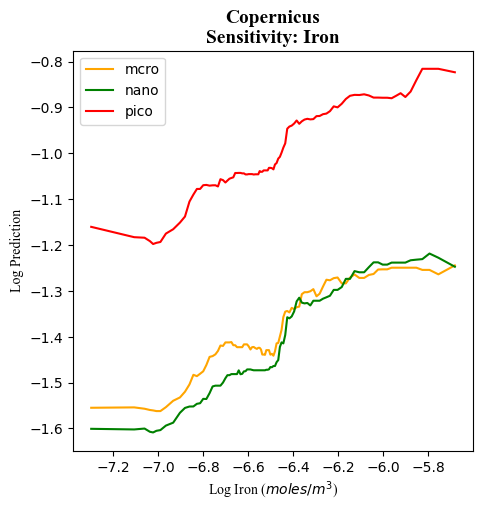

In [210]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
# sns.lineplot(data=dfe_50.reset_index(drop=True),x='logdfe',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
# sns.lineplot(data=dfe_50.reset_index(drop=True),x='logdfe',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=dfe_50.reset_index(drop=True),x='logdfe',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=dfe_50.reset_index(drop=True),x='logdfe',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=dfe_50.reset_index(drop=True),x='logdfe',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_xlabel(r"Log Iron ($moles/m^3$)", fontdict=fonttxt)
ax.set_ylabel("Log Prediction",fontdict=fonttxt)
ax.set_title("Copernicus\nSensitivity: Iron", fontdict=font)
# ax.set_ylim([-1.8, 0.2])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_dfe.jpg",bbox_inches='tight')

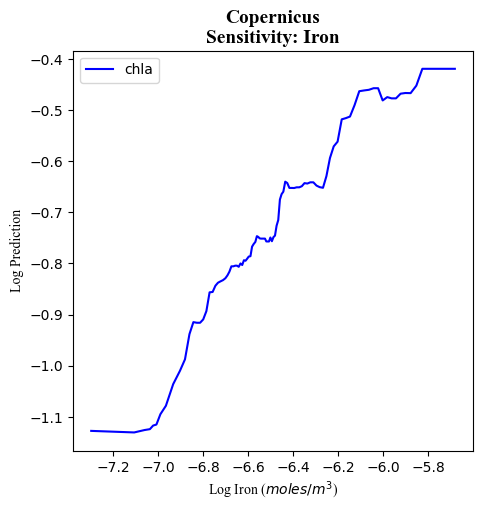

In [214]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
sns.lineplot(data=dfe_50.reset_index(drop=True),x='logdfe',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_xlabel(r"Log Iron ($moles/m^3$)", fontdict=fonttxt)
ax.set_ylabel("Log Prediction",fontdict=fonttxt)
ax.set_title("Copernicus\nSensitivity: Iron", fontdict=font)
# ax.set_ylim([-1.2,-0.2])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_dfe.jpg",bbox_inches='tight')

#### Sensitivity MLD

In [215]:
Xqmld50=Xqs.copy(deep=True)
for col in Xqs.columns:
    if col!='mld':
        Xqmld50[col]=Xqmld50[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqmld50[col]=Xqmld50[col]                

In [216]:
Xqmld50.head()

dfe        mld        nh4        no3        po4       rsn        sal  \
0  12.268703  10.000000  17.031504  12.567062  20.691351  58.56715  83.174985   
1  12.268703  10.860800  17.031504  12.567062  20.691351  58.56715  83.174985   
2  12.268703  11.006168  17.031504  12.567062  20.691351  58.56715  83.174985   
3  12.268703  11.114617  17.031504  12.567062  20.691351  58.56715  83.174985   
4  12.268703  11.208736  17.031504  12.567062  20.691351  58.56715  83.174985   

         sst        sil        w50  
0  59.545578  12.181289  56.393847  
1  59.545578  12.181289  56.393847  
2  59.545578  12.181289  56.393847  
3  59.545578  12.181289  56.393847  
4  59.545578  12.181289  56.393847

In [218]:
ychll_pred = model_chla.predict(Xqmld50)
ydiat_pred = model_diat.predict(Xqmld50)
ymcro_pred = model_mcro.predict(Xqmld50)
ynano_pred = model_nano.predict(Xqmld50)
ypico_pred = model_pico.predict(Xqmld50)

In [219]:
mld_50 = Xq.copy(deep=True)
mld_50['logchla_pred']=ychll_pred
mld_50['logdiat_pred']=ydiat_pred
mld_50['logmcro_pred']=ymcro_pred
mld_50['lognano_pred']=ynano_pred
mld_50['logpico_pred']=ypico_pred
mld_50['logmld'] = np.log(mld_50['mld'])

In [220]:
mld_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -0.713186     -1.536877   
0.01  29.785942 -1.839509  0.000089 -0.000009     -0.713186     -1.536877   
0.02  31.683790 -1.774310  0.000222 -0.000006     -0.733340     -1.536877   
0.03  32.332041 -1.713110  0.000336 -0.000005     -0.746115     -1.539792   
0.04  32.599701 -1.628910  0.000432 -0.000004     -0.743603     -1.540229   

      logmcro_pred  lognano_pred  logpico_pred    logmld  
0.00     -1.355866     -1.459790     -1.036108      -inf  
0.01     -1.355866     -1.459790     -1.036108  2.643128  
0.02     -1.359590     -1.459790     -1.035245  2.799170  
0.03     -1.371238     -1.473447     -1.035341  2.901531  
0.04     -1.371238     -1.473447     -1.035366  2.982596

In [224]:
print(mld_50[oplist].to_numpy().min(), mld_50[oplist].to_numpy().max())

-1.5904111114974997 -0.7131858510387431


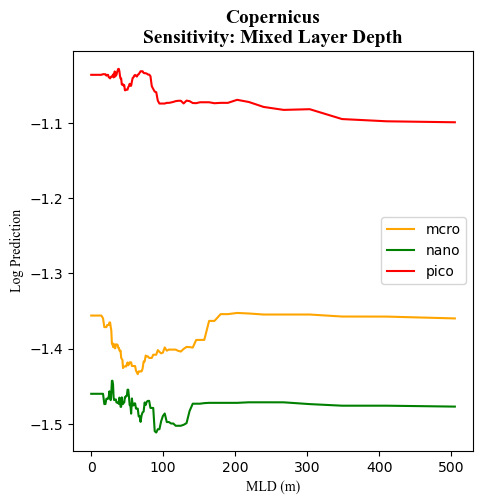

In [225]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
# sns.lineplot(data=mld_50.reset_index(drop=True),x='mld',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
# sns.lineplot(data=mld_50.reset_index(drop=True),x='mld',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=mld_50.reset_index(drop=True),x='mld',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=mld_50.reset_index(drop=True),x='mld',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=mld_50.reset_index(drop=True),x='mld',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Mixed Layer Depth", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"MLD (m)", fontdict=fonttxt)
# ax.set_ylim([-1.6,-0.2])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_mld.jpg",bbox_inches='tight')

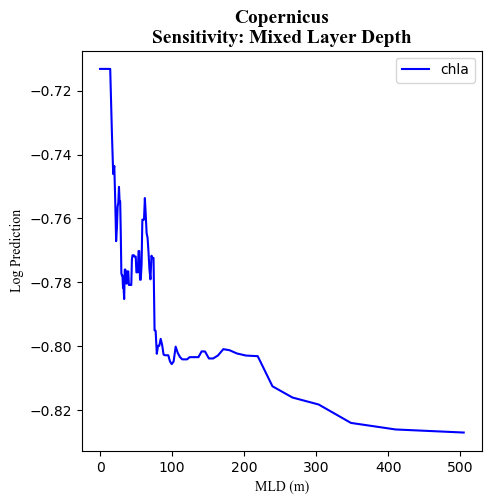

In [226]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
sns.lineplot(data=mld_50.reset_index(drop=True),x='mld',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Mixed Layer Depth", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"MLD (m)", fontdict=fonttxt)
# ax.set_ylim([-0.83, -0.68])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_mld.jpg",bbox_inches='tight')

#### Sensitivity $NH_4$

In [227]:
Xqnh450=Xqs.copy(deep=True)
for col in Xqs.columns:
    if col!='nh4':
        Xqnh450[col]=Xqnh450[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqnh450[col]=Xqnh450[col]                

In [228]:
Xqnh450.head()

dfe        mld        nh4        no3        po4       rsn        sal  \
0  12.268703  13.771675   9.993866  12.567062  20.691351  58.56715  83.174985   
1  12.268703  13.771675  10.216408  12.567062  20.691351  58.56715  83.174985   
2  12.268703  13.771675  10.274172  12.567062  20.691351  58.56715  83.174985   
3  12.268703  13.771675  10.314801  12.567062  20.691351  58.56715  83.174985   
4  12.268703  13.771675  10.370113  12.567062  20.691351  58.56715  83.174985   

         sst        sil        w50  
0  59.545578  12.181289  56.393847  
1  59.545578  12.181289  56.393847  
2  59.545578  12.181289  56.393847  
3  59.545578  12.181289  56.393847  
4  59.545578  12.181289  56.393847

In [230]:
ychll_pred = model_chla.predict(Xqnh450)
ydiat_pred = model_diat.predict(Xqnh450)
ymcro_pred = model_mcro.predict(Xqnh450)
ynano_pred = model_nano.predict(Xqnh450)
ypico_pred = model_pico.predict(Xqnh450)

In [231]:
nh4_50 = Xq.copy(deep=True)
nh4_50['logchla_pred']=ychll_pred
nh4_50['logdiat_pred']=ydiat_pred
nh4_50['logmcro_pred']=ymcro_pred
nh4_50['lognano_pred']=ynano_pred
nh4_50['logpico_pred']=ypico_pred
nh4_50['nh4_scaled']=nh4_50['nh4']*1e3

In [232]:
nh4_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -0.954571     -1.654087   
0.01  29.785942 -1.839509  0.000089 -0.000009     -0.943908     -1.656547   
0.02  31.683790 -1.774310  0.000222 -0.000006     -0.934714     -1.656547   
0.03  32.332041 -1.713110  0.000336 -0.000005     -0.933457     -1.656547   
0.04  32.599701 -1.628910  0.000432 -0.000004     -0.930061     -1.656547   

      logmcro_pred  lognano_pred  logpico_pred  nh4_scaled  
0.00     -1.504791     -1.641526     -1.100397    0.004437  
0.01     -1.504791     -1.643258     -1.096557    0.007631  
0.02     -1.504791     -1.643258     -1.085238    0.008460  
0.03     -1.506811     -1.640988     -1.066144    0.009043  
0.04     -1.506811     -1.640988     -1.063343    0.009837

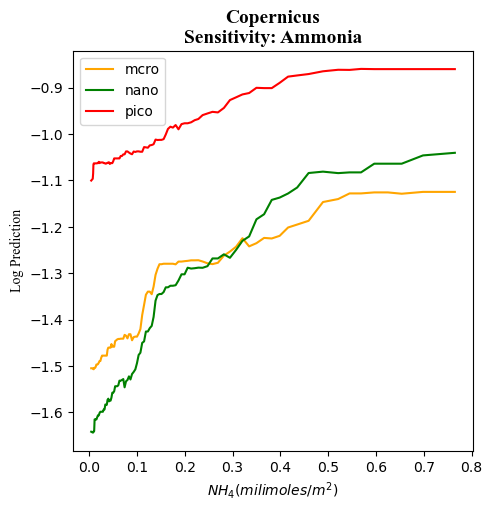

In [233]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
# sns.lineplot(data=nh4_50.reset_index(drop=True),x='nh4_scaled',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
# sns.lineplot(data=nh4_50.reset_index(drop=True),x='nh4_scaled',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=nh4_50.reset_index(drop=True),x='nh4_scaled',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=nh4_50.reset_index(drop=True),x='nh4_scaled',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=nh4_50.reset_index(drop=True),x='nh4_scaled',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Ammonia", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$NH_4 (milimoles/m^2)$", fontdict=fonttxt)
# ax.set_ylim([-2,0])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_nh4.jpg",bbox_inches='tight')

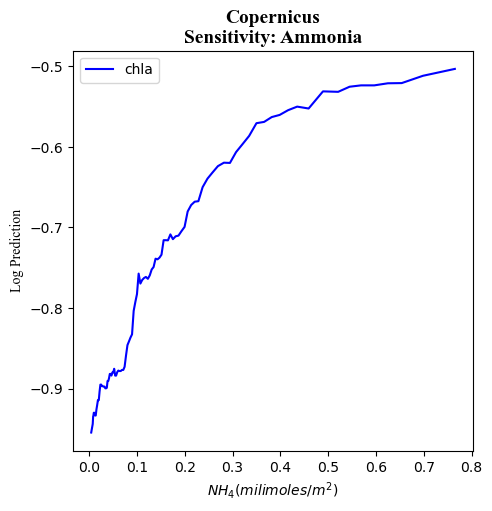

In [234]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
sns.lineplot(data=nh4_50.reset_index(drop=True),x='nh4_scaled',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Ammonia", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$NH_4 (milimoles/m^2)$", fontdict=fonttxt)
# ax.set_ylim([-1.0, -0.35])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_nh4.jpg",bbox_inches='tight')

#### Sensitivity $NO_3$

In [170]:
Xqno350=Xqs.copy(deep=True)
for col in Xqs.columns:
    if col!='no3':
        Xqno350[col]=Xqno350[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqno350[col]=Xqno350[col]                

In [171]:
Xqno350.head()

dfe        mld        nh4        no3        po4       rsn        sal  \
0  12.231098  13.771675  18.136247  10.000000  20.627522  58.51851  83.715328   
1  12.231098  13.771675  18.136247  10.000000  20.627522  58.51851  83.715328   
2  12.231098  13.771675  18.136247  10.001210  20.627522  58.51851  83.715328   
3  12.231098  13.771675  18.136247  10.005475  20.627522  58.51851  83.715328   
4  12.231098  13.771675  18.136247  10.011308  20.627522  58.51851  83.715328   

         sst       sil        w50  
0  60.241688  12.07575  55.446769  
1  60.241688  12.07575  55.446769  
2  60.241688  12.07575  55.446769  
3  60.241688  12.07575  55.446769  
4  60.241688  12.07575  55.446769

In [172]:
ychll_pred = model_chll.predict(Xqno350)
ydiat_pred = model_diat.predict(Xqno350)
ymcro_pred = model_mcro.predict(Xqno350)
ynano_pred = model_nano.predict(Xqno350)
ypico_pred = model_pico.predict(Xqno350)

In [173]:
no3_50 = Xq.copy(deep=True)
no3_50['logchla_pred']=ychll_pred
no3_50['logdiat_pred']=ydiat_pred
no3_50['logmcro_pred']=ymcro_pred
no3_50['lognano_pred']=ynano_pred
no3_50['logpico_pred']=ypico_pred

In [174]:
no3_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -0.900418     -1.631603   
0.01  29.785942 -1.839509  0.000089 -0.000009     -0.900418     -1.631603   
0.02  31.683790 -1.774310  0.000222 -0.000006     -0.900418     -1.631603   
0.03  32.332041 -1.713110  0.000336 -0.000005     -0.900418     -1.632447   
0.04  32.599701 -1.628910  0.000432 -0.000004     -0.900418     -1.629229   

      logmcro_pred  lognano_pred  logpico_pred  
0.00     -1.395855     -1.593976     -1.113673  
0.01     -1.395855     -1.593976     -1.113673  
0.02     -1.393841     -1.601561     -1.113673  
0.03     -1.418532     -1.601561     -1.105235  
0.04     -1.418532     -1.611864     -1.109358

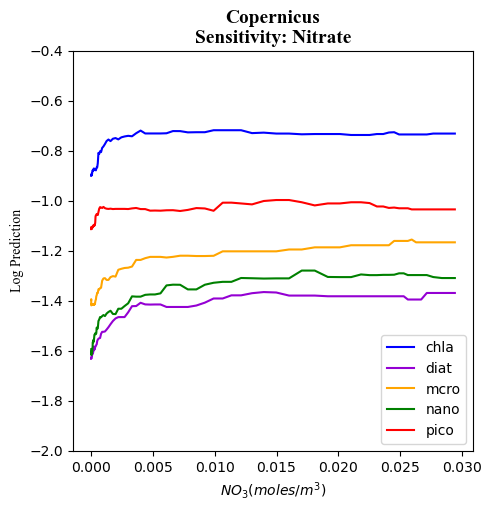

In [176]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
sns.lineplot(data=no3_50.reset_index(drop=True),x='no3',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
sns.lineplot(data=no3_50.reset_index(drop=True),x='no3',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=no3_50.reset_index(drop=True),x='no3',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=no3_50.reset_index(drop=True),x='no3',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=no3_50.reset_index(drop=True),x='no3',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Nitrate", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$NO_3 (moles/m^3)$", fontdict=fonttxt)
ax.set_ylim([-2.0,-0.4])
plt.legend(loc='lower right')
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_no3.jpg",bbox_inches='tight')

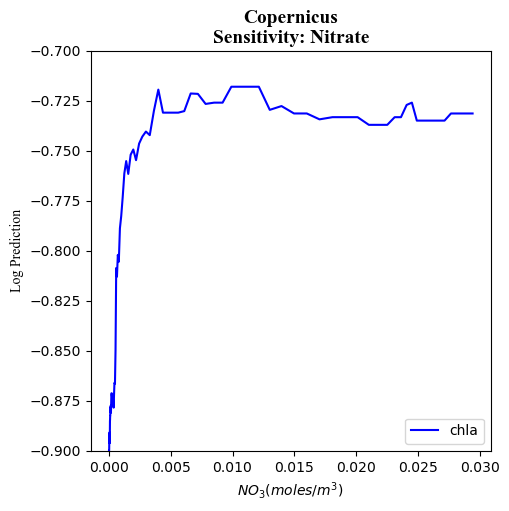

In [177]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
sns.lineplot(data=no3_50.reset_index(drop=True),x='no3',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Nitrate", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$NO_3 (moles/m^3)$", fontdict=fonttxt)
ax.set_ylim([-0.90, -0.70])
plt.legend(loc='lower right')
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_no3.jpg",bbox_inches='tight')

#### Sensitivity $PO_4$

In [178]:
Xqpo450=Xqs.copy(deep=True)
for col in Xs.columns:
    if col!='po4':
        Xqpo450[col]=Xqpo450[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqpo450[col]=Xqpo450[col]                

In [179]:
Xqpo450.head()

dfe        mld        nh4       no3        po4       rsn        sal  \
0  12.231098  13.771675  18.136247  12.54029  10.000000  58.51851  83.715328   
1  12.231098  13.771675  18.136247  12.54029  10.317412  58.51851  83.715328   
2  12.231098  13.771675  18.136247  12.54029  10.635563  58.51851  83.715328   
3  12.231098  13.771675  18.136247  12.54029  10.890109  58.51851  83.715328   
4  12.231098  13.771675  18.136247  12.54029  11.115622  58.51851  83.715328   

         sst       sil        w50  
0  60.241688  12.07575  55.446769  
1  60.241688  12.07575  55.446769  
2  60.241688  12.07575  55.446769  
3  60.241688  12.07575  55.446769  
4  60.241688  12.07575  55.446769

In [180]:
ychll_pred = model_chll.predict(Xqpo450)
ydiat_pred = model_diat.predict(Xqpo450)
ymcro_pred = model_mcro.predict(Xqpo450)
ynano_pred = model_nano.predict(Xqpo450)
ypico_pred = model_pico.predict(Xqpo450)

In [181]:
po4_50 = Xq.copy(deep=True)
po4_50['logchla_pred']=ychll_pred
po4_50['logdiat_pred']=ydiat_pred
po4_50['logmcro_pred']=ymcro_pred
po4_50['lognano_pred']=ynano_pred
po4_50['logpico_pred']=ypico_pred

In [182]:
po4_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -0.785011     -1.503220   
0.01  29.785942 -1.839509  0.000089 -0.000009     -0.785011     -1.503220   
0.02  31.683790 -1.774310  0.000222 -0.000006     -0.785011     -1.501083   
0.03  32.332041 -1.713110  0.000336 -0.000005     -0.788586     -1.501083   
0.04  32.599701 -1.628910  0.000432 -0.000004     -0.786269     -1.501083   

      logmcro_pred  lognano_pred  logpico_pred  
0.00     -1.316356     -1.464383     -1.062212  
0.01     -1.316356     -1.464383     -1.062212  
0.02     -1.316356     -1.464383     -1.062212  
0.03     -1.316356     -1.466648     -1.052574  
0.04     -1.316356     -1.466648     -1.052574

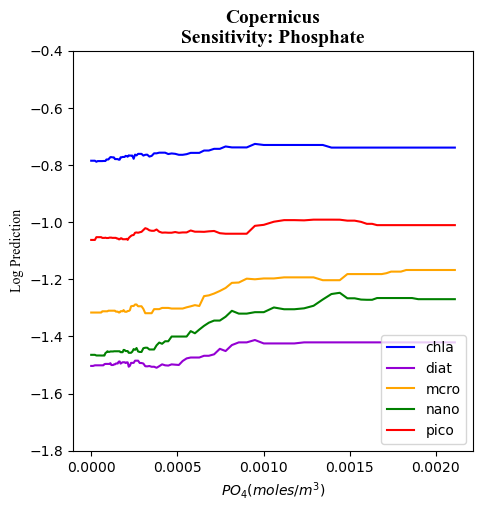

In [188]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
sns.lineplot(data=po4_50.reset_index(drop=True),x='po4',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
sns.lineplot(data=po4_50.reset_index(drop=True),x='po4',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=po4_50.reset_index(drop=True),x='po4',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=po4_50.reset_index(drop=True),x='po4',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=po4_50.reset_index(drop=True),x='po4',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Phosphate", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$PO_4 (moles/m^3)$", fontdict=fonttxt)
ax.set_ylim([-1.8, -0.4])
plt.legend(loc='lower right')
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_po4.jpg",bbox_inches='tight')

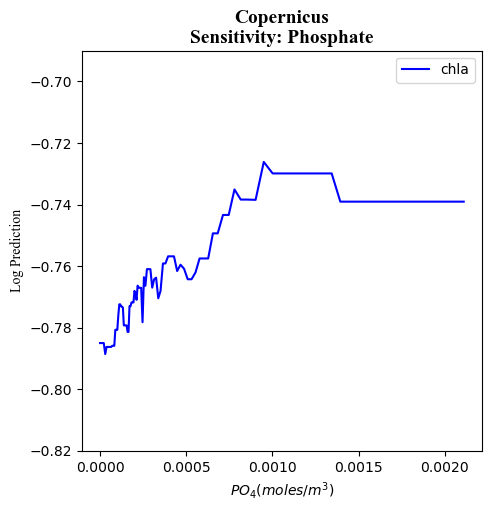

In [190]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
sns.lineplot(data=po4_50.reset_index(drop=True),x='po4',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Phosphate", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$PO_4 (moles/m^3)$", fontdict=fonttxt)
ax.set_ylim([-0.82,-0.69])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_po4.jpg",bbox_inches='tight')

#### Sensitivity Shortwave Radiation

In [248]:
Xqrsn50=Xqs.copy(deep=True)
for col in Xqs.columns:
    if col!='rsn':
        Xqrsn50[col]=Xqrsn50[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqrsn50[col]=Xqrsn50[col]                

In [249]:
Xqrsn50.head()

dfe        mld        nh4        no3        po4   rsn        sal  \
0  12.268703  13.771675  17.031504  12.567062  20.691351  10.0  83.174985   
1  12.268703  13.771675  17.031504  12.567062  20.691351  10.0  83.174985   
2  12.268703  13.771675  17.031504  12.567062  20.691351  10.0  83.174985   
3  12.268703  13.771675  17.031504  12.567062  20.691351  10.0  83.174985   
4  12.268703  13.771675  17.031504  12.567062  20.691351  10.0  83.174985   

         sst        sil        w50  
0  59.545578  12.181289  56.393847  
1  59.545578  12.181289  56.393847  
2  59.545578  12.181289  56.393847  
3  59.545578  12.181289  56.393847  
4  59.545578  12.181289  56.393847

In [250]:
yqchll_pred = model_chla.predict(Xqrsn50)
yqdiat_pred = model_diat.predict(Xqrsn50)
yqmcro_pred = model_mcro.predict(Xqrsn50)
yqnano_pred = model_nano.predict(Xqrsn50)
yqpico_pred = model_pico.predict(Xqrsn50)

In [251]:
rsn_50 = Xq.copy(deep=True)
rsn_50['logchla_pred']=yqchll_pred
rsn_50['logdiat_pred']=yqdiat_pred
rsn_50['logmcro_pred']=yqmcro_pred
rsn_50['lognano_pred']=yqnano_pred
rsn_50['logpico_pred']=yqpico_pred

In [252]:
rsn_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -1.459281     -2.101303   
0.01  29.785942 -1.839509  0.000089 -0.000009     -1.459281     -2.101303   
0.02  31.683790 -1.774310  0.000222 -0.000006     -1.459281     -2.101303   
0.03  32.332041 -1.713110  0.000336 -0.000005     -1.459281     -2.101303   
0.04  32.599701 -1.628910  0.000432 -0.000004     -1.459281     -2.101303   

      logmcro_pred  lognano_pred  logpico_pred  
0.00     -1.845806     -1.952517     -1.323217  
0.01     -1.845806     -1.952517     -1.323217  
0.02     -1.845806     -1.952517     -1.323217  
0.03     -1.845806     -1.952517     -1.323217  
0.04     -1.845806     -1.952517     -1.323217

In [266]:
optlist = ['logmcro_pred','lognano_pred','logpico_pred']
print(rsn50[optlist].to_numpy().min(), rsn50[optlist].to_numpy().max())

-2.202253543261845 0.8768966436119179


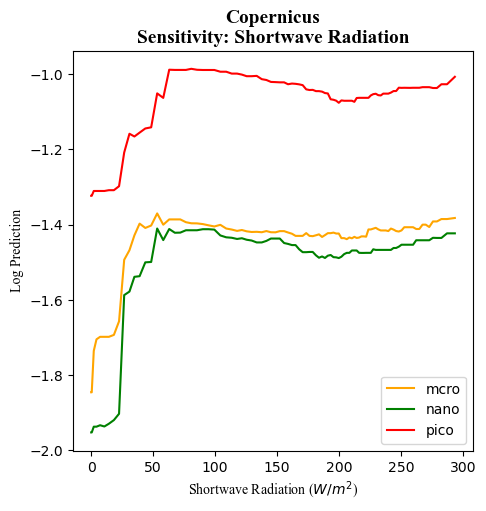

In [282]:
fig=plt.figure(figsize=(4,4),dpi=100)
ax=fig.add_axes([0,0,1,1])
# sns.lineplot(data=rsn_50.reset_index(drop=True),x='rsn',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
# sns.lineplot(data=rsn_50.reset_index(drop=True),x='rsn',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=rsn_50.reset_index(drop=True),x='rsn',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=rsn_50.reset_index(drop=True),x='rsn',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=rsn_50.reset_index(drop=True),x='rsn',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_ylabel("Log Prediction",fontdict=fonttxt)
ax.set_xlabel(r"Shortwave Radiation ($W/m^2$)", fontdict=fonttxt)
ax.set_title("Copernicus\nSensitivity: Shortwave Radiation", fontdict=font)
# ax.set_ylim([-2.3,0.2])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_rsn.jpg",dpi=200,bbox_inches='tight')

In [271]:
print(rsn50['logchla_pred'].min(), rsn50['logchla_pred'].max())

-1.8362327286525357 0.5728914907380769


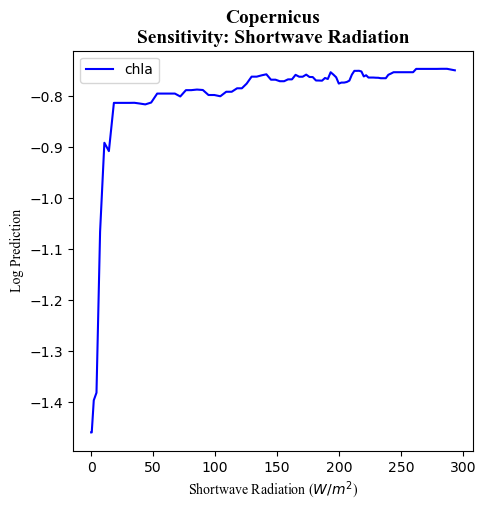

In [254]:
fig=plt.figure(figsize=(4,4),dpi=100)
ax=fig.add_axes([0,0,1,1])
sns.lineplot(data=rsn_50.reset_index(drop=True),x='rsn',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_ylabel("Log Prediction",fontdict=fonttxt)
ax.set_xlabel(r"Shortwave Radiation ($W/m^2$)", fontdict=fonttxt)
ax.set_title("Copernicus\nSensitivity: Shortwave Radiation", fontdict=font)
# ax.set_ylim([-1.25, -0.45])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_rsn.jpg",dpi=200,bbox_inches='tight')

In [485]:
# fig = plt.figure(figsize=(4,4),dpi=100)
# ax = fig.add_axes([0,0,1,1])
# sns.regplot(data=rsn_50.reset_index(),x='rsn',y='logdiat_pred',x_bins=1000,x_ci='sd',fit_reg=False,label='diat',color='blue',ax=ax,scatter_kws=dict(s=2), )
# sns.regplot(data=rsn_50.reset_index(),x='rsn',y='logmcro_pred',x_bins=1000,x_ci='sd',fit_reg=False,label='macro',color='orange',ax=ax,scatter_kws=dict(s=2))
# sns.regplot(data=rsn_50.reset_index(),x='rsn',y='lognano_pred',x_bins=1000,x_ci='sd',fit_reg=False,label='nano',color='green',ax=ax,scatter_kws=dict(s=2))
# sns.regplot(data=rsn_50.reset_index(),x='rsn',y='logpico_pred',x_bins=1000,x_ci='sd',fit_reg=False,label='pico',color='red',ax=ax,scatter_kws=dict(s=2))
# ax.set_ylabel("log Prediction")
# ax.set_xlabel(r"Shortwave Radiation ($W/m^2$)")
# ax.set_title("Copernicus\nSensitivity: Shortwave Radiation")
# plt.legend()
# plt.show()
# fig.savefig(filepath + "sentinel_rsn_sens_plot.jpg",bbox_inches='tight')

#### Sensitivity Salinity

In [198]:
Xqsal50=Xqs.copy(deep=True)
for col in Xqs.columns:
    if col!='sal':
        Xqsal50[col]=Xqsal50[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqsal50[col]=Xqsal50[col]               

In [199]:
Xqsal50.head()

dfe        mld        nh4       no3        po4       rsn        sal  \
0  12.231098  13.771675  18.136247  12.54029  20.627522  58.51851  10.000000   
1  12.231098  13.771675  18.136247  12.54029  20.627522  58.51851  70.400067   
2  12.231098  13.771675  18.136247  12.54029  20.627522  58.51851  75.710204   
3  12.231098  13.771675  18.136247  12.54029  20.627522  58.51851  77.523995   
4  12.231098  13.771675  18.136247  12.54029  20.627522  58.51851  78.272901   

         sst       sil        w50  
0  60.241688  12.07575  55.446769  
1  60.241688  12.07575  55.446769  
2  60.241688  12.07575  55.446769  
3  60.241688  12.07575  55.446769  
4  60.241688  12.07575  55.446769

In [200]:
yqchll_pred = model_chll.predict(Xqsal50)
yqdiat_pred = model_diat.predict(Xqsal50)
yqmcro_pred = model_mcro.predict(Xqsal50)
yqnano_pred = model_nano.predict(Xqsal50)
yqpico_pred = model_pico.predict(Xqsal50)

In [201]:
sal_50 = Xq.copy(deep=True)
sal_50['logchla_pred']=yqchll_pred
sal_50['logdiat_pred']=yqdiat_pred
sal_50['logmcro_pred']=yqmcro_pred
sal_50['lognano_pred']=yqnano_pred
sal_50['logpico_pred']=yqpico_pred

In [202]:
sal_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -0.704797     -1.464629   
0.01  29.785942 -1.839509  0.000089 -0.000009     -0.704797     -1.464629   
0.02  31.683790 -1.774310  0.000222 -0.000006     -0.713038     -1.503452   
0.03  32.332041 -1.713110  0.000336 -0.000005     -0.713038     -1.512248   
0.04  32.599701 -1.628910  0.000432 -0.000004     -0.764169     -1.500031   

      logmcro_pred  lognano_pred  logpico_pred  
0.00     -1.270826     -1.443919     -1.100418  
0.01     -1.270826     -1.443919     -1.087264  
0.02     -1.317790     -1.457477     -1.097692  
0.03     -1.324041     -1.480015     -1.097692  
0.04     -1.324041     -1.486114     -1.096282

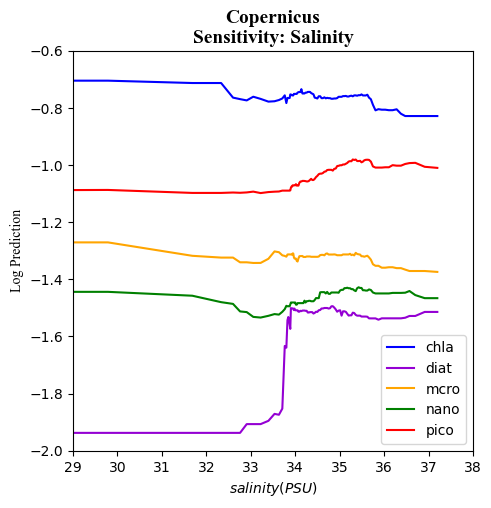

In [205]:
fig=plt.figure(figsize=(4,4),dpi=100)
ax=fig.add_axes([0,0,1,1])
sns.lineplot(data=sal_50.reset_index(drop=True),x='sal',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
sns.lineplot(data=rsn_50.reset_index(drop=True),x='sal',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=sal_50.reset_index(drop=True),x='sal',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=sal_50.reset_index(drop=True),x='sal',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=sal_50.reset_index(drop=True),x='sal',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_ylabel("Log Prediction",fontdict=fonttxt)
ax.set_xlabel(r"$salinity (PSU)$", fontdict=fonttxt)
ax.set_title("Copernicus\nSensitivity: Salinity", fontdict=font)
ax.set_ylim([-2, -0.6])
ax.set_xlim([29,38])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_sal.jpg",bbox_inches='tight')

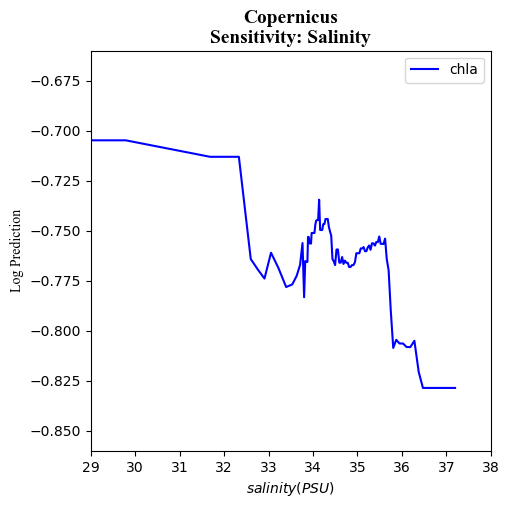

In [206]:
fig=plt.figure(figsize=(4,4),dpi=100)
ax=fig.add_axes([0,0,1,1])
sns.lineplot(data=sal_50.reset_index(drop=True),x='sal',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_ylabel("Log Prediction",fontdict=fonttxt)
ax.set_xlabel(r"$salinity (PSU)$", fontdict=fonttxt)
ax.set_title("Copernicus\nSensitivity: Salinity", fontdict=font)
ax.set_xlim([29,38])
ax.set_ylim([-0.86,-0.66])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_sal.jpg",bbox_inches='tight')

#### Sensitivity SST

In [109]:
Xqtos50=Xqs.copy(deep=True)
for col in Xs.columns:
    if col!='sst':
        Xqtos50[col]=Xqtos50[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqtos50[col]=Xqtos50[col]                

In [110]:
Xqtos50.head()

dfe        mld        nh4        no3        po4       rsn        sal  \
0  12.231098  13.834773  17.037158  12.567062  20.627522  58.56715  83.130482   
1  12.231098  13.834773  17.037158  12.567062  20.627522  58.56715  83.130482   
2  12.231098  13.834773  17.037158  12.567062  20.627522  58.56715  83.130482   
3  12.231098  13.834773  17.037158  12.567062  20.627522  58.56715  83.130482   
4  12.231098  13.834773  17.037158  12.567062  20.627522  58.56715  83.130482   

         sst        sil        w50  
0  10.000000  12.044234  55.446769  
1  10.173844  12.044234  55.446769  
2  10.340036  12.044234  55.446769  
3  10.496035  12.044234  55.446769  
4  10.710660  12.044234  55.446769

In [112]:
ychll_pred = model_chla.predict(Xqtos50)
ydiat_pred = model_diat.predict(Xqtos50)
ymcro_pred = model_mcro.predict(Xqtos50)
ynano_pred = model_nano.predict(Xqtos50)
ypico_pred = model_pico.predict(Xqtos50)

In [113]:
tos_50 = Xq.copy(deep=True)
tos_50['logchla_pred']=ychll_pred
tos_50['logdiat_pred']=ydiat_pred
tos_50['logmcro_pred']=ymcro_pred
tos_50['lognano_pred']=ynano_pred
tos_50['logpico_pred']=ypico_pred

In [114]:
tos_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -0.502956     -0.545445   
0.01  29.785942 -1.839509  0.000089 -0.000009     -0.502956     -0.545445   
0.02  31.683790 -1.774310  0.000222 -0.000006     -0.444914     -0.520443   
0.03  32.332041 -1.713110  0.000336 -0.000005     -0.444914     -0.483321   
0.04  32.599701 -1.628910  0.000432 -0.000004     -0.444914     -0.490020   

      logmcro_pred  lognano_pred  logpico_pred  
0.00     -0.472372     -0.852365     -0.999501  
0.01     -0.472372     -0.852365     -0.999501  
0.02     -0.469297     -0.852365     -0.999501  
0.03     -0.469199     -0.852365     -0.999501  
0.04     -0.474484     -0.852365     -0.999501

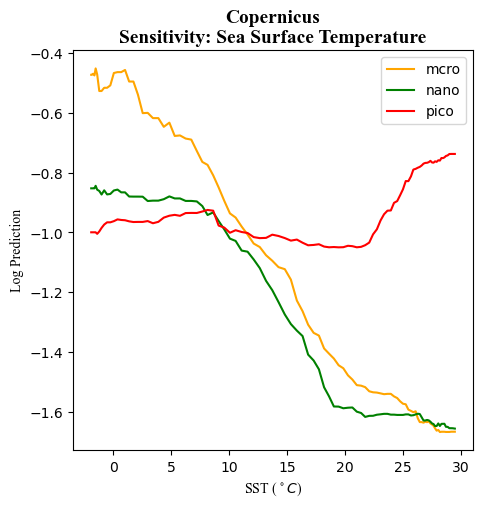

In [115]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
# sns.lineplot(data=tos_50.reset_index(drop=True),x='sst',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
# sns.lineplot(data=tos_50.reset_index(drop=True),x='sst',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=tos_50.reset_index(drop=True),x='sst',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=tos_50.reset_index(drop=True),x='sst',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=tos_50.reset_index(drop=True),x='sst',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Sea Surface Temperature", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"SST ($^\circ C$)", fontdict=fonttxt)
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_sst.jpg",bbox_inches='tight')

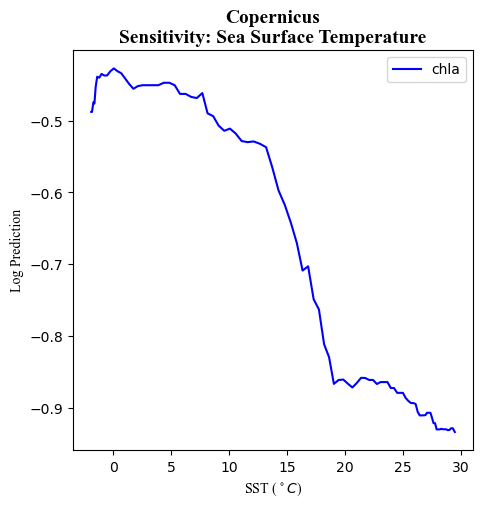

In [519]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_axes([0,0,1,1])
sns.lineplot(data=tos_50.reset_index(drop=True),x='sst',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Sea Surface Temperature", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"SST ($^\circ C$)", fontdict=fonttxt)
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_sst.jpg",bbox_inches='tight')

#### Sensitivity Silicate

In [272]:
Xqsil50=Xqs.copy(deep=True)
for col in Xqs.columns:
    if col!='sil':
        Xqsil50[col]=Xqsil50[col].quantile(q=0.5,interpolation='linear')
    else:
        Xqsil50[col]=Xqsil50[col]                

In [273]:
Xqsil50.head()

dfe        mld        nh4        no3        po4       rsn        sal  \
0  12.268703  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   
1  12.268703  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   
2  12.268703  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   
3  12.268703  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   
4  12.268703  13.771675  17.031504  12.567062  20.691351  58.56715  83.174985   

         sst        sil        w50  
0  59.545578  10.000000  56.393847  
1  59.545578  10.066830  56.393847  
2  59.545578  10.166594  56.393847  
3  59.545578  10.252261  56.393847  
4  59.545578  10.324859  56.393847

In [274]:
yqchll_pred = model_chla.predict(Xqsil50)
yqdiat_pred = model_diat.predict(Xqsil50)
yqmcro_pred = model_mcro.predict(Xqsil50)
yqnano_pred = model_nano.predict(Xqsil50)
yqpico_pred = model_pico.predict(Xqsil50)

In [275]:
sil_50 = Xq.copy(deep=True)
sil_50['logchla_pred']=yqchll_pred
sil_50['logdiat_pred']=yqdiat_pred
sil_50['logmcro_pred']=yqmcro_pred
sil_50['lognano_pred']=yqnano_pred
sil_50['logpico_pred']=yqpico_pred

In [276]:
sil_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -0.766782     -1.573258   
0.01  29.785942 -1.839509  0.000089 -0.000009     -0.766782     -1.573258   
0.02  31.683790 -1.774310  0.000222 -0.000006     -0.770174     -1.573258   
0.03  32.332041 -1.713110  0.000336 -0.000005     -0.770174     -1.573258   
0.04  32.599701 -1.628910  0.000432 -0.000004     -0.768161     -1.573258   

      logmcro_pred  lognano_pred  logpico_pred  
0.00     -1.420884     -1.470101     -1.030723  
0.01     -1.420884     -1.470101     -1.030723  
0.02     -1.420884     -1.465344     -1.028119  
0.03     -1.420884     -1.465344     -1.028119  
0.04     -1.420884     -1.465344     -1.028119

In [277]:
print(sil50[optlist].to_numpy().min(), sil50[optlist].to_numpy().max())

-2.202253543261845 0.8768966436119179


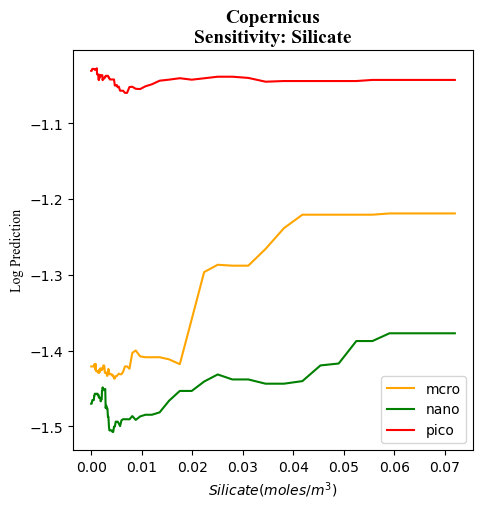

In [281]:
fig=plt.figure(figsize=(4,4),dpi=100)
ax=fig.add_axes([0,0,1,1])
# sns.lineplot(data=sil_50.reset_index(drop=True),x='sil',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
# sns.lineplot(data=sil_50.reset_index(drop=True),x='sil',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='darkviolet')
sns.lineplot(data=sil_50.reset_index(drop=True),x='sil',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=sil_50.reset_index(drop=True),x='sil',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=sil_50.reset_index(drop=True),x='sil',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Silicate", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
# ax.set_ylim([-2.2,1.0])
ax.set_xlabel(r"$Silicate (moles/m^3)$", fontdict=fonttxt)
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_sil.jpg",bbox_inches='tight')

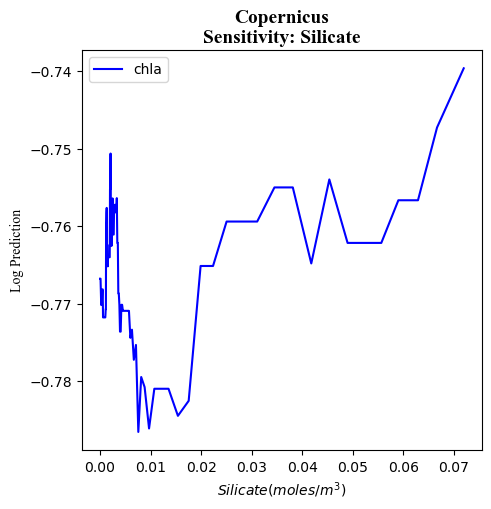

In [263]:
fig=plt.figure(figsize=(4,4),dpi=100)
ax=fig.add_axes([0,0,1,1])
sns.lineplot(data=sil_50.reset_index(drop=True),x='sil',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
font = {'family':'Times New Roman','color':'black','fontsize':14,'fontweight':'bold'}
fonttxt = {'family':'Times New Roman','color':'black','fontsize':10}
ax.set_title("Copernicus\nSensitivity: Silicate", fontdict=font)
ax.set_ylabel("Log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$Silicate (moles/m^3)$", fontdict=fonttxt)
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_sil.jpg",bbox_inches='tight')

#### Sensitivity Upwelling

In [507]:
Xqwmo50 = Xqs.copy(deep=True)
for col in Xqs.columns:
    if col != 'w50':
        Xqwmo50[col] = Xqwmo50[col].quantile(q=0.5, interpolation='linear')
    else:
        Xqwmo50[col] = Xqwmo50[col]        

In [508]:
Xqwmo50.head()

dfe        mld        nh4       no3        po4       rsn        sal  \
0  12.225806  13.771675  17.056987  12.54029  20.640205  58.56715  83.130482   
1  12.225806  13.771675  17.056987  12.54029  20.640205  58.56715  83.130482   
2  12.225806  13.771675  17.056987  12.54029  20.640205  58.56715  83.130482   
3  12.225806  13.771675  17.056987  12.54029  20.640205  58.56715  83.130482   
4  12.225806  13.771675  17.056987  12.54029  20.640205  58.56715  83.130482   

         sst        sil        w50  
0  60.240204  12.044234  10.000000  
1  60.240204  12.044234  50.792385  
2  60.240204  12.044234  52.456325  
3  60.240204  12.044234  53.152702  
4  60.240204  12.044234  53.589668

In [509]:
ychll_pred = model_chll.predict(Xqwmo50)
ydiat_pred = model_diat.predict(Xqwmo50)
ymcro_pred = model_mcro.predict(Xqwmo50)
ynano_pred = model_nano.predict(Xqwmo50)
ypico_pred = model_pico.predict(Xqwmo50)

In [510]:
wmo_50 = Xq.copy(deep=True)
wmo_50['logchla_pred']=ychll_pred
wmo_50['logdiat_pred']=ydiat_pred
wmo_50['logmcro_pred']=ymcro_pred
wmo_50['lognano_pred']=ynano_pred
wmo_50['logpico_pred']=ypico_pred

In [511]:
wmo_50.head()

dfe       mld       nh4           no3       po4  rsn  \
0.00  5.045405e-08   0.00000  0.000004  0.000000e+00  0.000000  0.0   
0.01  7.831972e-08  14.05711  0.000008  0.000000e+00  0.000011  0.0   
0.02  8.709057e-08  16.43100  0.000008  6.286818e-07  0.000021  0.0   
0.03  9.197394e-08  18.20200  0.000009  2.843963e-06  0.000030  0.0   
0.04  9.505904e-08  19.73900  0.000010  5.874563e-06  0.000038  0.0   

            sal       sst       sil       w50  logchla_pred  logdiat_pred  \
0.00   8.198891 -1.907710  0.000000 -0.000087     -0.804131     -1.535569   
0.01  29.785942 -1.839509  0.000089 -0.000009     -0.804131     -1.535569   
0.02  31.683790 -1.774310  0.000222 -0.000006     -0.804131     -1.535569   
0.03  32.332041 -1.713110  0.000336 -0.000005     -0.804131     -1.535569   
0.04  32.599701 -1.628910  0.000432 -0.000004     -0.819607     -1.538653   

      logmcro_pred  lognano_pred  logpico_pred  
0.00     -1.329169     -1.423307     -1.009090  
0.01     -1.329169     -1.423307     -1.011099  
0.02     -1.329169     -1.423307     -1.011959  
0.03     -1.325494     -1.421189     -1.011959  
0.04     -1.325494     -1.449144     -1.019777

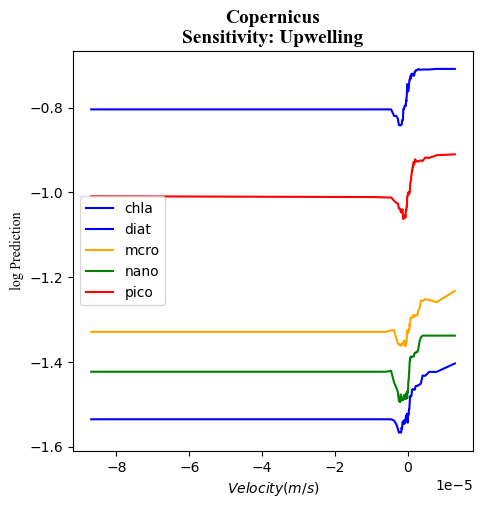

In [512]:
fig=plt.figure(figsize=(4,4),dpi=100)
ax=fig.add_axes([0,0,1,1])
sns.lineplot(data=wmo_50.reset_index(drop=True),x='w50',y='logchla_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='chla',color='blue')
sns.lineplot(data=wmo_50.reset_index(drop=True),x='w50',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='blue')
sns.lineplot(data=wmo_50.reset_index(drop=True),x='w50',y='logmcro_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='mcro',color='orange')
sns.lineplot(data=wmo_50.reset_index(drop=True),x='w50',y='lognano_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='nano',color='green')
sns.lineplot(data=wmo_50.reset_index(drop=True),x='w50',y='logpico_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='pico',color='red')
ax.set_ylabel("log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$Velocity (m/s)$", fontdict=fonttxt)
ax.set_title("Copernicus\nSensitivity: Upwelling", fontdict=font)
# ax.set_xlim([29,38])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_w50.jpg",bbox_inches='tight')

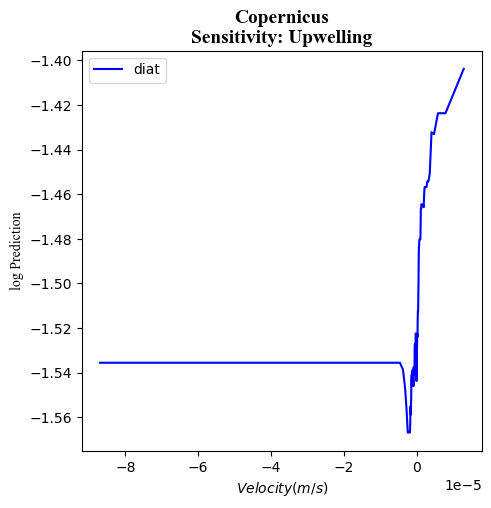

In [520]:
fig=plt.figure(figsize=(4,4),dpi=100)
ax=fig.add_axes([0,0,1,1])
sns.lineplot(data=wmo_50.reset_index(drop=True),x='w50',y='logdiat_pred',ax=ax,estimator='mean',sort=True,err_style='band',label='diat',color='blue')
ax.set_ylabel("log Prediction", fontdict=fonttxt)
ax.set_xlabel(r"$Velocity (m/s)$", fontdict=fonttxt)
ax.set_title("Copernicus\nSensitivity: Upwelling", fontdict=font)
# ax.set_xlim([29,38])
plt.legend()
plt.show()
fig.savefig(chartpath + "Sentinel_sensplot_chla_w50.jpg",bbox_inches='tight')

### Partial Dependence Plots

In [39]:
from sklearn.inspection import PartialDependenceDisplay

In [51]:
features = X.columns

'dfe'

In [46]:
Xs = scaler.transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)
fig.suptitle("Copernicus Chlorophyll-A\n Partial Dependence Plots", font=

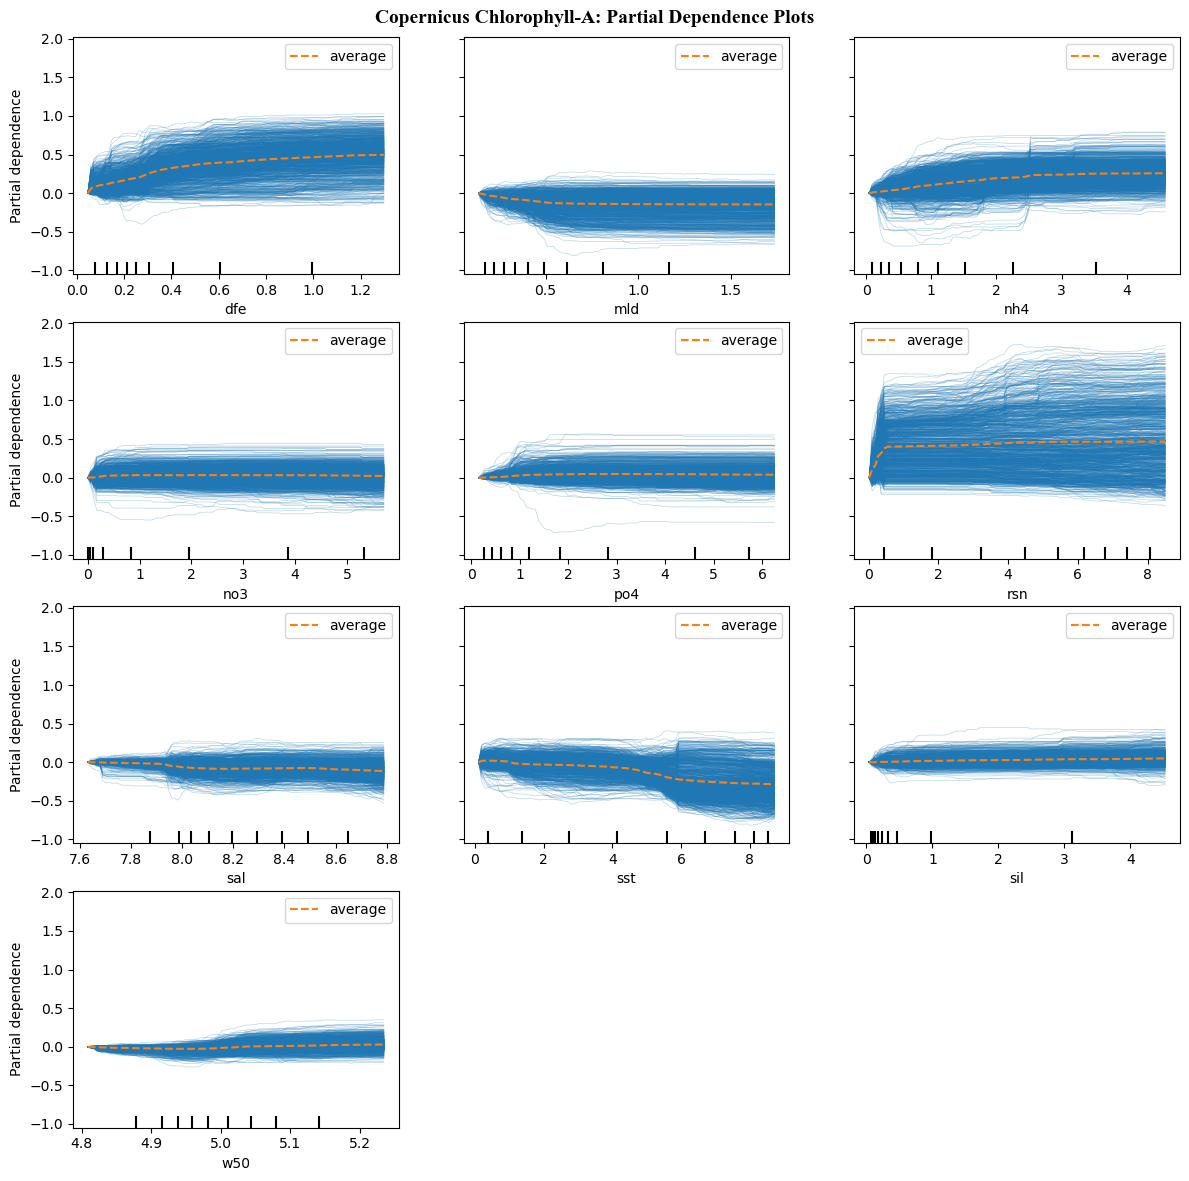

In [73]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
PartialDependenceDisplay.from_estimator(model_chla, Xs_test, features, grid_resolution=100, ax=ax, kind='both', centered=True)
fig.suptitle("Copernicus Chlorophyll-A: Partial Dependence Plots", fontsize=14, fontweight='bold', color='black', family='Times New Roman')
plt.tight_layout()
fig.savefig(chartpath + "sentinel_PDP_chla.jpg", dpi=200,bbox_inches='tight')

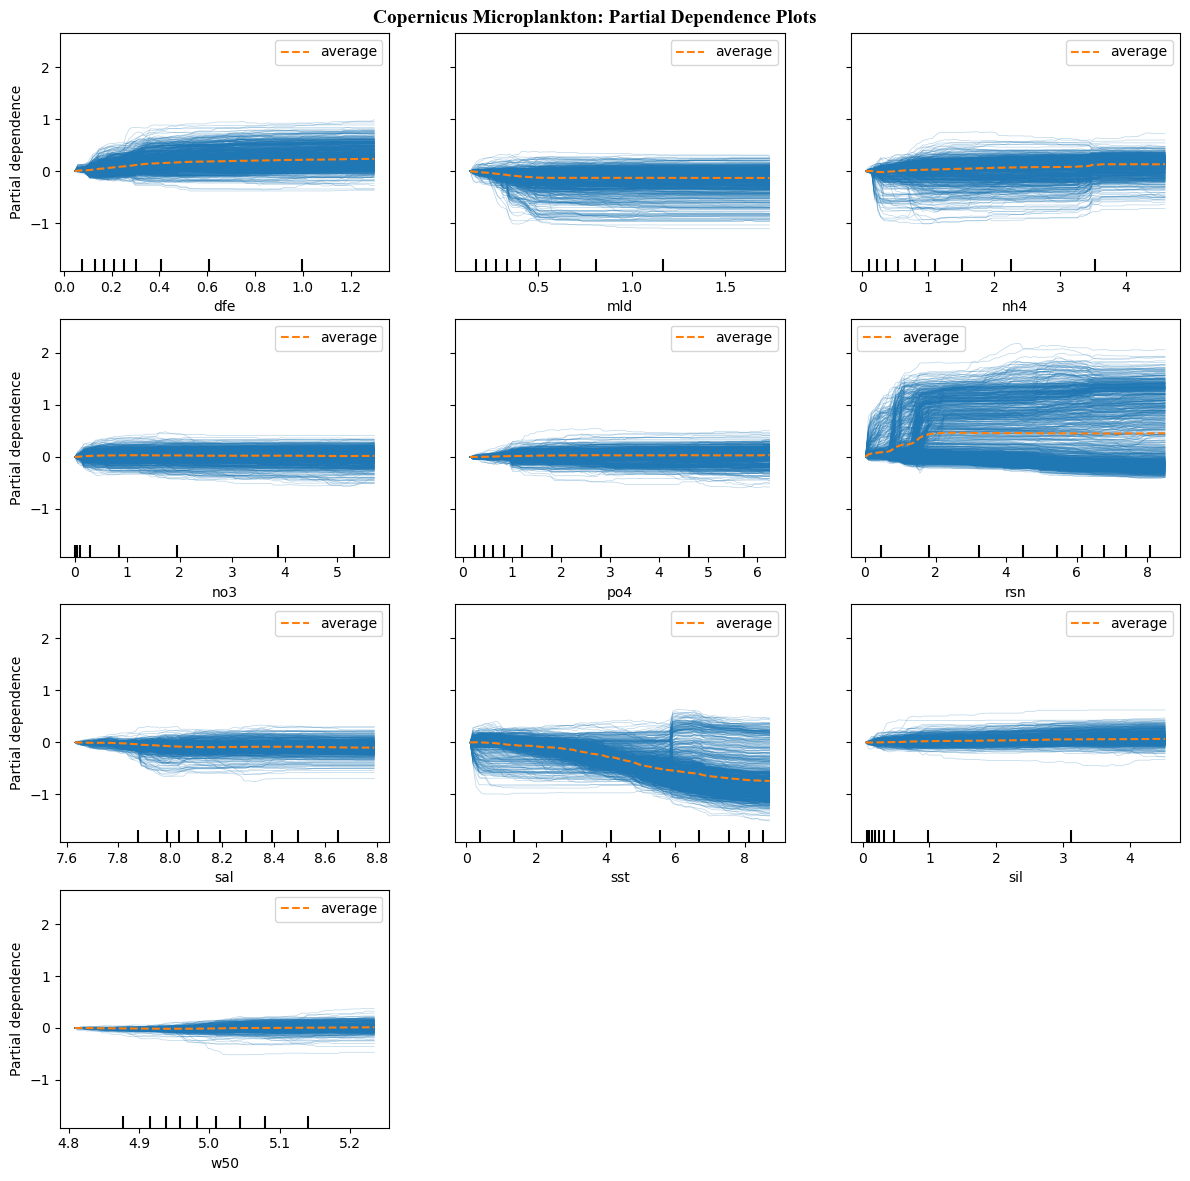

In [74]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
PartialDependenceDisplay.from_estimator(model_mcro, Xs_test, features, grid_resolution=100, ax=ax, kind='both', centered=True)
fig.suptitle("Copernicus Microplankton: Partial Dependence Plots", fontsize=14, fontweight='bold', color='black', family='Times New Roman')
plt.tight_layout()
fig.savefig(chartpath + "sentinel_PDP_mcro.jpg", dpi=200,bbox_inches='tight')

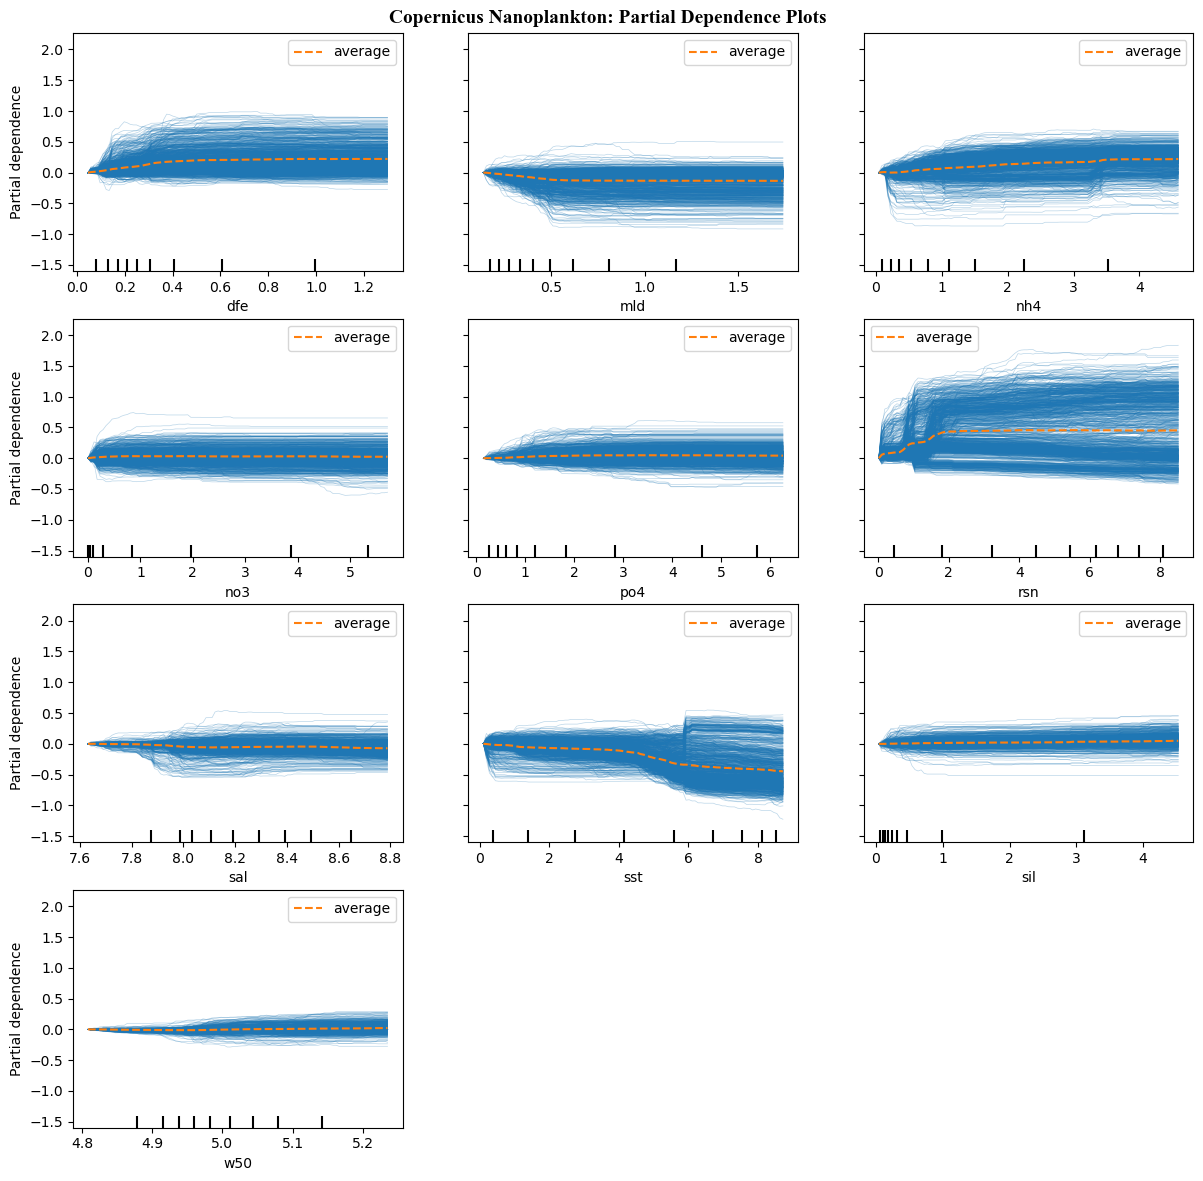

In [75]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
PartialDependenceDisplay.from_estimator(model_nano, Xs_test, features, grid_resolution=100, ax=ax, kind='both', centered=True)
fig.suptitle("Copernicus Nanoplankton: Partial Dependence Plots", fontsize=14, fontweight='bold', color='black', family='Times New Roman')
plt.tight_layout()
fig.savefig(chartpath + "sentinel_PDP_nano.jpg", dpi=200,bbox_inches='tight')

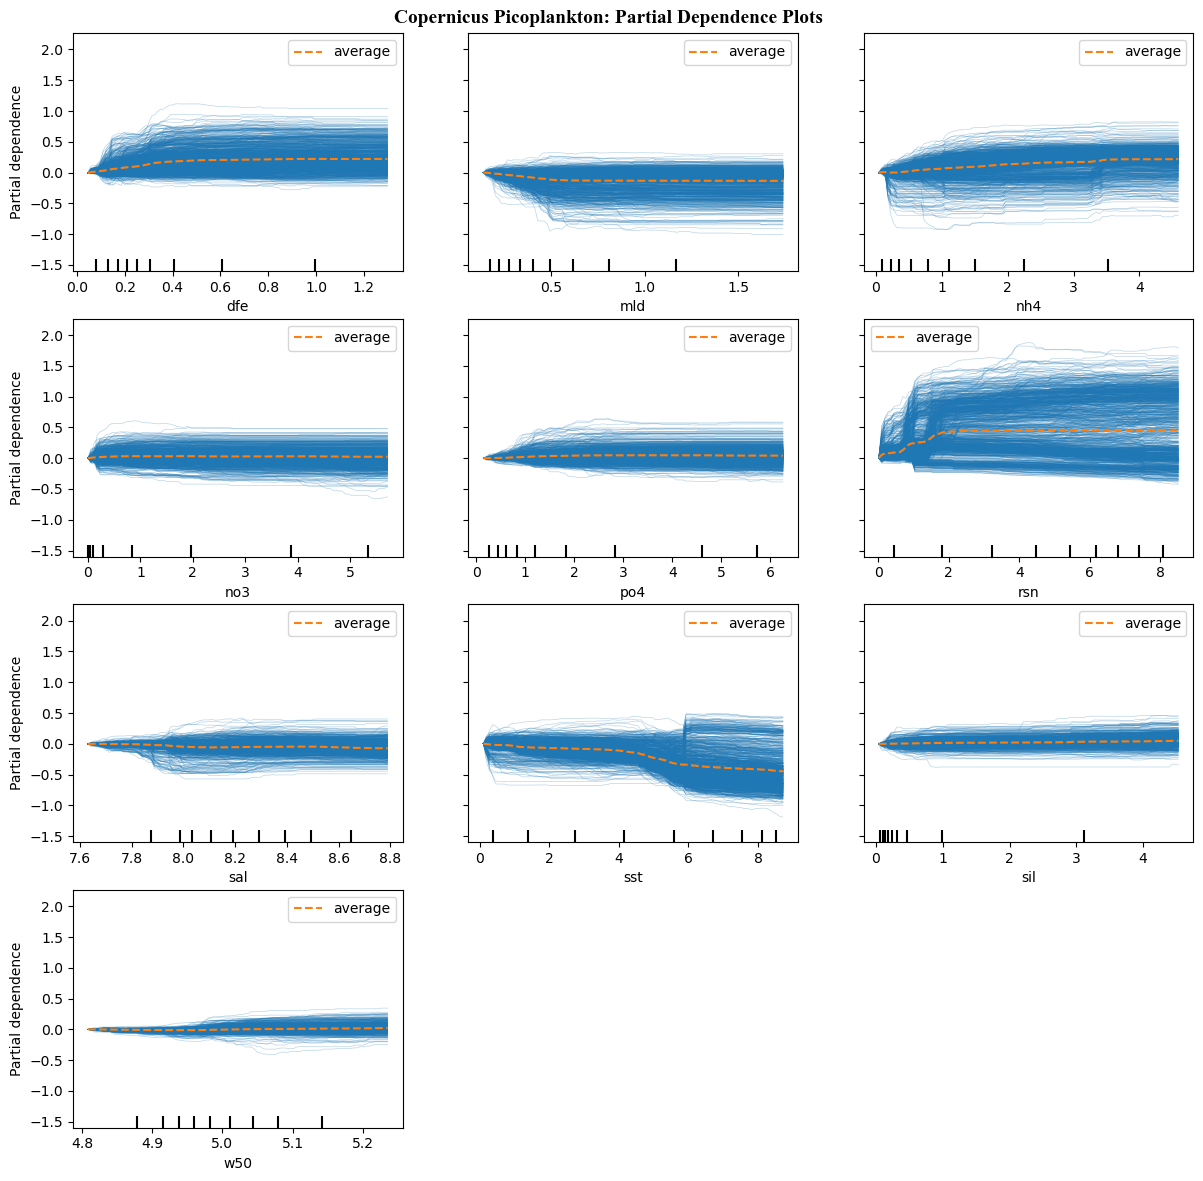

In [76]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
PartialDependenceDisplay.from_estimator(model_nano, Xs_test, features, grid_resolution=100, ax=ax, kind='both', centered=True)
fig.suptitle("Copernicus Picoplankton: Partial Dependence Plots", fontsize=14, fontweight='bold', color='black', family='Times New Roman')
plt.tight_layout()
fig.savefig(chartpath + "sentinel_PDP_pico.jpg", dpi=200,bbox_inches='tight')